*Bettio Vittoria* 2122414 <br>
vittoria.bettio@studenti.unipd.it <br>
17/07/2024

# **Temporal and spatial analysis of earthquakes in Italy in the last century**

Italy lies at the boundary of the African and Eurasian tectonic plates, and both plates move and smash into each other releasing a lot of energy and making Italy a seismically active zone, especially central Italy. In order to better study the relationship between the occurrence of earthquakes and the geological structure, we will present the temporal and spatial characteristics of earthquakes, explore the temporal and spatial rules of earthquake disasters and determine the seismically active regions in Italy.
We will investigate and analyze the earthquakes data coming from the USGS Earthquake Hazards Program with the magnitude greater than MW 4.5 that occurred in Italy during the last hundred years: from 1921 to 2021.

_______

Loading necessary libraries

In [1]:
library(ggplot2)
library(reshape2)
library(dplyr)
library(sf)
library(forecast)
library(gridExtra)
library(magick)
library(grid)
library(cluster)
library(tidyr)
library(dendextend)
library(ggdendro)
library(viridis)


Caricamento pacchetto: 'dplyr'


I seguenti oggetti sono mascherati da 'package:stats':

    filter, lag


I seguenti oggetti sono mascherati da 'package:base':

    intersect, setdiff, setequal, union


Linking to GEOS 3.12.1, GDAL 3.8.4, PROJ 9.3.1; sf_use_s2() is TRUE

Warning message:
"il pacchetto 'forecast' è stato creato con R versione 4.4.1"
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Warning message:
"il pacchetto 'gridExtra' è stato creato con R versione 4.4.1"

Caricamento pacchetto: 'gridExtra'


Il seguente oggetto è mascherato da 'package:dplyr':

    combine


Warning message:
"il pacchetto 'magick' è stato creato con R versione 4.4.1"
Linking to ImageMagick 6.9.12.98
Enabled features: cairo, freetype, fftw, ghostscript, heic, lcms, pango, raw, rsvg, webp
Disabled features: fontconfig, x11

Warning message:
"il pacchetto 'cluster' è stato creato con R versione 4.4.1"

Caricamento pacchetto: 'tidyr'


Il seguente ogg

Load the dataset into a DataFrame coming from the [USGS](https://earthquake.usgs.gov/earthquakes/map/?extent=31.05293,2.54883&extent=47.90161,30.67383&range=search&sort=oldest&timeZone=utc&settings=true&search=%7B%22name%22:%22Search%20Results%22,%22params%22:%7B%22starttime%22:%221921-01-01%2000:00:00%22,%22endtime%22:%222021-01-01%2000:00:00%22,%22maxlatitude%22:47,%22minlatitude%22:35,%22maxlongitude%22:18,%22minlongitude%22:6,%22minmagnitude%22:4.5,%22eventtype%22:%22earthquake%22,%22orderby%22:%22time-asc%22%7D%7D) database.

In [2]:
df <- read.csv("query.csv")

We want to make sure of filtering the events to include only earthquakes that occurred in Italy.

In [3]:
df_italia <- df[grepl("Italy", df$place, ignore.case = TRUE), ]
df_italia <- data.frame(df_italia, row.names = NULL)
df_italia$time <- as.POSIXct(df_italia$time,
                             format = "%Y-%m-%dT%H:%M:%OSZ", tz = "UTC")
df_italia <- df_italia[order(df_italia$time), ]
df_italia$year <- as.numeric(format(df_italia$time, "%Y"))

In [4]:
columns_to_drop <- c("status", "type", "net", "id", "magNst", "locationSource",
                     "magSource", "horizontalError", "depthError", "magError",
                     "magType", "updated", "dmin", "rms")
df_italia <- df_italia[, !(names(df_italia) %in% columns_to_drop)]


Let's examine and explain the dataset:

In [5]:
tail(df_italia, 5)

,time,latitude,longitude,depth,mag,nst,gap,place,year
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<dbl>
585,2019-12-09 03:37:05,43.9875,11.3176,10.00,4.6,NA,39,"2 km N of San Piero a Sieve, Italy",2019
586,2020-02-24 16:03:00,39.3625,16.1751,10.00,4.8,NA,54,"2 km E of San Vincenzo la Costa, Italy",2020
587,2020-04-16 09:42:53,44.7000,9.4064,10.00,4.5,NA,33,"2 km SE of Marsaglia, Italy",2020
588,2020-12-22 20:27:23,36.9548,14.4067,23.02,4.5,NA,44,"7 km NNW of Scoglitti, Italy",2020
589,2020-12-29 14:36:56,45.1886,11.0546,10.00,4.6,NA,25,"0 km NNW of Nogara, Italy",2020


**mag:** The magnitude reported is that which the U.S. Geological Survey considers official for this earthquake, and was the best available estimate of the earthquake’s size, at the time that the dataset was created. 
Earthquake magnitude is a measure of the size of an earthquake at its source. It is a logarithmic measure. At the same distance from the earthquake, the amplitude of the seismic waves from which the magnitude is determined are approximately 10 times as large during a magnitude 5 earthquake as during a magnitude 4 earthquake. 

**nst (Number of Stations that Reported):**  The total number of seismic stations used to determine earthquake location. Number of seismic stations which reported arrival times for this earthquake. 

**gap:** The largest azimuthal gap between azimuthally adjacent stations (in degrees). In general, the smaller this number, the more reliable is the calculated horizontal position of the earthquake. 

## Table of Contents
1. [Preliminary Analysis](#preliminar-analysis) <br>
    1.1 [Gutenberg-Richter Law](#gutenberg-richter-law)<br>
    1.2 [Yearly Distribution](#yearly-distribution) <br>
2. [Time Series](#time-series) <br>
    2.1 [Forecast](#forecast)<br>
3. [Magnitude Analysis](#magnitude-analysis)<br>
    3.1 [Year-Magnitude Correlation](#year-magnitude-correlation)<br>
    3.2 [AEM Forecast](#aem-forecast)<br>
    3.3 [MEM Forecast](#mem-forecast)<br>
4. [Spatial Analysis](#spatial-analysis)<br>
    4.1 [Seismic Hazard](#seismic-hazard) <br>
    4.2 [Regional Study](#regional-study) <br>
    4.3. [Clustering](#clustering)<br>

## Preliminar Analysis


Let's have a look at the distribution of Earthquake Magnitudes and Depths

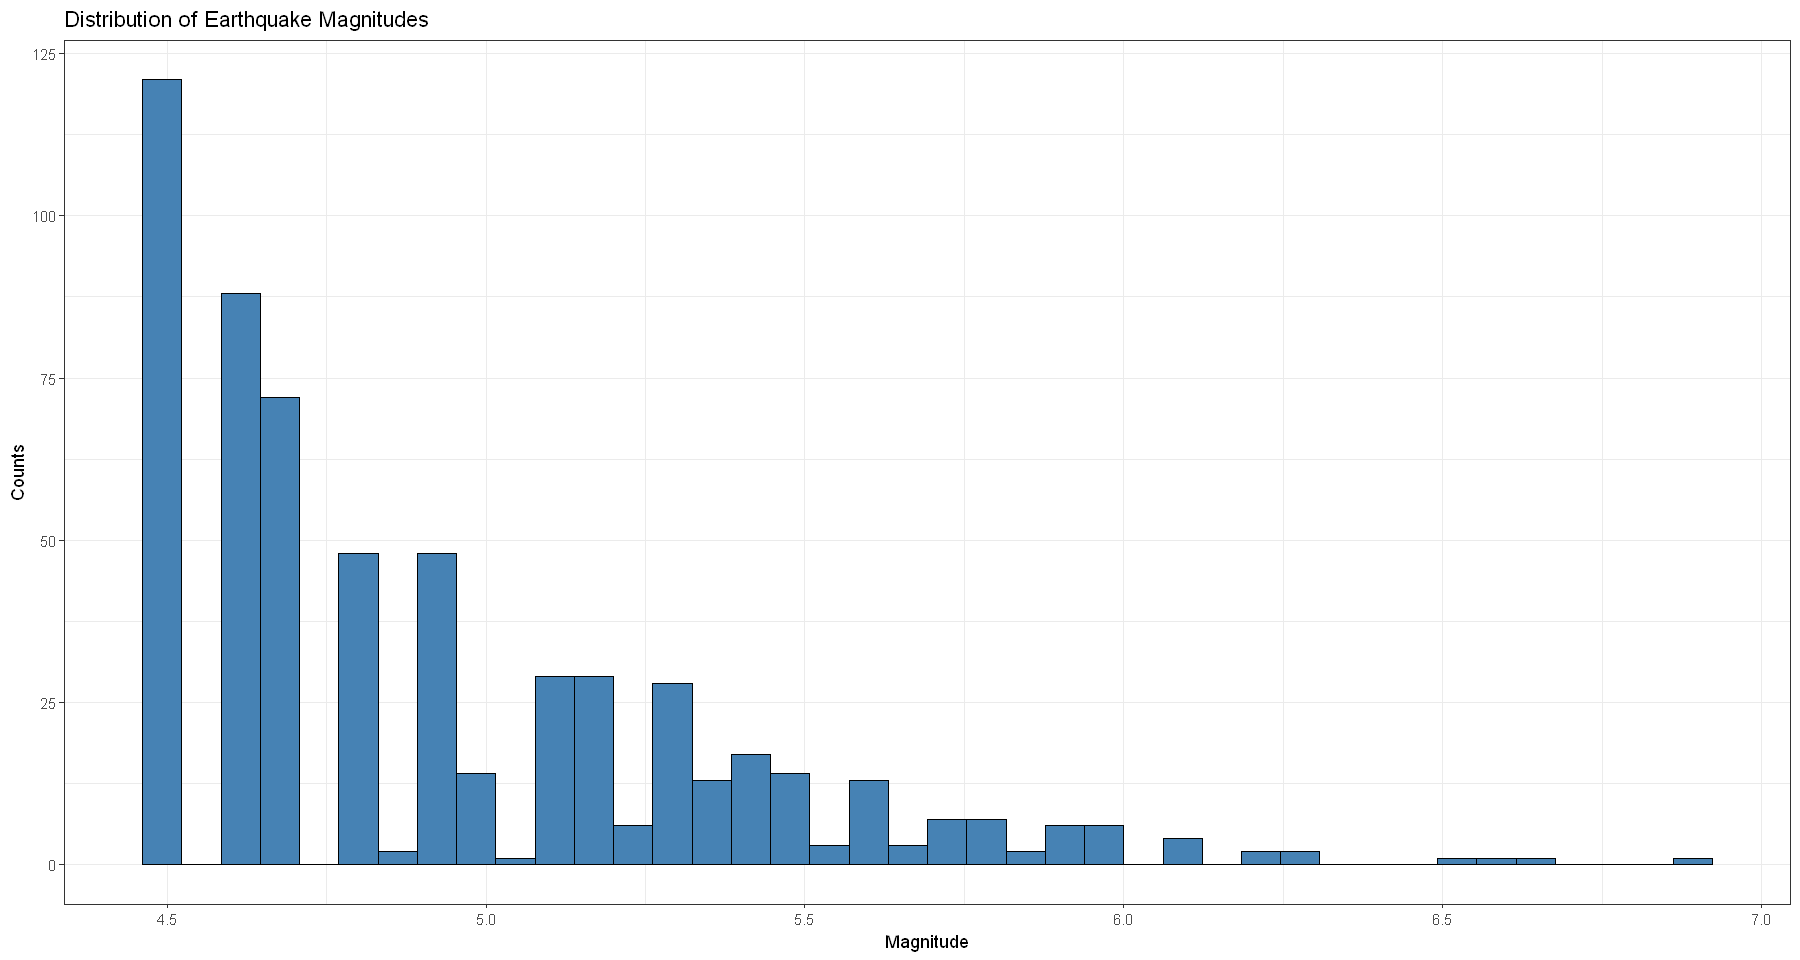

In [6]:
options(repr.plot.width = 15, repr.plot.height = 8)

ggplot(df_italia, aes(x = mag)) +
  geom_histogram(fill = "steelblue", color = "black", bins = 40) +
  labs(title = "Distribution of Earthquake Magnitudes",
       x = "Magnitude",
       y = "Counts") +
  theme_bw()


As expected there is a much lower number of catastrofic earthquakes.

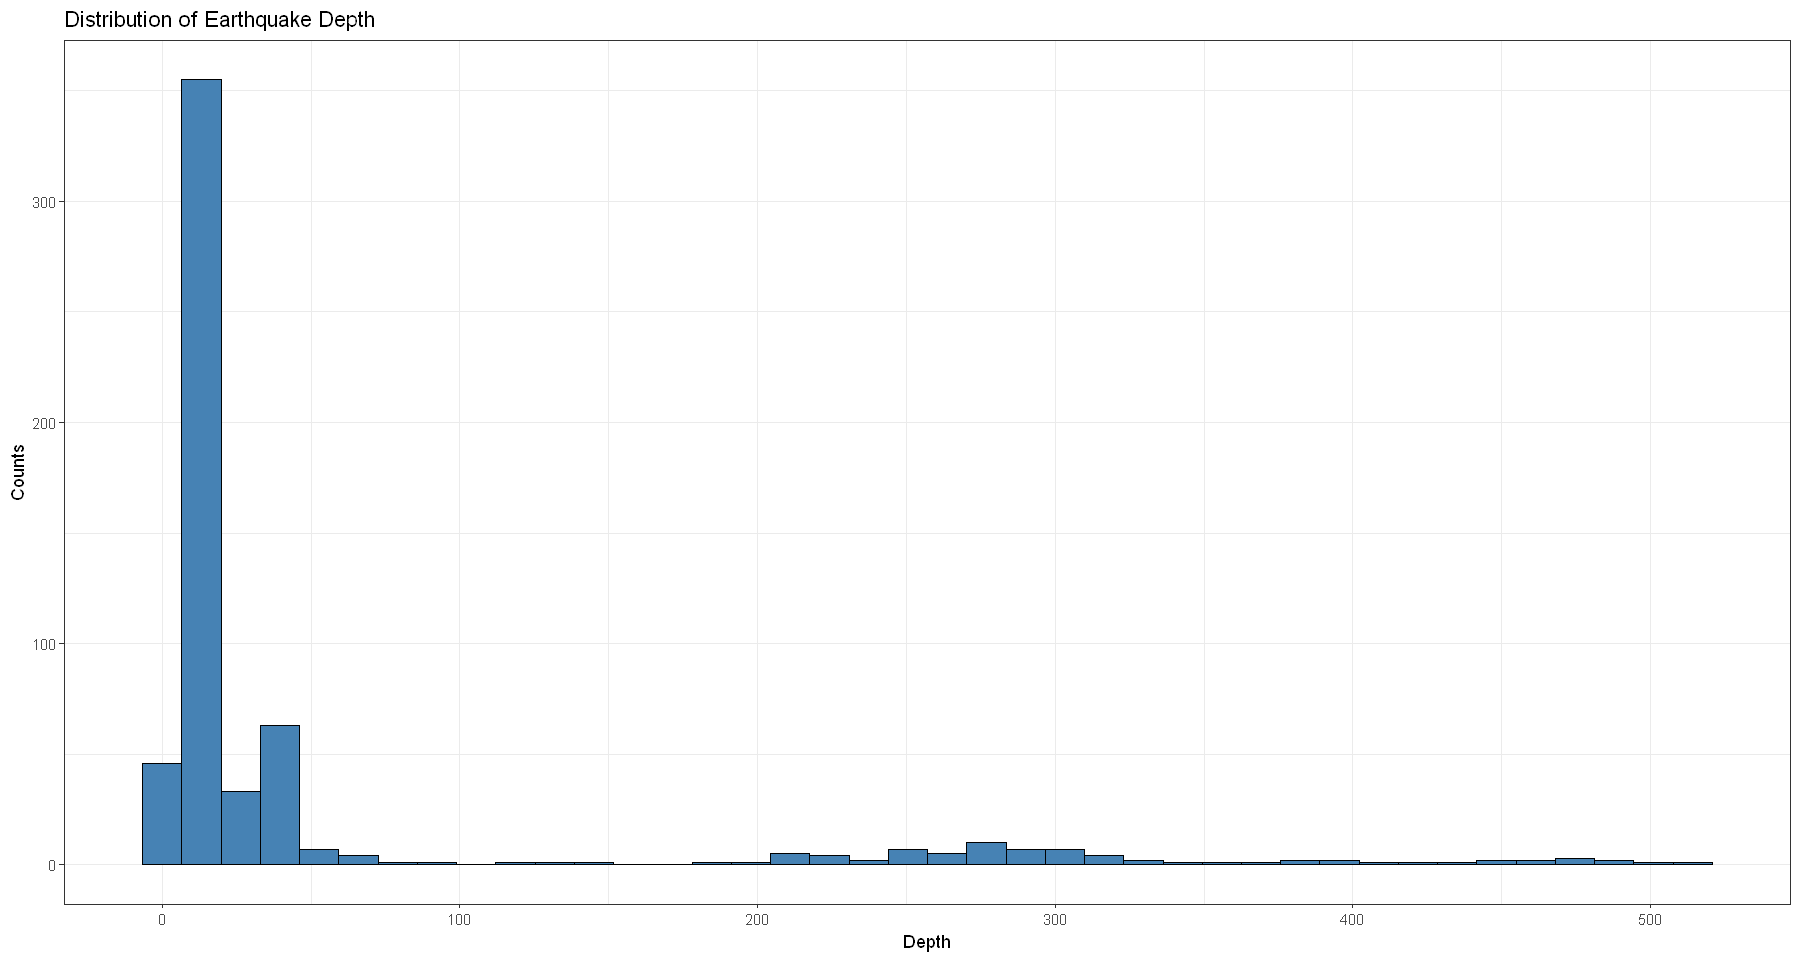

In [7]:
ggplot(df_italia, aes(x = depth)) +
  geom_histogram(, bins = 40, fill = "steelblue", color = "black") +
  labs(title = "Distribution of Earthquake Depth", x = "Depth", y = "Counts") +
  theme_bw()

This graph provides a clear visualization of how earthquake depths are distributed, highlighting the predominance of shallow earthquakes (0-20km) and the relative rarity of deeper events. We will further investigate the deeper events.

<hr style="border:0.01px dashed gray">

Let's investigate correlation between variables

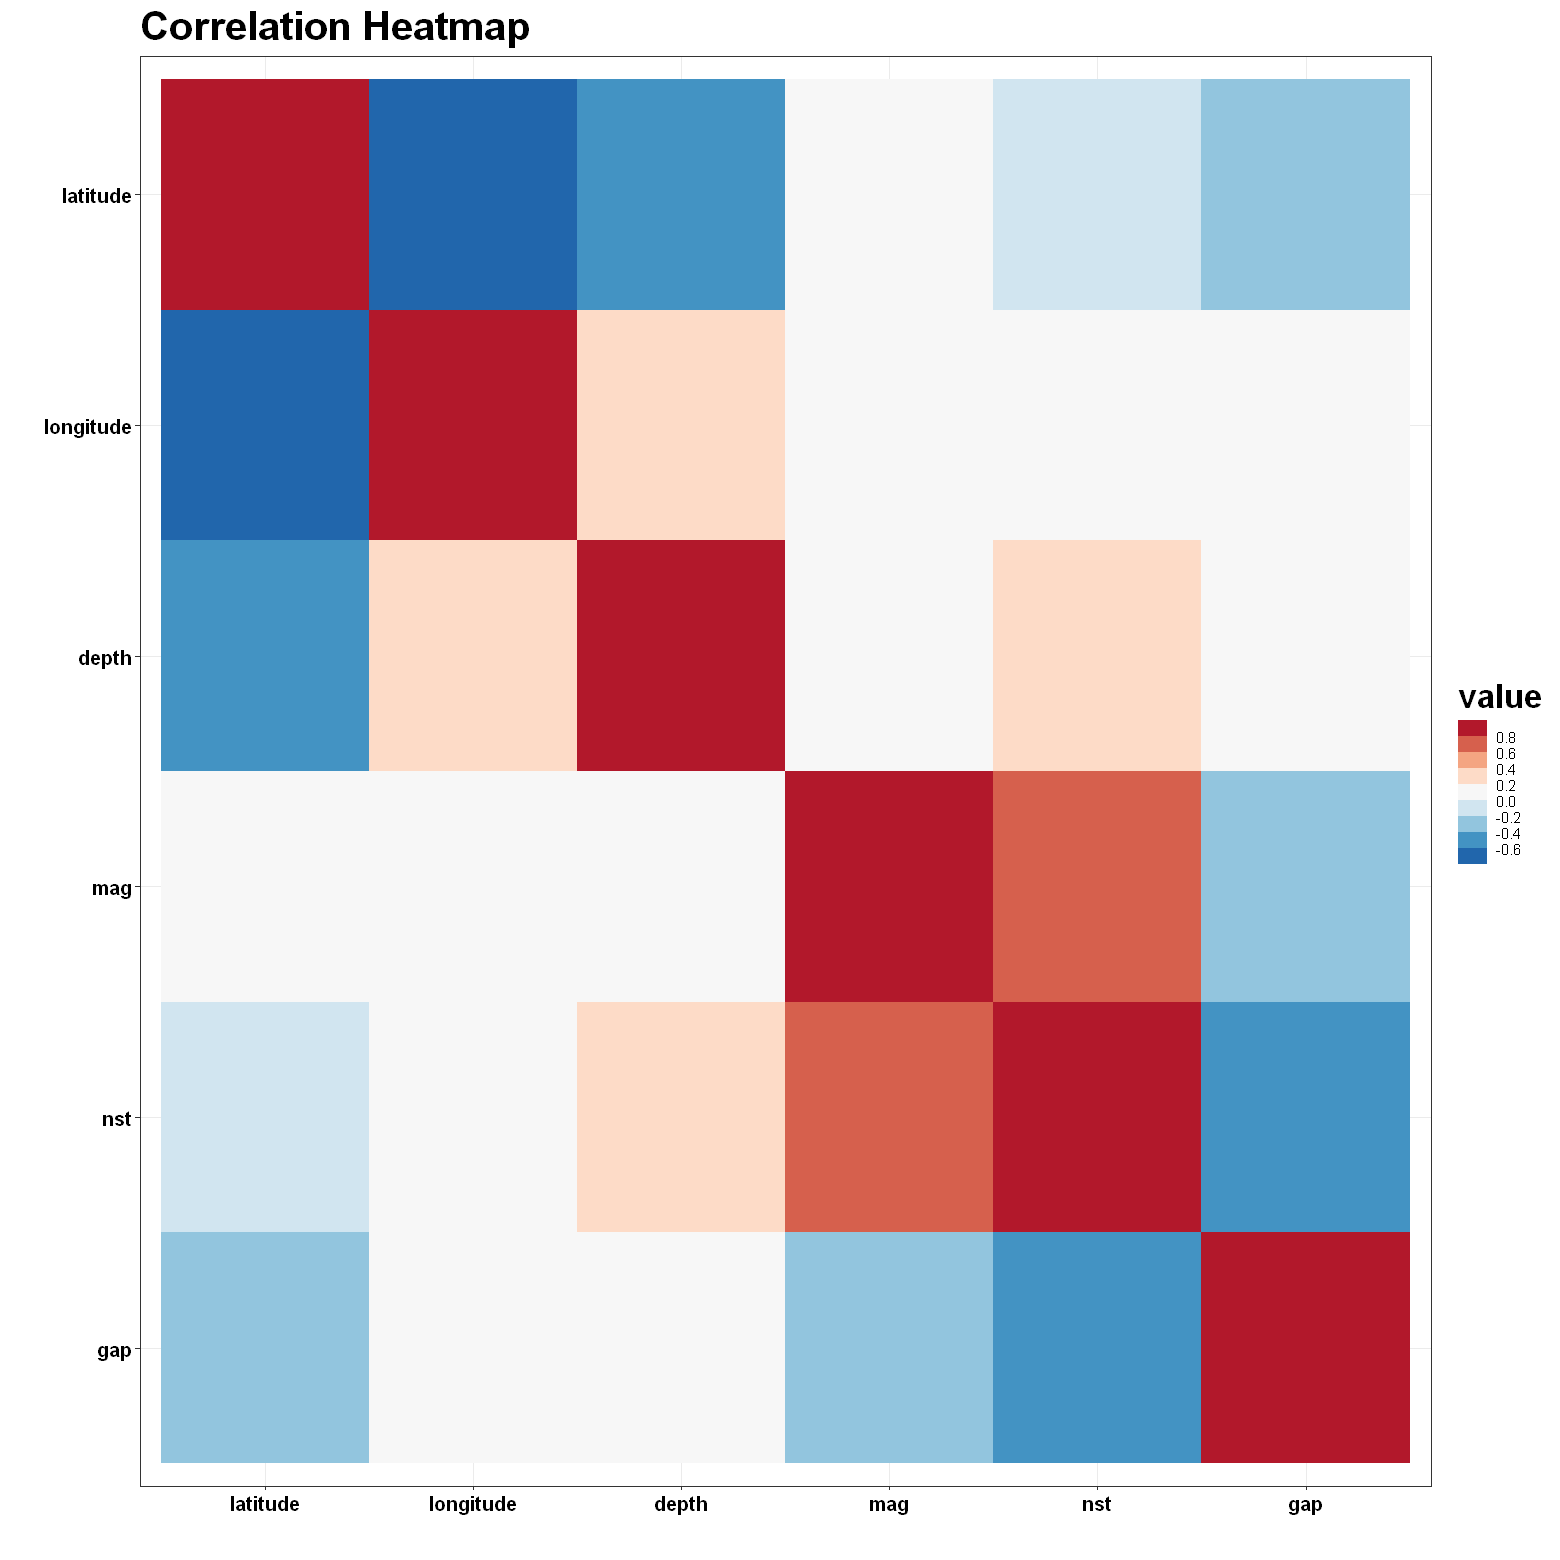

In [8]:
#filter on potentially interesting variables for correlation
df_corr <- subset(df_italia, select = -c(time, place, year))
#compute the correlation matrix
corr <- round(cor(df_corr, use = "na.or.complete"), 2) #not using NA
#from matrix to dataframe for the plot
melted_cormat <- melt(corr)

options(repr.plot.width = 13, repr.plot.height = 13)
ggplot(data = melted_cormat, aes(x = Var1, y = Var2, fill = value)) +
  geom_tile() +
  scale_fill_fermenter(n.breaks = 10, palette = "RdBu") +
  theme_bw() +
  labs(title = "Correlation Heatmap", x = "", y = "") +
  scale_y_discrete(limits = rev) +
  theme(
    axis.text = element_text(color = "black", face = "bold", size = 12),
    title = element_text(color = "black", face = "bold", size = 20)
  )

The correlation heatmap reveals several key relationships in the seismic data. 

There is a notable connection between the magnitude of seismic events and the number of reporting stations, as well as between magnitude and stations' gap. Interestingly, there is no correlation between depth and magnitude. However, depth does correlate with both longitude and latitude.

Obviously, because of the shape and position of Italy we have a strong negative correlation between latitude and longitude.

Just to get an idea of the trend

`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 459 rows containing non-finite outside the scale range
(`stat_smooth()`)."
Warning message:
"Removed 459 rows containing missing values or values outside the scale range
(`geom_point()`)."
`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 494 rows containing non-finite outside the scale range
(`stat_smooth()`)."
Warning message:
"Removed 494 rows containing missing values or values outside the scale range
(`geom_point()`)."


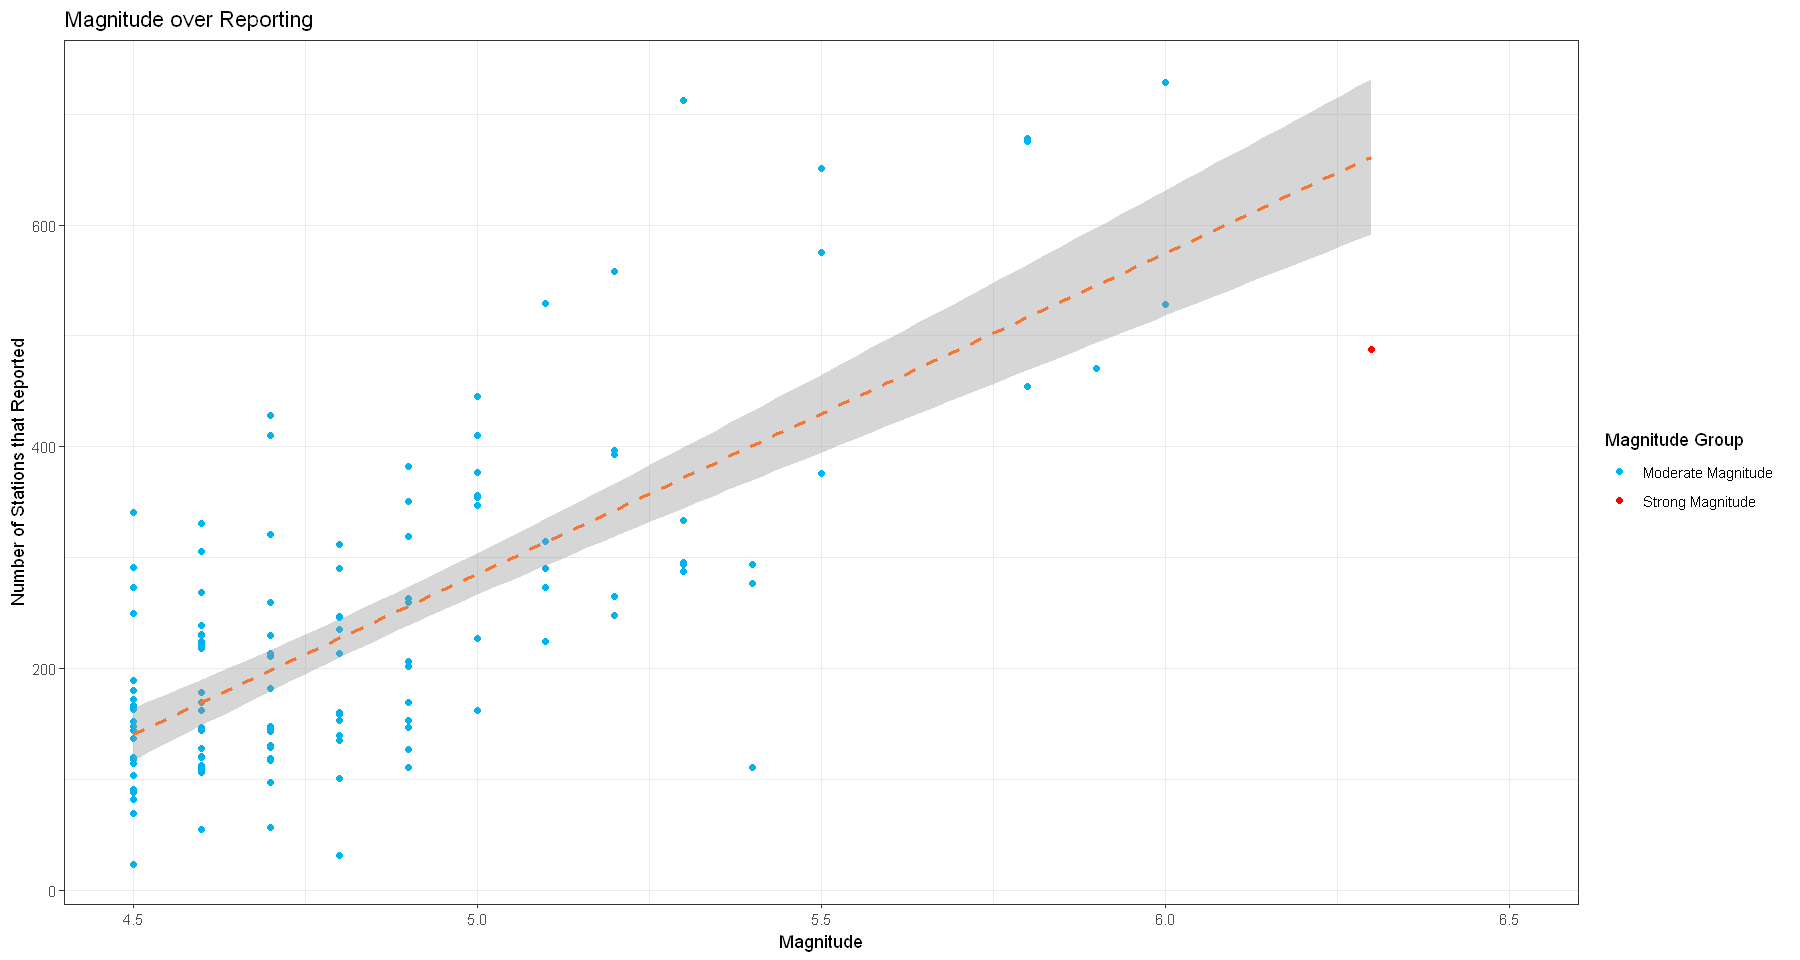

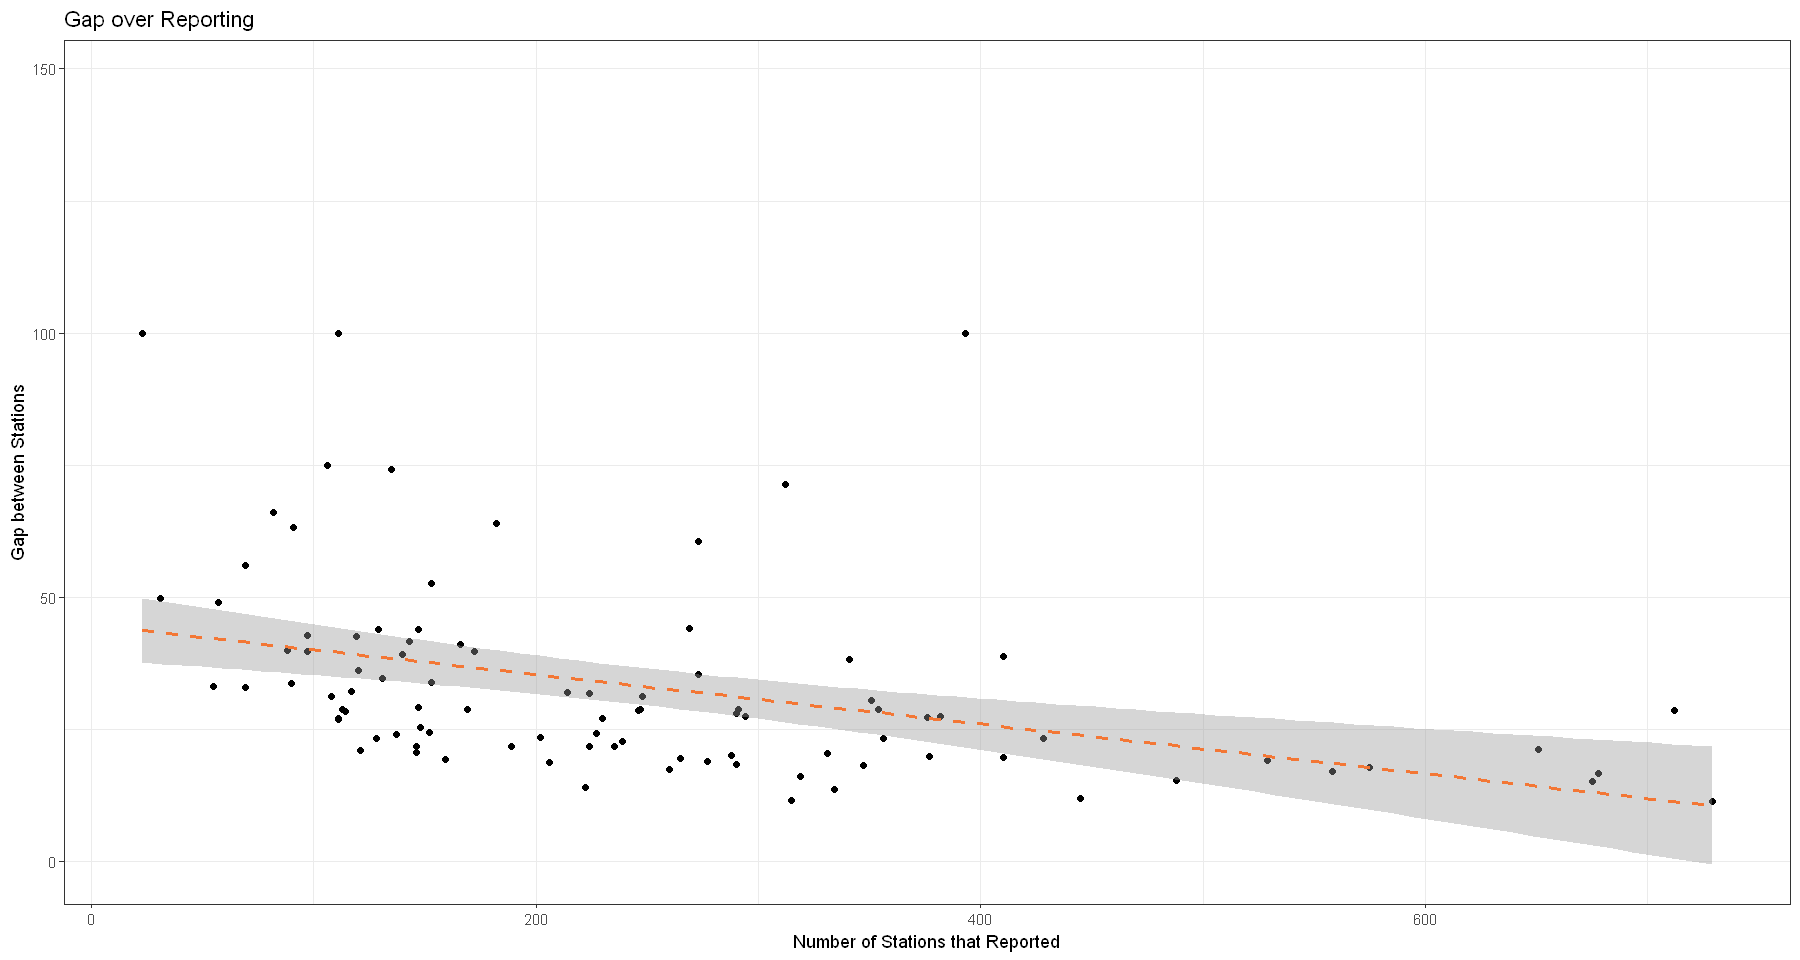

In [9]:
options(repr.plot.width = 15, repr.plot.height = 8)

df_italia$mag_group <- ifelse(df_italia$mag <= 6,
                              "Moderate Magnitude", "Strong Magnitude")

ggplot(df_italia, aes(x = mag, y = nst)) +
  scale_color_manual(values = c("Moderate Magnitude" = "deepskyblue2",
                                "Strong Magnitude" = "red")) +
  geom_point(aes(color = mag_group)) +
  geom_smooth(method = "lm", linetype = "dashed", color = "#f37735") +
  theme_bw() +
  xlim(4.5, 6.5) +
  labs(title = "Magnitude over Reporting",
       x = "Magnitude",
       y = "Number of Stations that Reported",
       color = "Magnitude Group")

ggplot(df_italia, aes(x = nst, y = gap)) +
  geom_point() +
  geom_smooth(method = "lm", linetype = "dashed", color = "#f37735") +
  theme_bw() +
  labs(title = "Gap over Reporting",
       x = "Number of Stations that Reported",
       y = "Gap between Stations")

Higher magnitudes mean more stations are able to report about the earthquake as we would expect.

Overall the Gap vs. Magnitude plot doesn't really show any interesting feature, the correlation with magnitude is probably just a reflection of the anticorrelation between gap and nst.

Focusing on the correlation between depth and latitude/longitude:

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


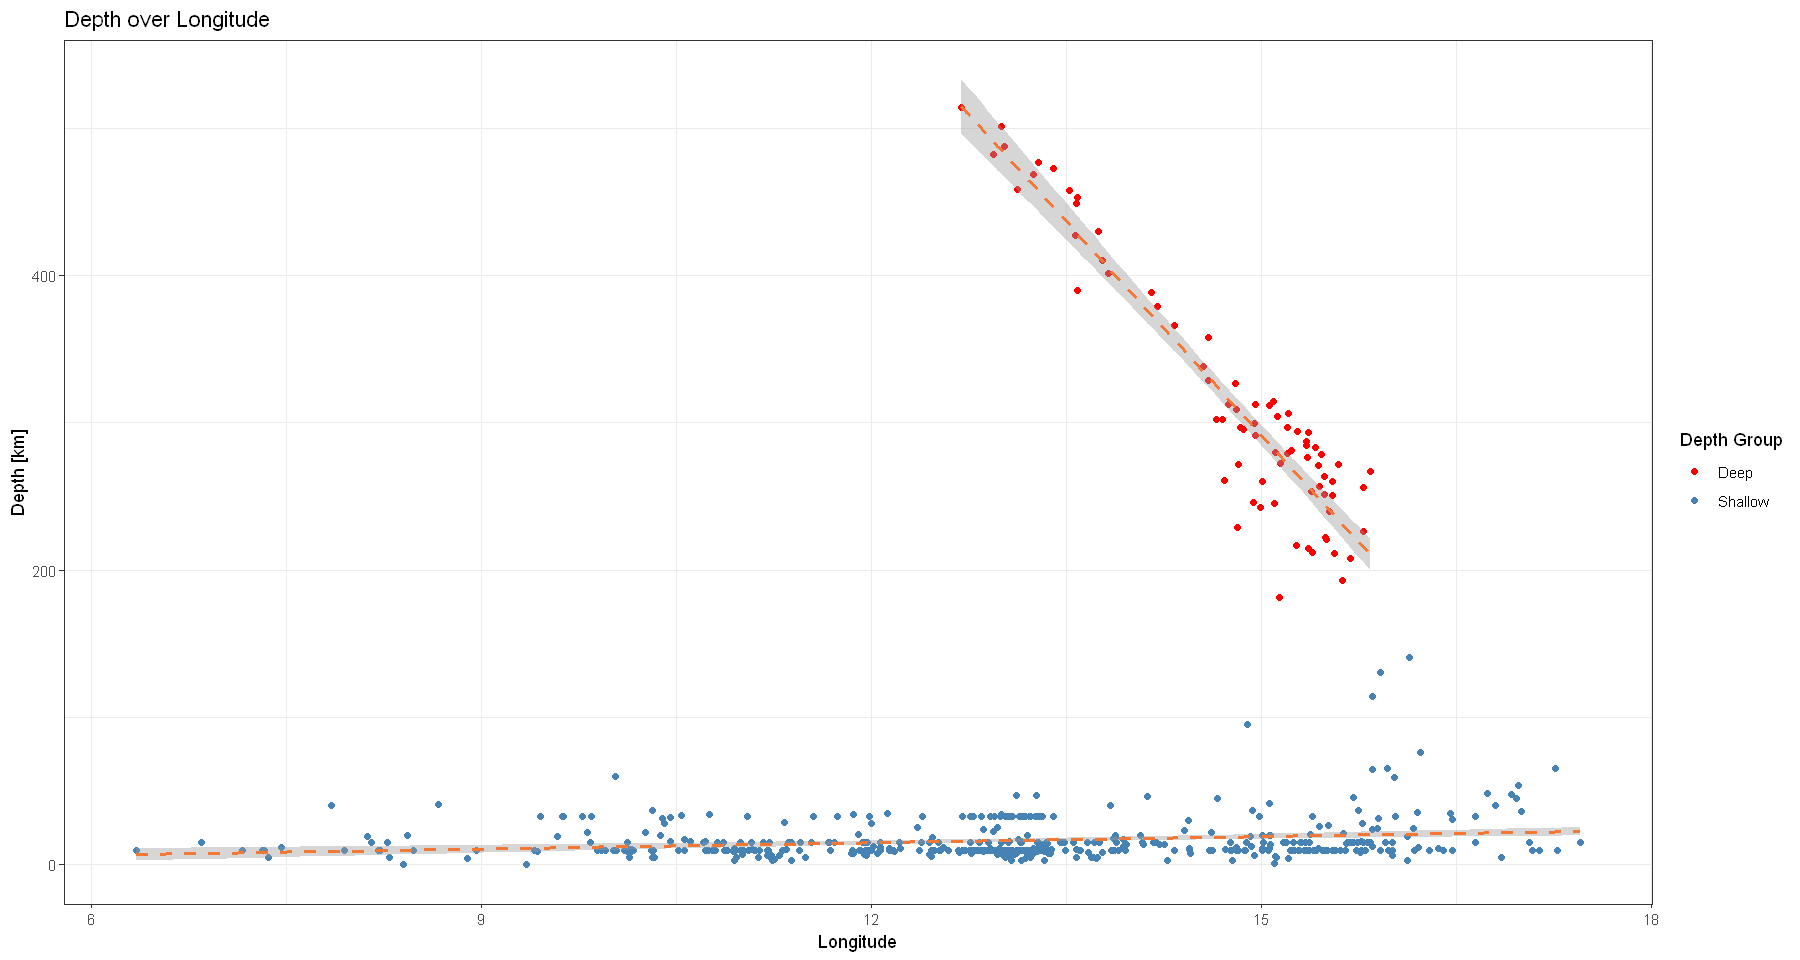

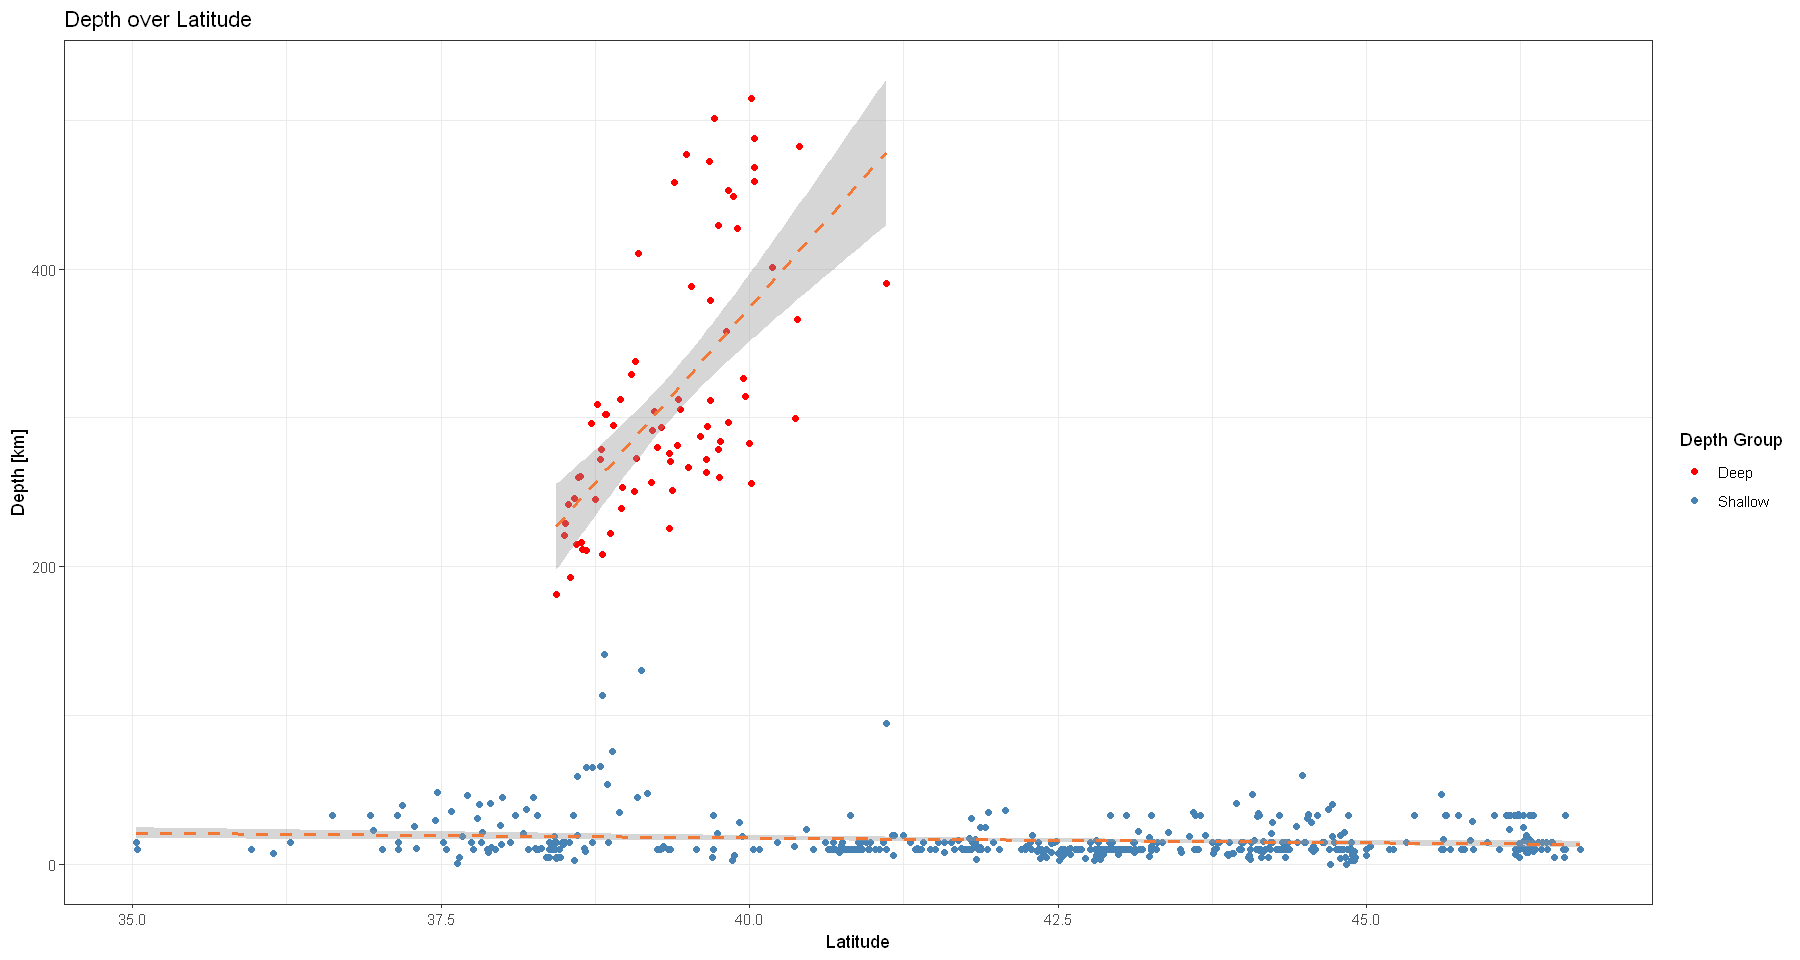

In [10]:
df_italia$depth_group <- ifelse(df_italia$depth < 150, "Shallow", "Deep")

ggplot(df_italia, aes(x = longitude, y = depth, color = depth_group)) +
  geom_point() +
  scale_color_manual(values = c("Shallow" = "steelblue", "Deep" = "red")) +
  theme_bw() +
  labs(title = "Depth over Longitude",
       x = "Longitude",
       y = "Depth [km]",
       color = "Depth Group") +
  geom_smooth(aes(group = depth_group), method = "lm",
              linetype = "dashed", se = TRUE, color = c("#f37735"))

ggplot(df_italia, aes(x = latitude, y = depth, color = depth_group)) +
  geom_point() +
  scale_color_manual(values = c("Shallow" = "steelblue", "Deep" = "red")) +
  theme_bw() +
  labs(title = "Depth over Latitude",
       x = "Latitude",
       y = "Depth [km]",
       color = "Depth Group") +
  geom_smooth(aes(group = depth_group), method = "lm",
              linetype = "dashed", se = TRUE, color = c("#f37735"))

It seems like that, when the earthquake is not superficial (depth over 150 km), there is a linear relationship between longitude/latitude and depth. It means that deep earthquakes happen in a specific region, we'll see this better in the spatial analysis section.

The linear trend observed for deeper earthquakes (in red) strongly suggests the presence of a subduction zone. In a subduction zone, one tectonic plate is being pushed under another. 
The superficial earthquakes (in blue) scatter relatively evenly across the longitudes and latitudes, indicating they are not influenced by the subduction process but rather occur within the Earth's crust, possibly due to different tectonic stresses or faulting processes.

<hr style="border:0.01px dashed gray">

Let's calculate the time differences between consecutive events:

In [11]:
# Calculate the time differences between consecutive events in seconds
time_diffs <- diff(as.numeric(df_italia$time))
average_time_diff_sec <- mean(time_diffs, na.rm = TRUE)
# Convert the average time difference in months
average_time_diff_months <- average_time_diff_sec / (60 * 60 * 24 * 30)

print(paste("The average time between earthquake events is approximately",
            round(average_time_diff_months, 2), "months."))

[1] "The average time between earthquake events is approximately 2.03 months."


Probability that an earthquake of magnitude > 4.5 occurs in the next 10 months:

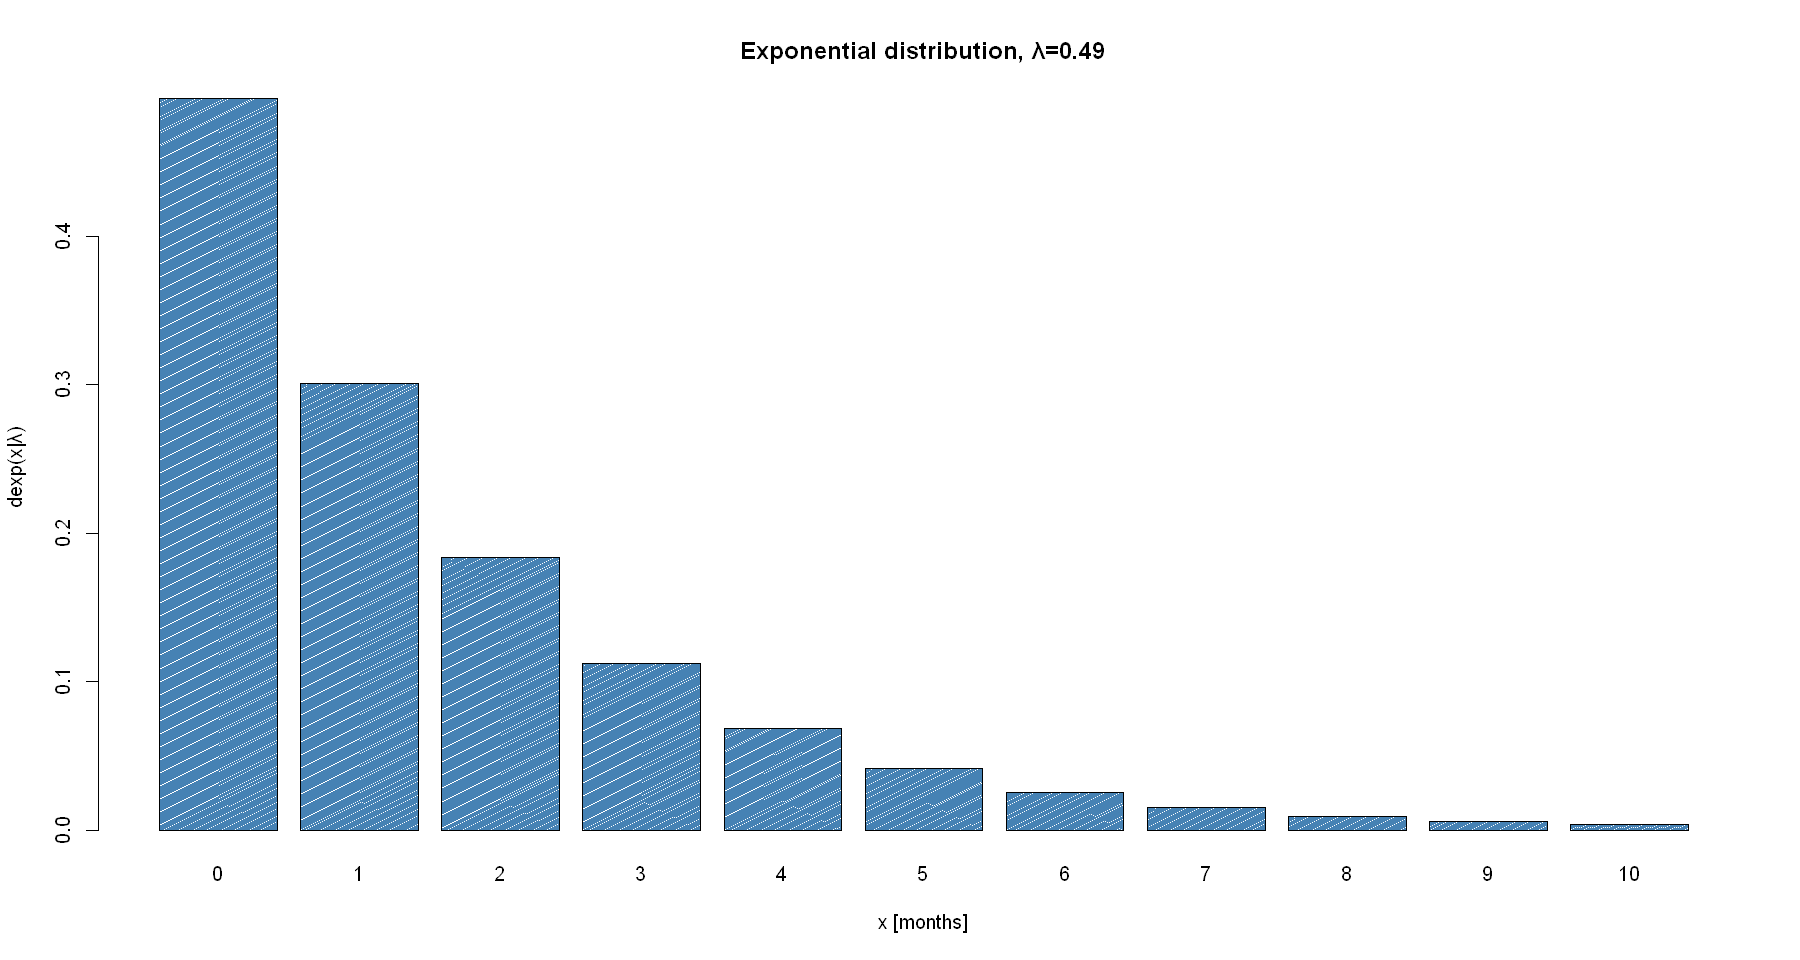

In [12]:
lambda <- 1 / average_time_diff_months
x <- 0:10
ap <- dexp(x, lambda)

barplot(ap, names = x, col = "steelblue", xlab = "x [months]",
        ylab = "dexp(x|λ)", density = 200,
        main = sprintf("Exponential distribution, λ=%.2f", lambda))

### Gutenberg-Richter Law

We want to study the Gutenberg-Richter law of earthquakes which states that the relationship between the magnitude and total number of earthquakes in any given region and time period of at least that magnitude is given by:

$$N = 10^{a+bM} \rightarrow log_{10}N=a+bM$$

where:
- $N$ is the number of events having a magnitude greater or equal to M
- $a$ is the intercept of the linear relationship in the log scale. It represents the total seismic activity rate of a region. A higher value of $a$ indicates a region with more frequent earthquakes.
- $b$  is the slope of the linear relationship in the log scale. It describes the relative likelihood of large and small earthquakes. A lower b-value indicates a higher relative frequency of larger earthquakes.


Call:
lm(formula = log_cumulative_count ~ mag, data = df_cumulative)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.42670 -0.03359 -0.00219  0.03375  0.12161 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.105037   0.029799   238.4   <2e-16 ***
mag         -0.967876   0.006028  -160.6   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.06347 on 587 degrees of freedom
Multiple R-squared:  0.9777,	Adjusted R-squared:  0.9777 
F-statistic: 2.578e+04 on 1 and 587 DF,  p-value: < 2.2e-16


`geom_smooth()` using formula = 'y ~ x'


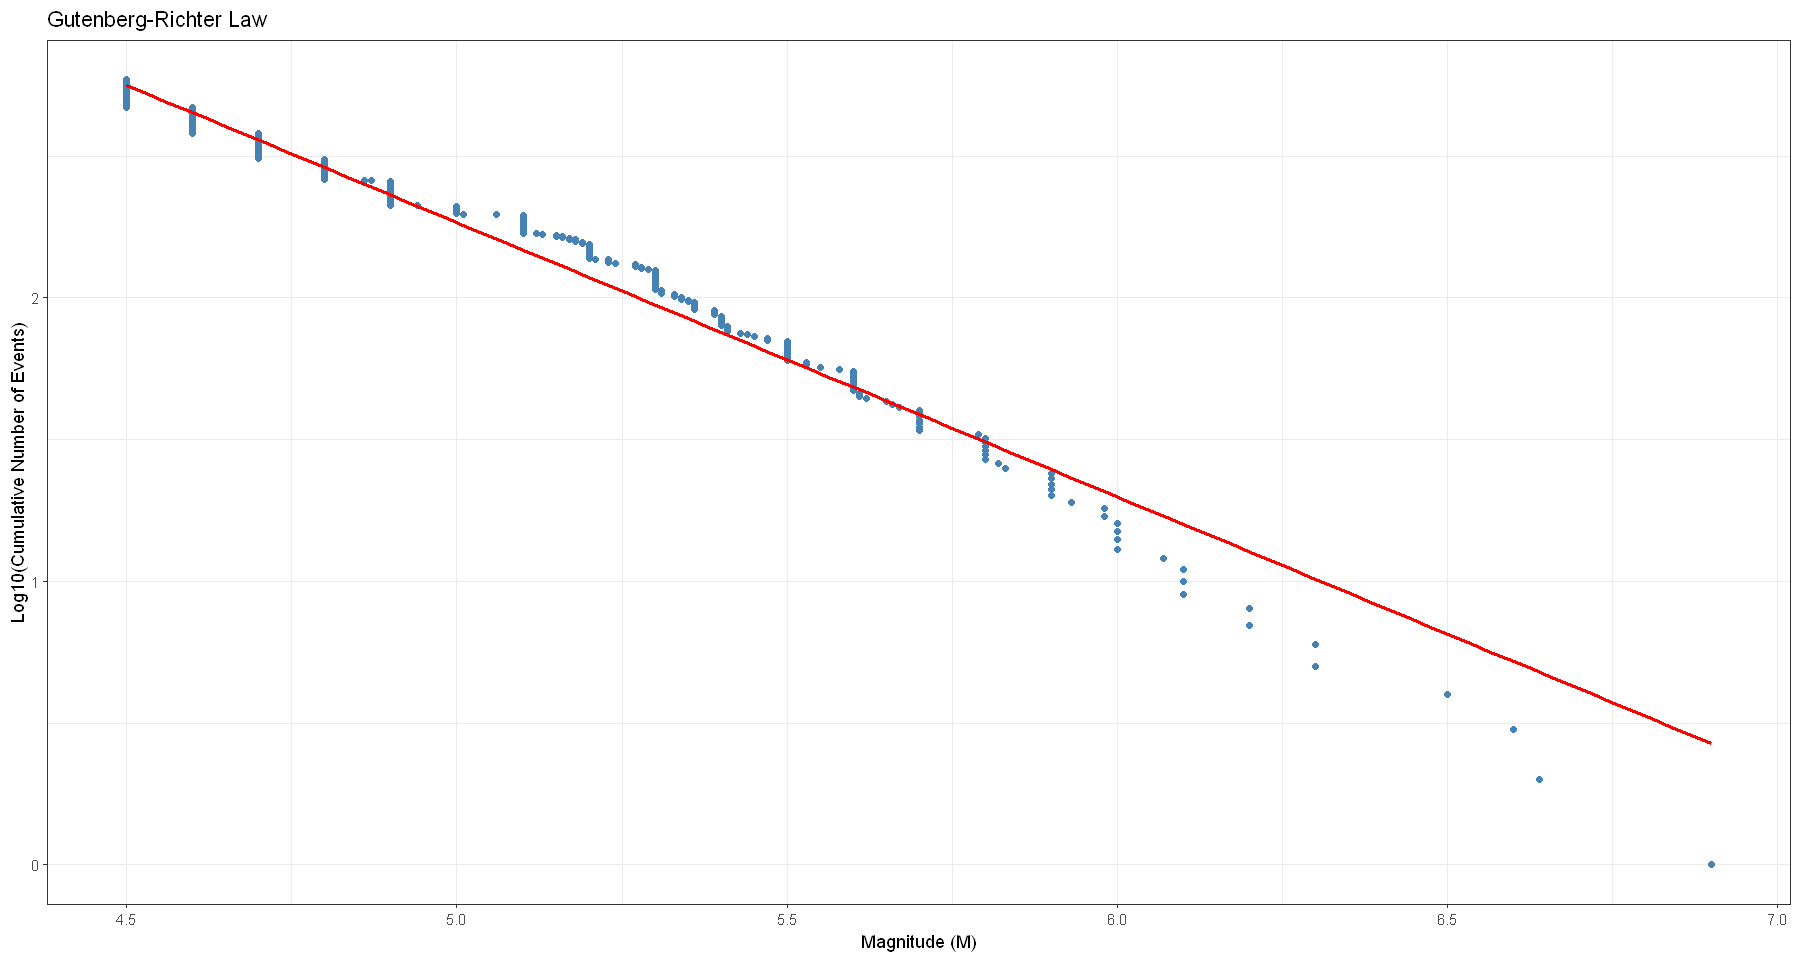

In [13]:
#arrange df by descending mag
df_cumulative <- df_italia[order(df_italia$mag, decreasing = TRUE), ]
#add cumulative count column
df_cumulative$cumulative_count <- seq(1,nrow(df_italia), by = 1)
df_cumulative$log_cumulative_count <- log10(df_cumulative$cumulative_count)

# Linear regression
model <- lm(log_cumulative_count ~ mag, data = df_cumulative)
summary(model)

# Estract parameters
a <- coef(model)["(Intercept)"]
b <- coef(model)["mag"]

options(repr.plot.width = 15, repr.plot.height = 8)
ggplot(df_cumulative, aes(x = mag, y = log_cumulative_count)) +
  geom_point(col = "steelblue") +
  geom_smooth(method = "lm", se = FALSE, color = "red") +
  labs(title = "Gutenberg-Richter Law",
       x = "Magnitude (M)",
       y = "Log10(Cumulative Number of Events)") +
  theme_bw()


In [14]:
cat("The parameters of the linear regression are\na:", a, "\nb:", b)

The parameters of the linear regression are
a: 7.105037 
b: -0.9678755

### Yearly Distribution 

In [15]:
# Group earthquakes by year
earthquakes_per_year <- df_italia %>%
  group_by(year) %>%
  summarize(count = n(), mean_mag = mean(mag), max_mag = max(mag),
            min_mag = min(mag), depth = mean(depth, na.rm = TRUE))

all_years <- data.frame(year = seq(min(df_italia$year), max(df_italia$year)))

#add years with zero earthquakes
e_per_year <- earthquakes_per_year
e_per_year$year <- as.integer(e_per_year$year)
e_per_year <- left_join(all_years, e_per_year, by = "year") %>%
  replace_na(list(count = 0, mean_mag = NA, max_mag = NA,
                  min_mag = NA, depth = NA))

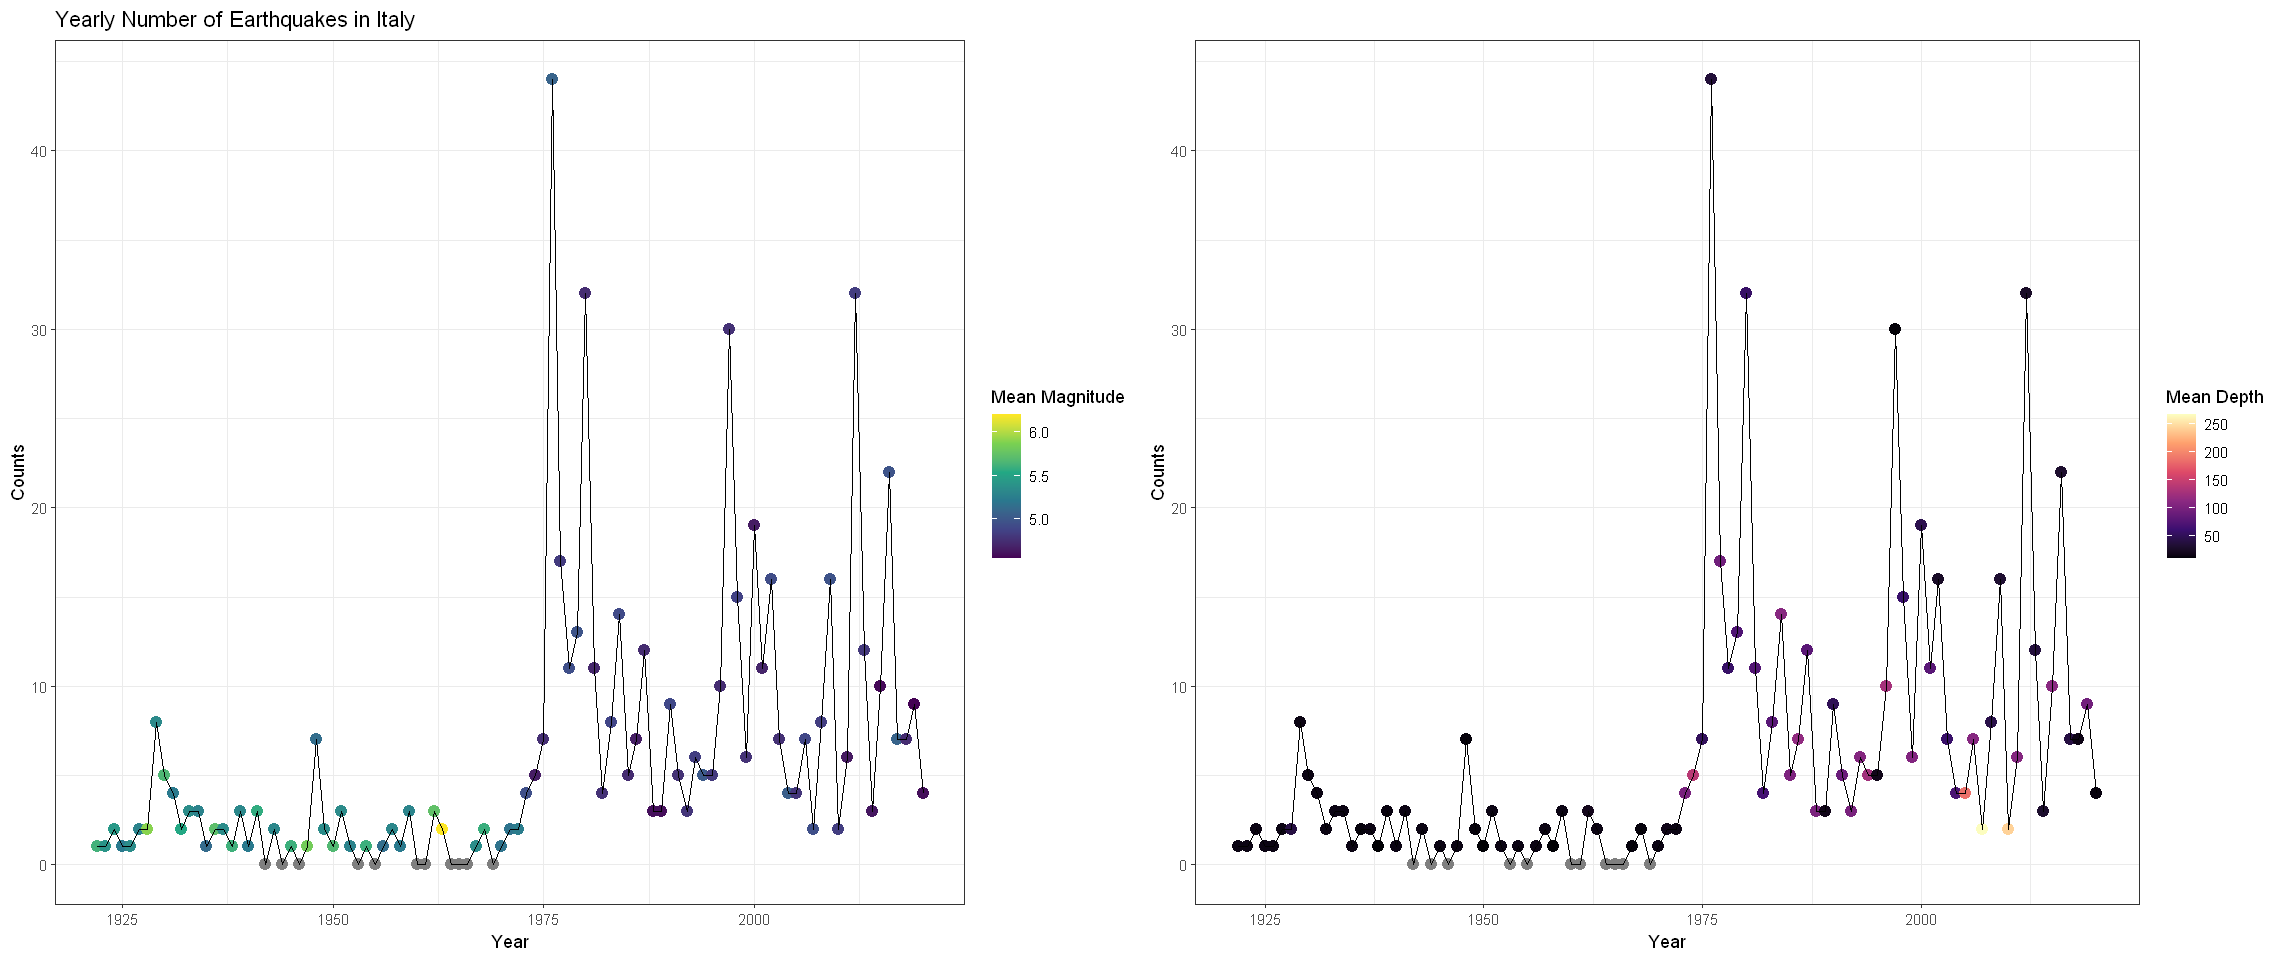

In [16]:
options(repr.plot.width = 15, repr.plot.height = 8)
magnitude <- ggplot(e_per_year, aes(x = as.integer(year), y = count)) +
  geom_point(aes(col = mean_mag), size = 3) +
  geom_line() +
  scale_color_viridis_c(name = "Mean Magnitude") +
  labs(title = "Yearly Number of Earthquakes in Italy",
       x = "Year",
       y = "Counts") +
  theme_bw()

depth <- ggplot(e_per_year, aes(x = as.integer(year), y = count)) +
  geom_point(aes(col = depth), size = 3) +
  geom_line() +
  scale_color_viridis_c(option = "magma", name = "Mean Depth") +
  labs(title = "", x = "Year", y = "Counts") +
  theme_bw()


options(repr.plot.width = 19, repr.plot.height = 8)
grid.arrange(magnitude, depth, ncol = 2)

We can observe a noticeable change in both the average magnitude and average depth of earthquakes as the number of occurrences increases.

## Time Series

A time series is a sequence taken at successive equally spaced points in time. It will become clear that earthquake events do not fit very well with the definition of a time series, since they are extremely irregular in time.

Firstly, we need to define a time series based on the annual counts of earthquakes.

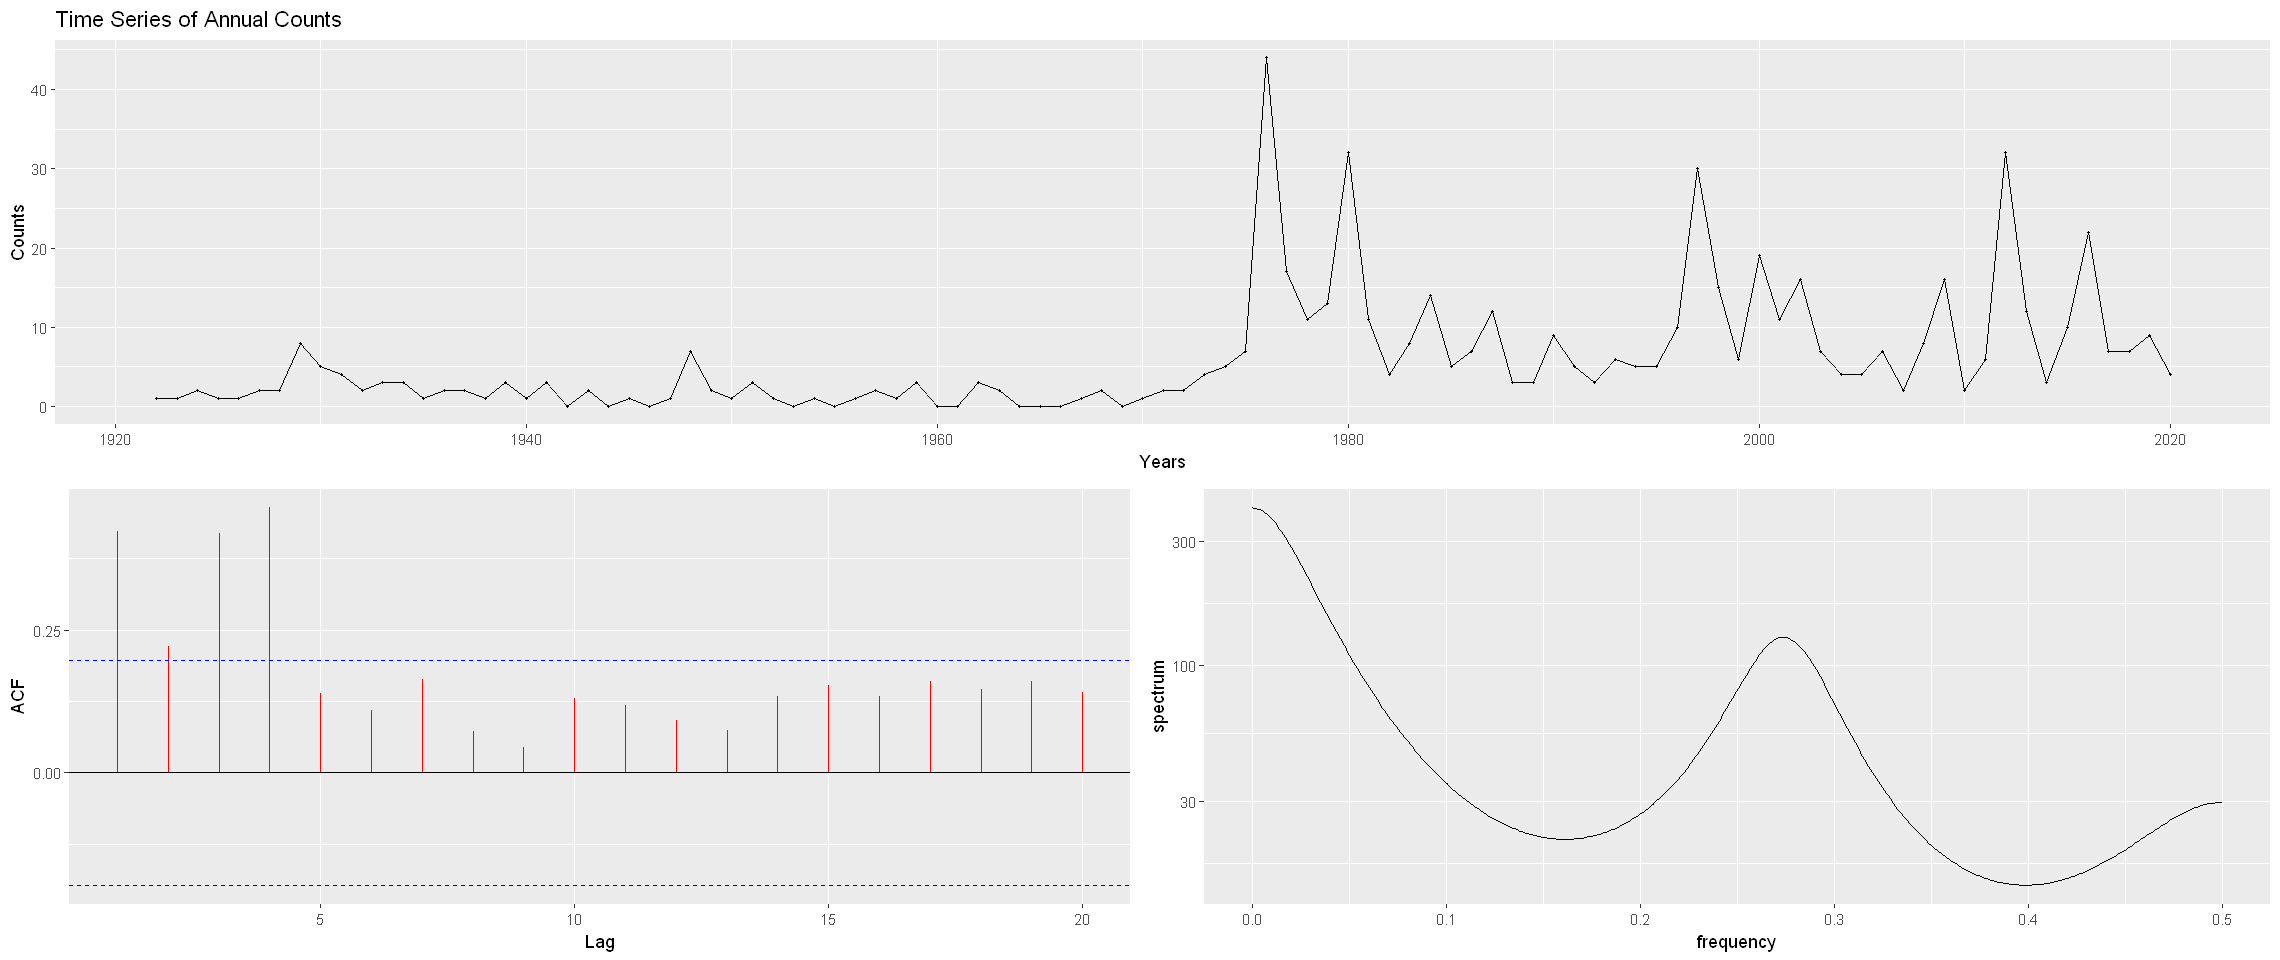

In [17]:
earthquake_ts <- ts(e_per_year$count,
                    start = min(e_per_year$year),
                    end = max(e_per_year$year),
                    frequency = 1)

ggtsdisplay(earthquake_ts, plot.type = "spectrum",
            xlab = "Years",
            ylab = "Counts",
            col = "red",
            main = "Time Series of Annual Counts")

The spectrum of a time series is a representation of the distribution of the variance across different frequencies. It provides insights into the periodic components of the time series by indicating how the variance is distributed over various frequency components.

We see a strong autocorrelation at 3/4 years and a spectrum with a peak at frequency ~0.27. Higher values at certain frequencies suggest dominant periodic components at those frequencies.

### Forecast

Looking also at the "future" data from 2021 to 2023

In [18]:
df_future <- read.csv("from_2021.csv")
df_italia_future <- df_future[grepl("Italy", df_future$place,
                                    ignore.case = TRUE), ]
df_italia_future <- data.frame(df_italia_future, row.names = NULL)
df_italia_future$time <- as.POSIXct(df_italia_future$time,
                                    format = "%Y-%m-%dT%H:%M:%OSZ", tz = "UTC")
df_italia_future$year <- as.numeric(format(df_italia_future$time, "%Y"))

earthquakes_per_year_future <- df_italia_future %>%
  group_by(year) %>%
  summarize(count = n(), mean_mag = mean(mag), max_mag = max(mag),
            min_mag = min(mag), depth = mean(depth, na.rm = TRUE))

earthquakes_per_year_future

year,count,mean_mag,max_mag,min_mag,depth
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
2021,5,4.780000,5.5,4.5,55.61800
2022,7,4.828571,5.6,4.5,50.10986
2023,7,4.728571,5.2,4.5,158.77729


We want to perform a forecast on future earthquake counts.

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


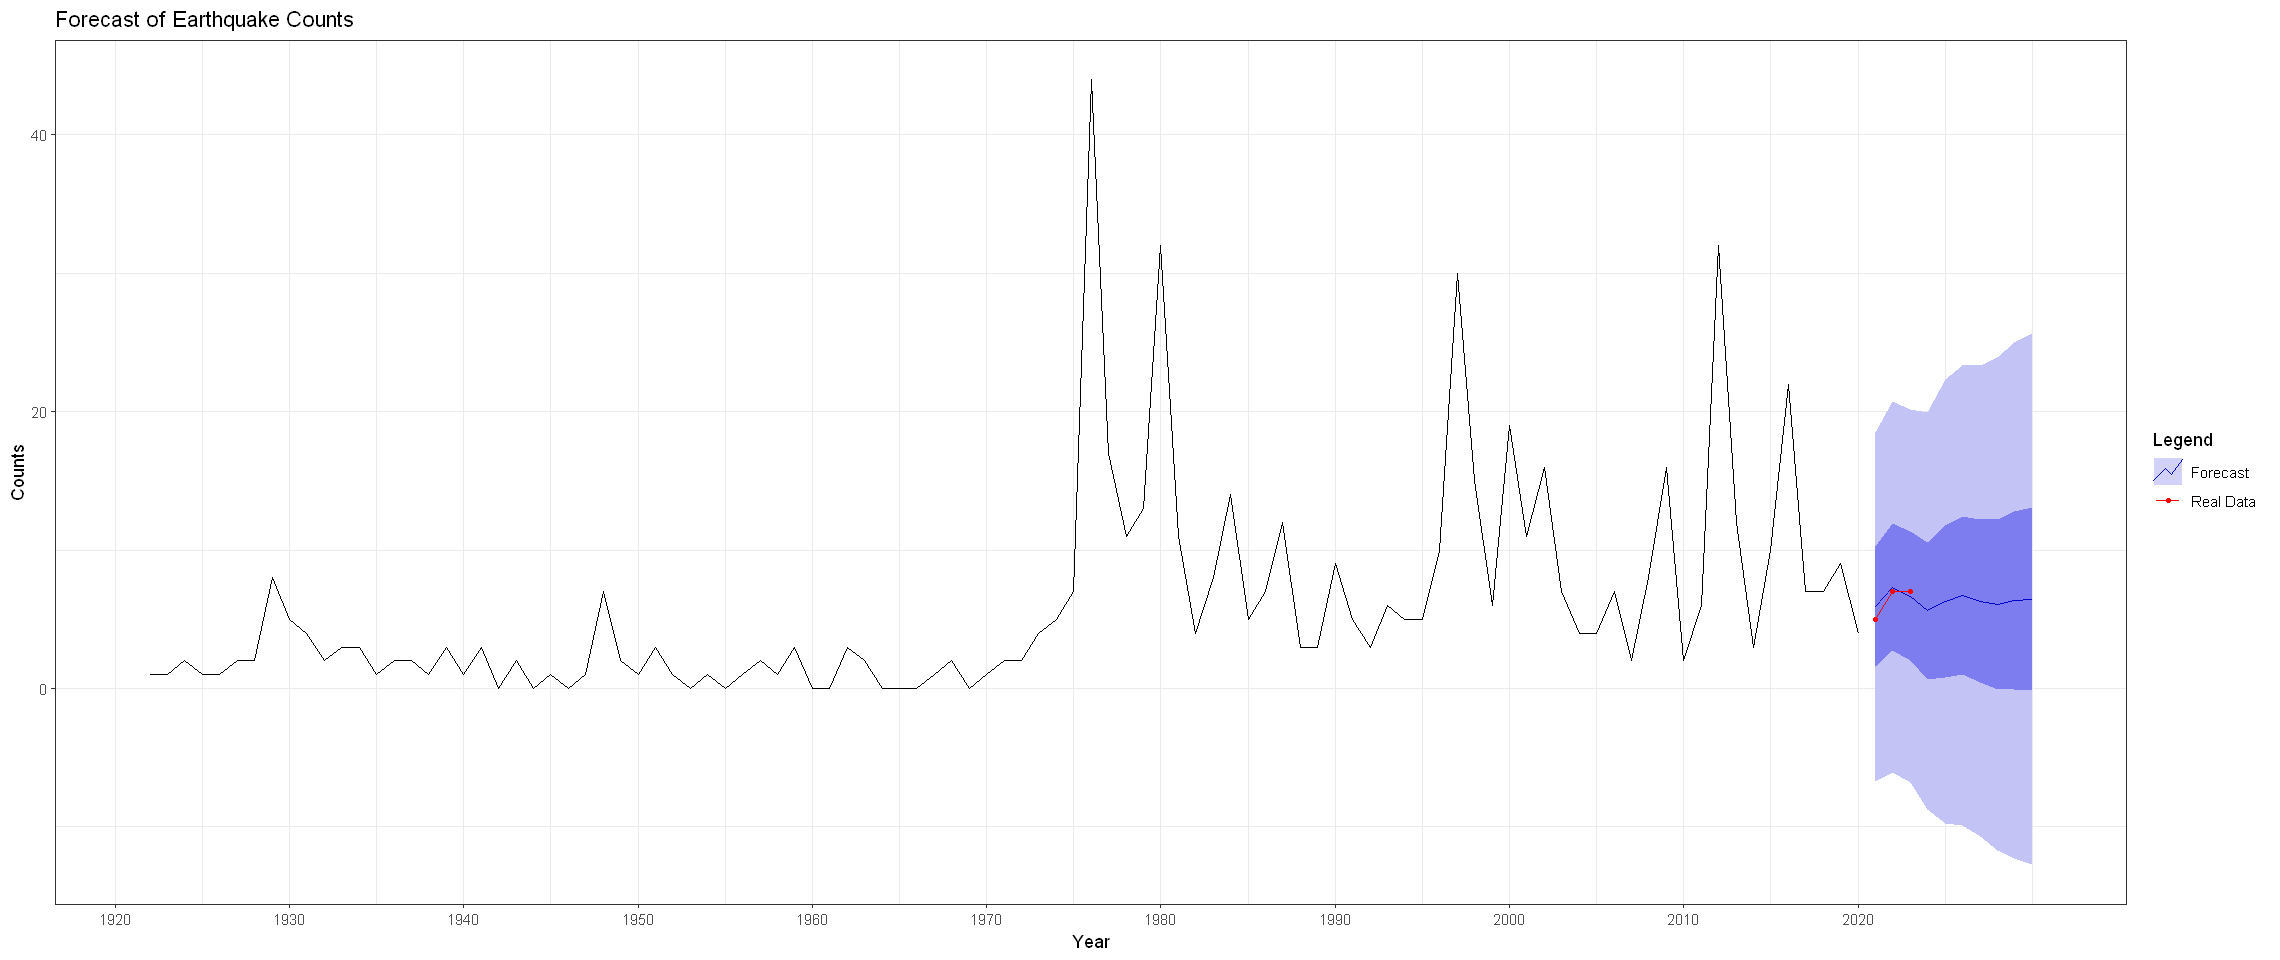

In [19]:
# fitting a time series model to the data
fit <- auto.arima(earthquake_ts, seasonal = FALSE)
# forecast for 10 years
forecasted <- forecast(fit, h = 10, level = c(50, 95))

autoplot(forecasted, series = "Time Series") +
  autolayer(forecasted, series = "Forecast") +
  geom_point(data = earthquakes_per_year_future,
             aes(x = year, y = count, color = "Real Data"), size = 1) +
  geom_line(data = earthquakes_per_year_future,
            aes(x = year, y = count, color = "Real Data")) +
  scale_color_manual(values = c("Time Series" = "black",
                                "Forecast" = "blue", "Real Data" = "red")) +
  labs(title = "Forecast of Earthquake Counts",
       x = "Year",
       y = "Counts",
       color = "Legend") +
  scale_x_continuous(breaks = seq(1920, 2020, by = 10)) +
  theme_bw()

It seems to fit the future data quite nicely.

#### Evaluate the forecast

We want to evaluate the forecast by splitting the time series data into training and testing sets.

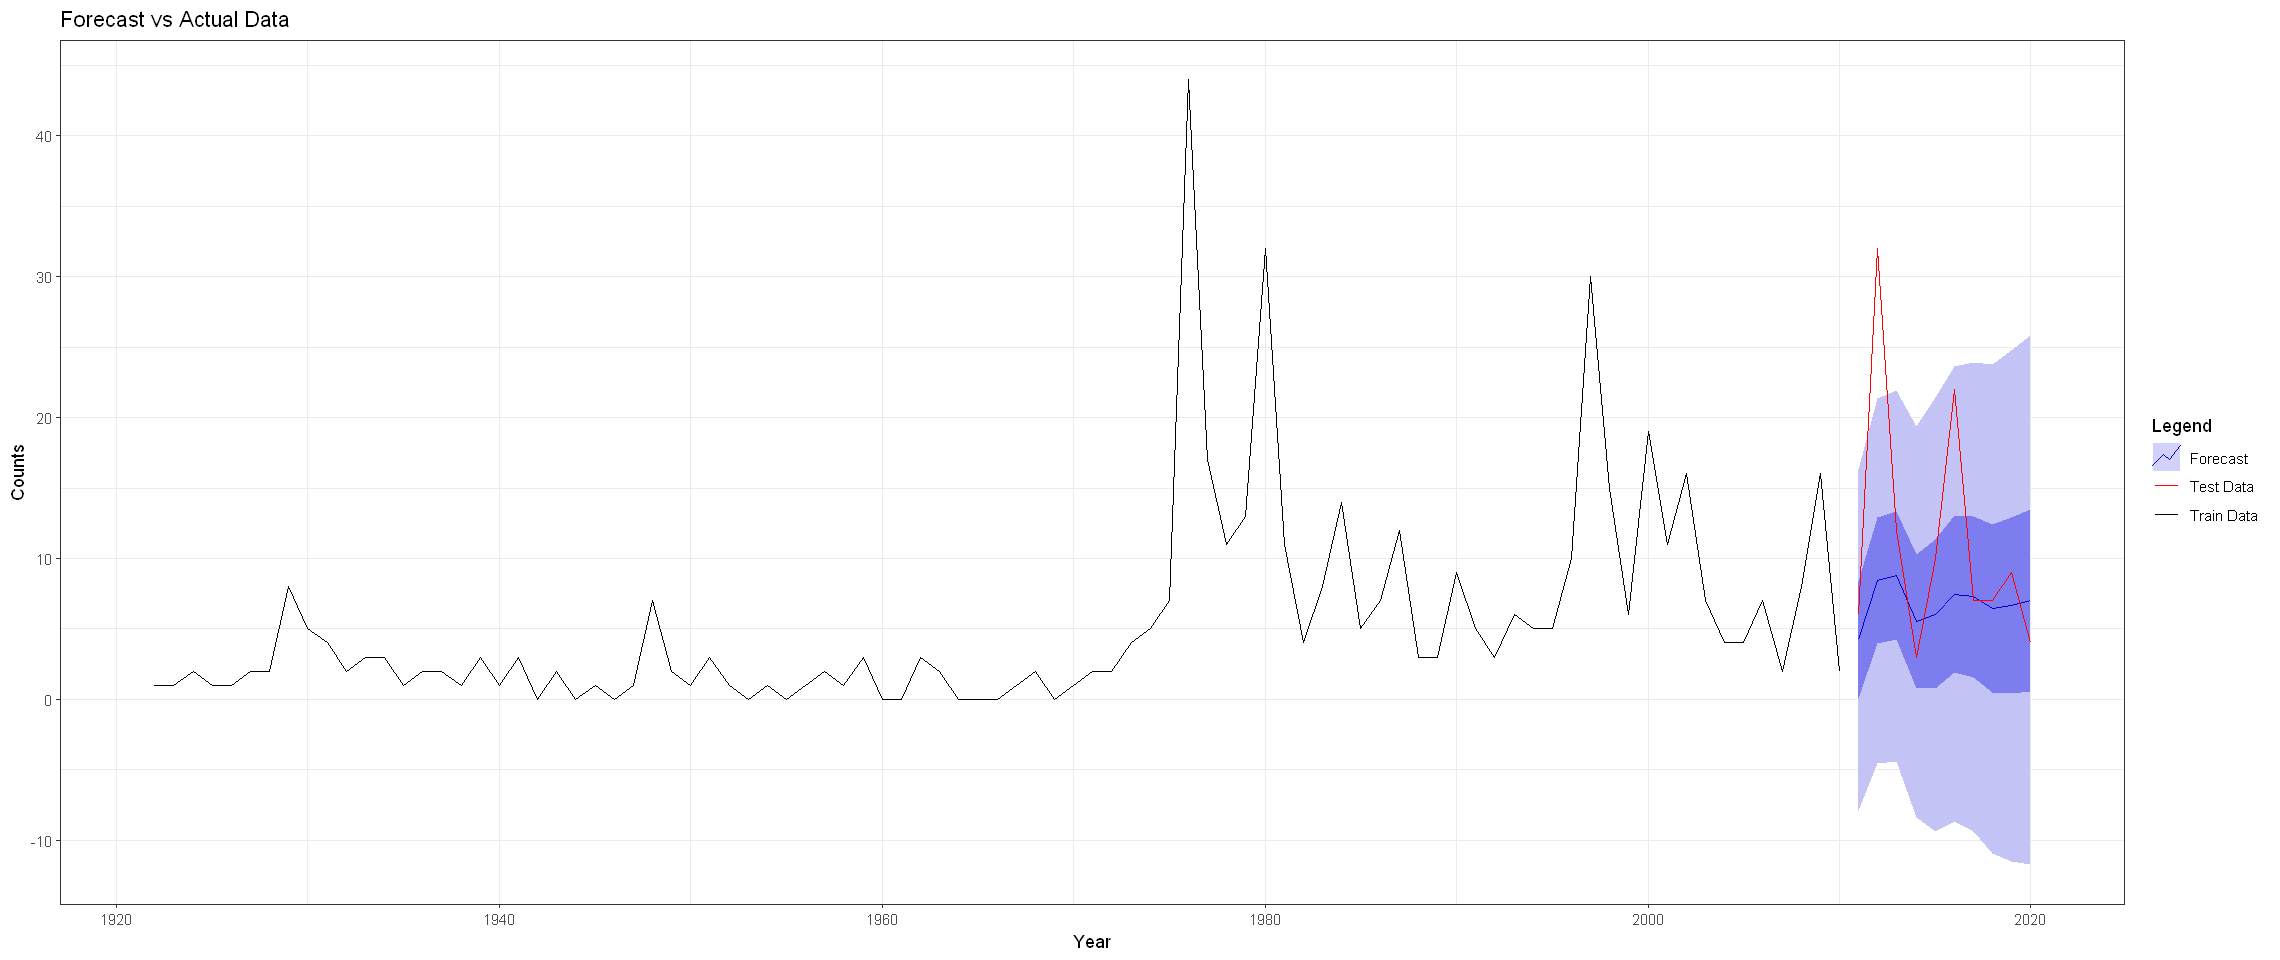

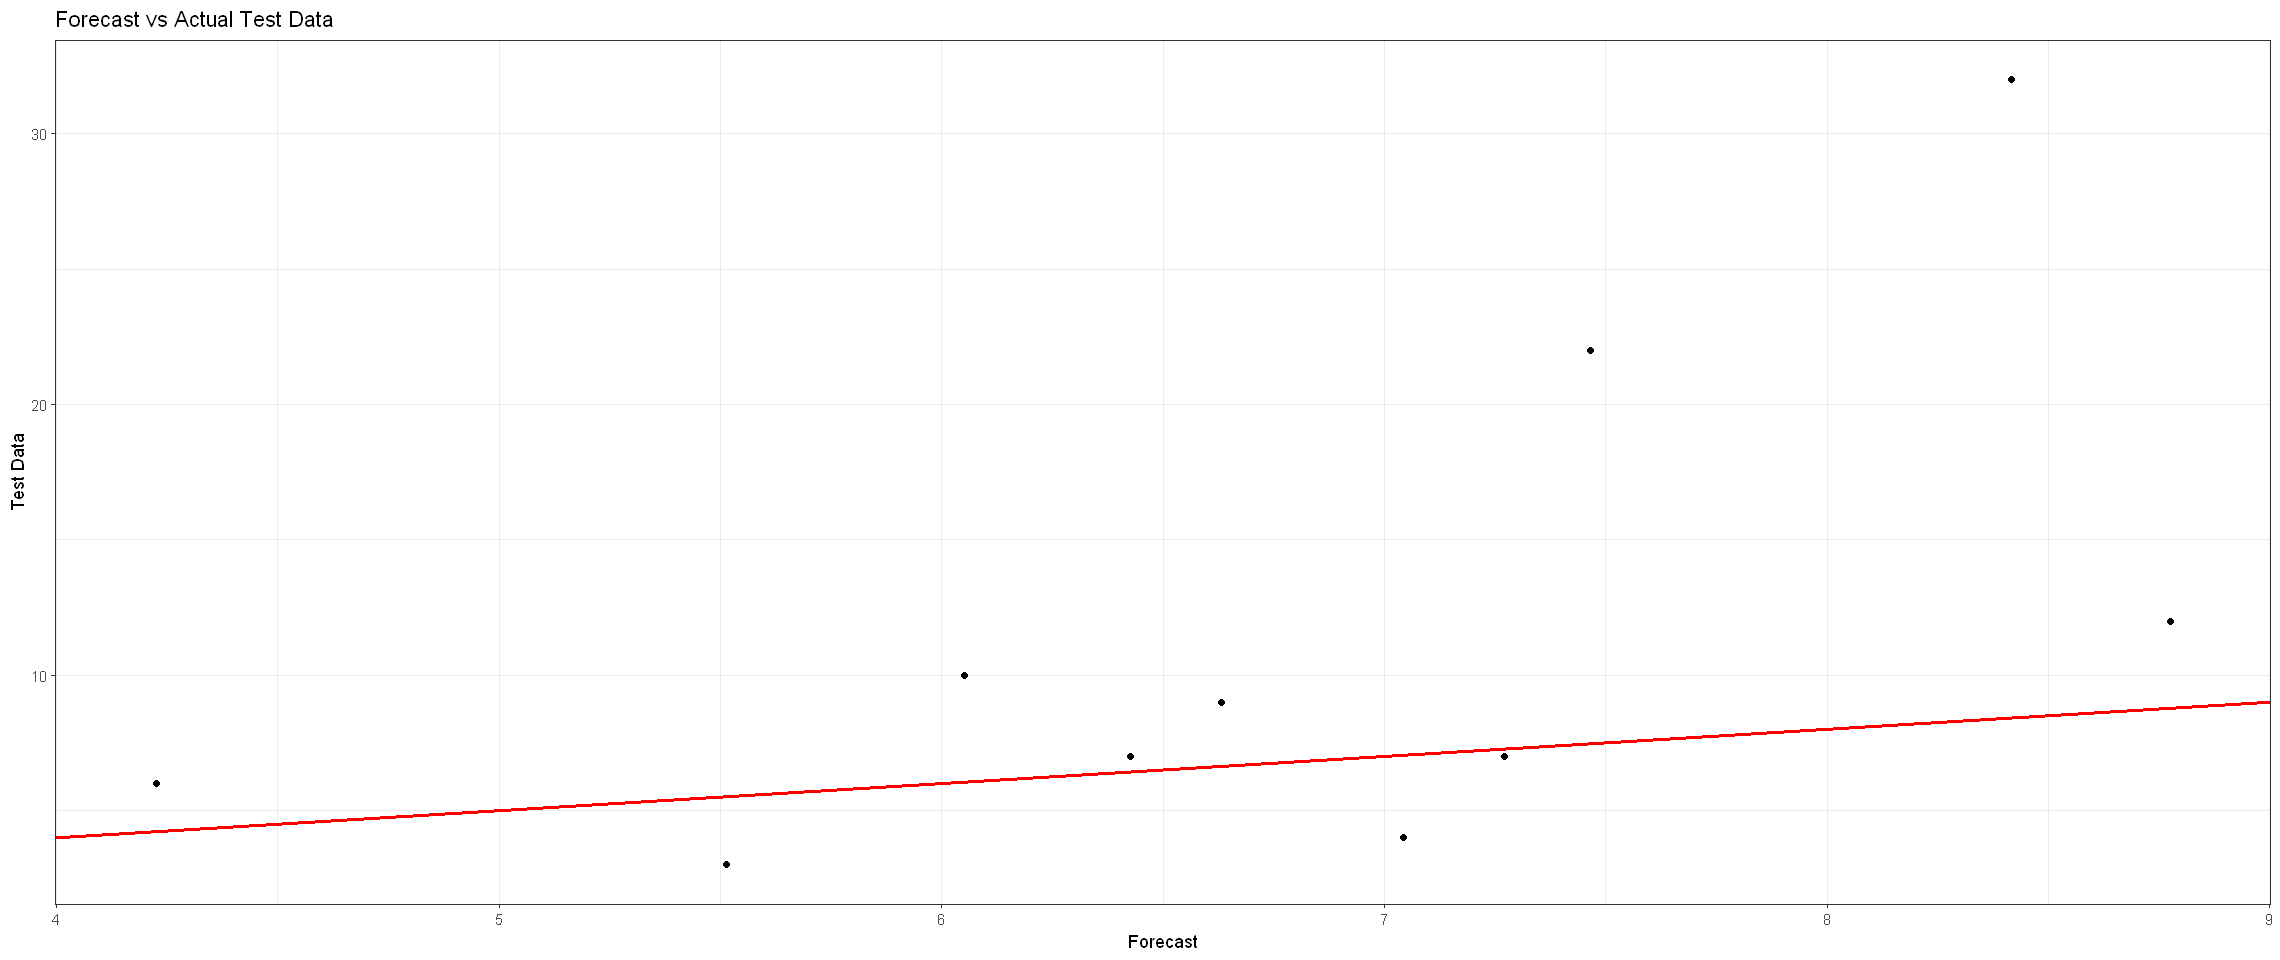

In [20]:
ts_train <- window(earthquake_ts, end = c(2010))
ts_test <- window(earthquake_ts, start = c(2011))

arima_model <- auto.arima(ts_train)
fc <- forecast(arima_model, h = 10, level = c(50, 95))

par(lwd = 3)
autoplot(ts_train, series = "Train Data") +
  autolayer(fc, series = "Forecast") +
  autolayer(ts_test, series = "Test Data") +
  scale_color_manual(values = c("Train Data" = "black",
                                "Forecast" = "blue", "Test Data" = "red")) +
  labs(title = "Forecast vs Actual Data",
       x = "Year",
       y = "Counts",
       color = "Legend") +
  theme_bw()

ggplot() +
  geom_point(aes(as.vector(fc$mean),  as.vector(ts_test)), col = "black") +
  geom_abline(intercept = 0, slope = 1, color = "red", lwd = 1) +
  labs(title = "Forecast vs Actual Test Data",
       y = "Test Data",
       x = "Forecast") +
  theme_bw()

The scatter plot helps to visually assess the accuracy of the forecast by showing how closely the points align with the diagonal line. Aside from two peaks, the forecast appears to be quite accurate.

## Magnitude Analysis

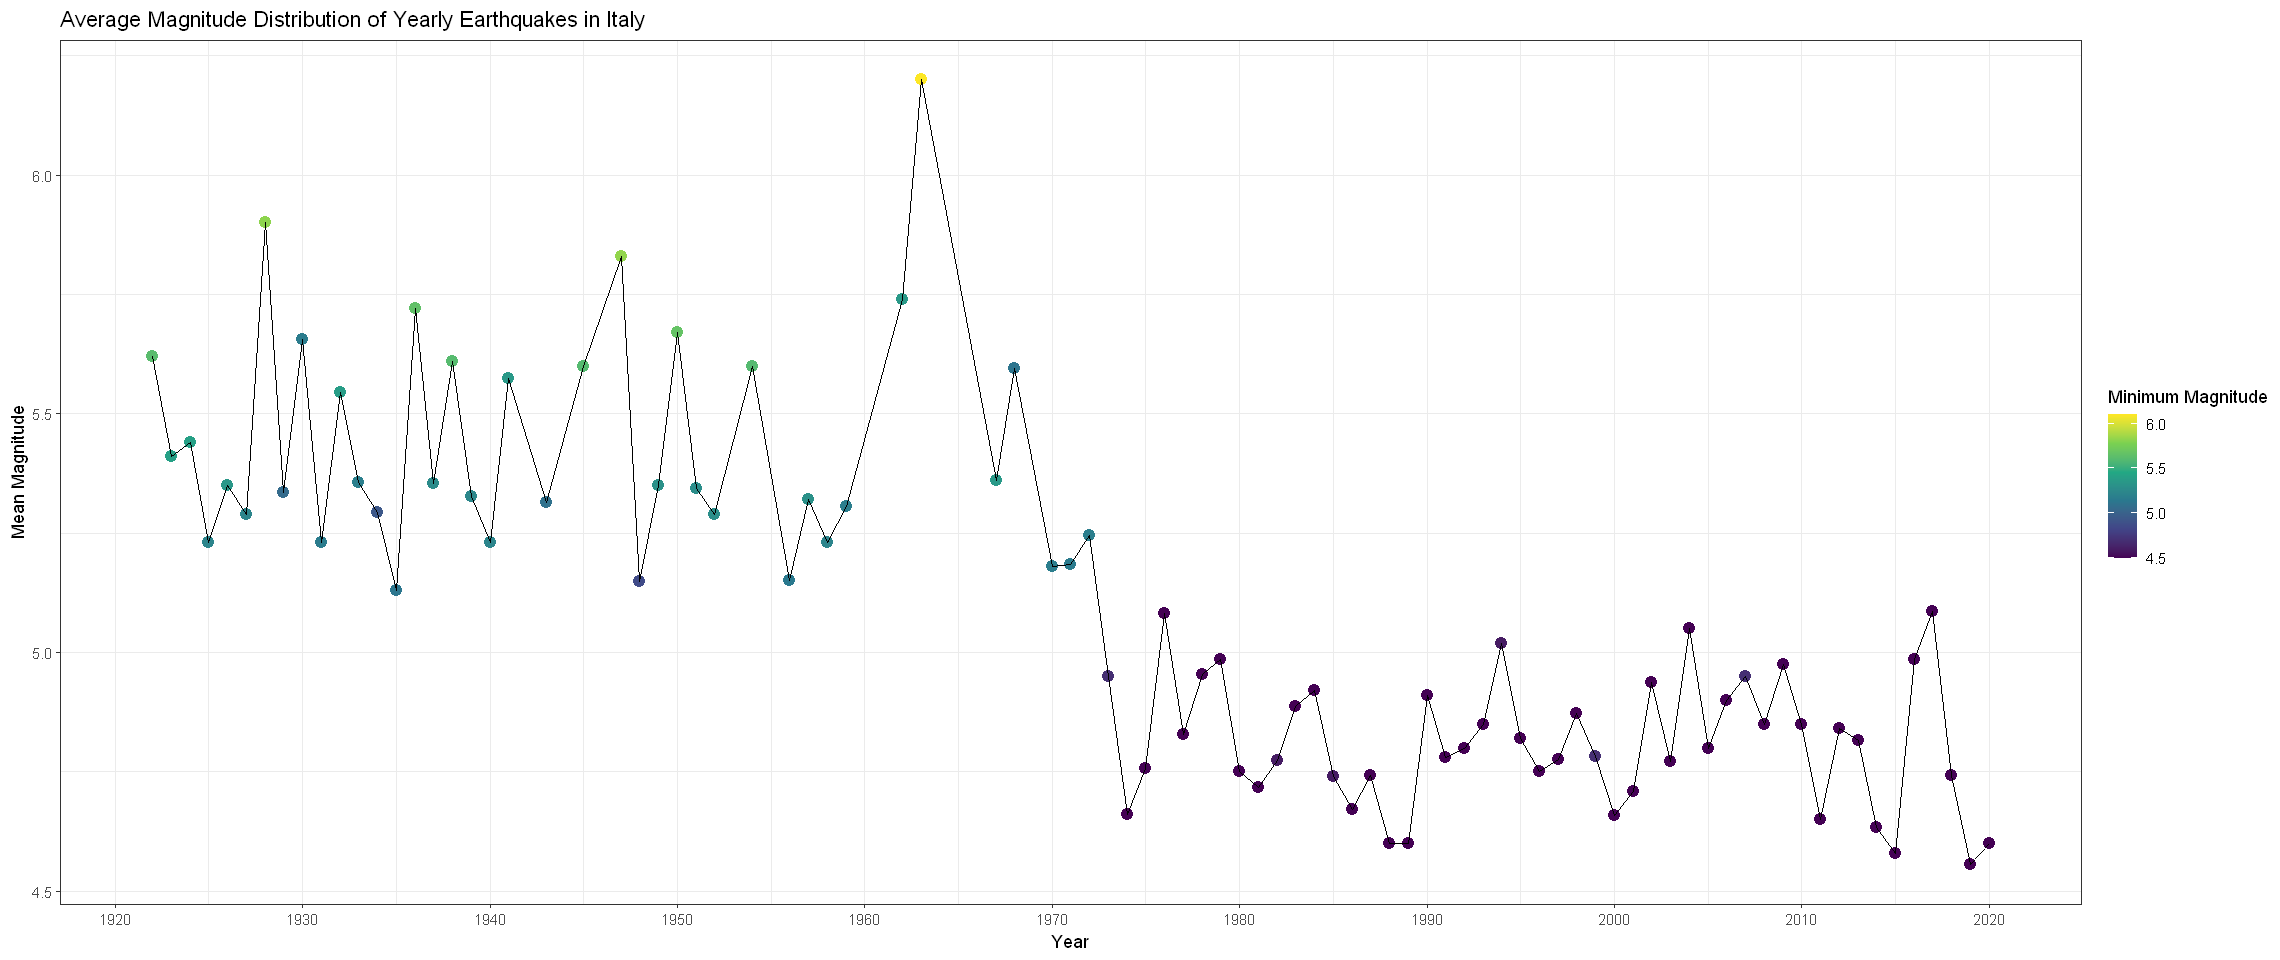

In [21]:
ggplot(earthquakes_per_year, aes(x = as.integer(year), y = mean_mag)) +
  geom_point(aes(col = min_mag), size = 3) +
  geom_line() +
  scale_color_viridis_c(name = "Minimum Magnitude") +
  labs(title = "Average Magnitude Distribution of Yearly Earthquakes in Italy",
       x = "Year",
       y = "Mean Magnitude") +
  scale_x_continuous(breaks = seq(1920, 2021, by = 10)) +
  theme_bw()

### Year-Magnitude Correlation

**Hypothesis:** There is a correlation between year and magnitude, due to the fact that before a certain year, the technology to detect lower magnitude seismic events was not available, so only those with higher magnitudes were recorded.

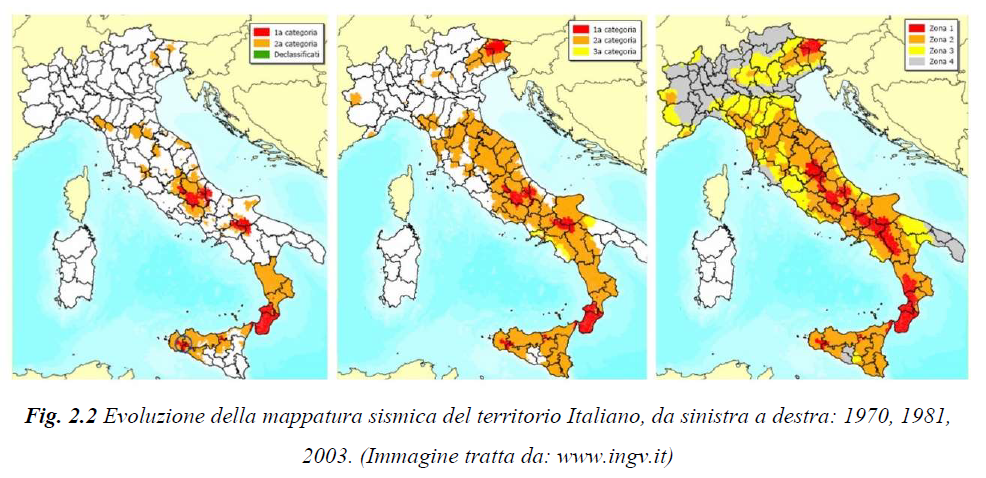

The historical analysis, reported in Fig. 2.2, highlights how the seismic classification of the Italian territory was episodic until 1980. Only after the Friuli earthquake in 1976 were systematic studies activated for assessing the seismic hazard of the Italian territory. This led to an increase from 25% of the territory considered at seismic risk in 1980 to 67% in 2003. <br>


from *Cavalli, Camilla. (2017). Cavalli C., Iavarone F., Passoni C., Labò S., Marini A. 2017. Vulnerabilità sismica degli edifici esistenti in c.a.: il ruolo del vano scale.Technical Report n. 9. Dipartimento di Ingegneria, Architettura, Territorio, Ambiente e Matematica dell'Università degli studi di Brescia. Agosto 2017. [link](https://www.researchgate.net/publication/319236536_Cavalli_C_Iavarone_F_Passoni_C_Labo_S_Marini_A_2017_Vulnerabilita_sismica_degli_edifici_esistenti_in_ca_il_ruolo_del_vano_scaleTechnical_Report_n_9_Dipartimento_di_Ingegneria_Architettura_Territorio_A)*

Even looking at the maximum values, one observes consistent peak magnitudes each year, indicating that it was certainly not due to them being more powerful previously.

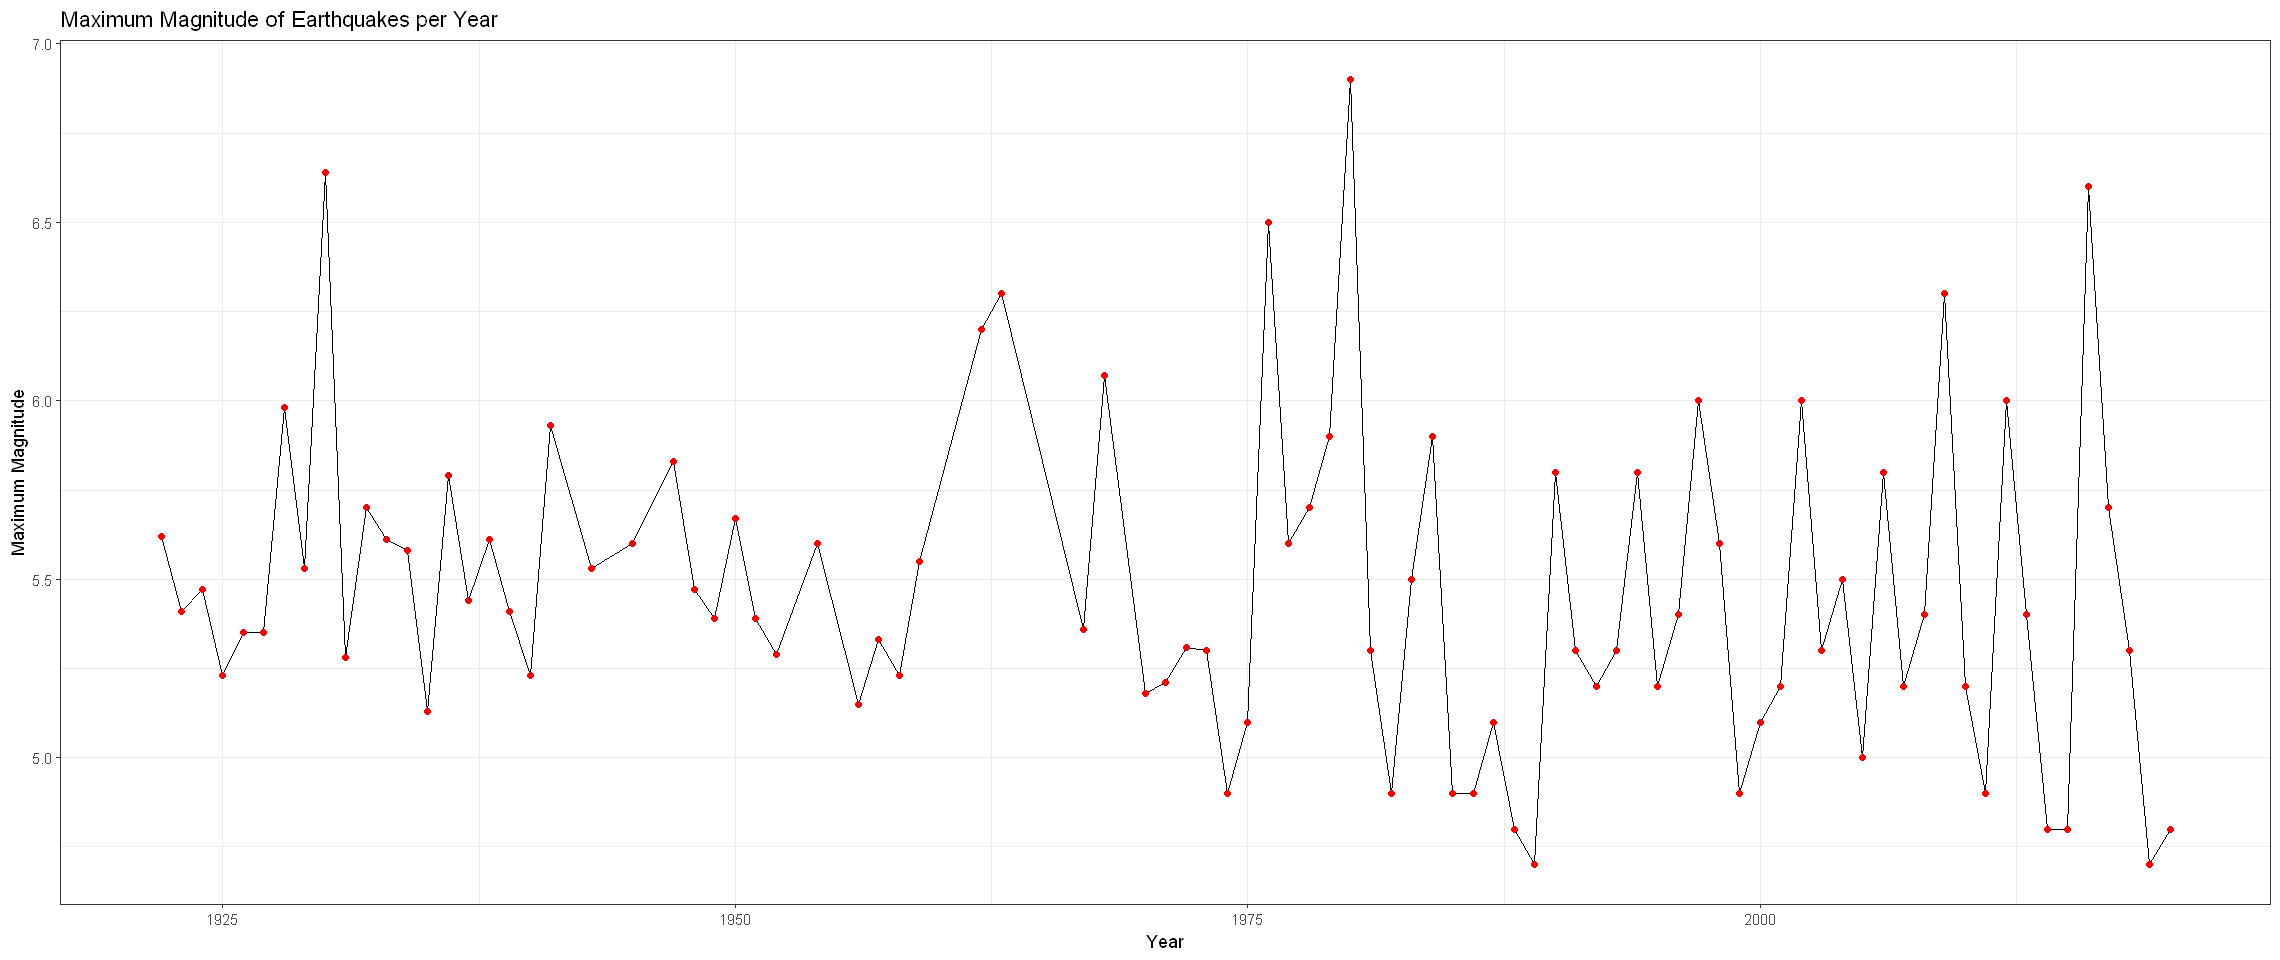

In [22]:
ggplot(earthquakes_per_year, aes(x = as.numeric(year), y = max_mag)) +
  geom_line(color = "black") +
  geom_point(color = "red") +
  labs(title = "Maximum Magnitude of Earthquakes per Year",
       x = "Year",
       y = "Maximum Magnitude") +
  theme_bw()

Let's look at the trend of minimum magnitudes.

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


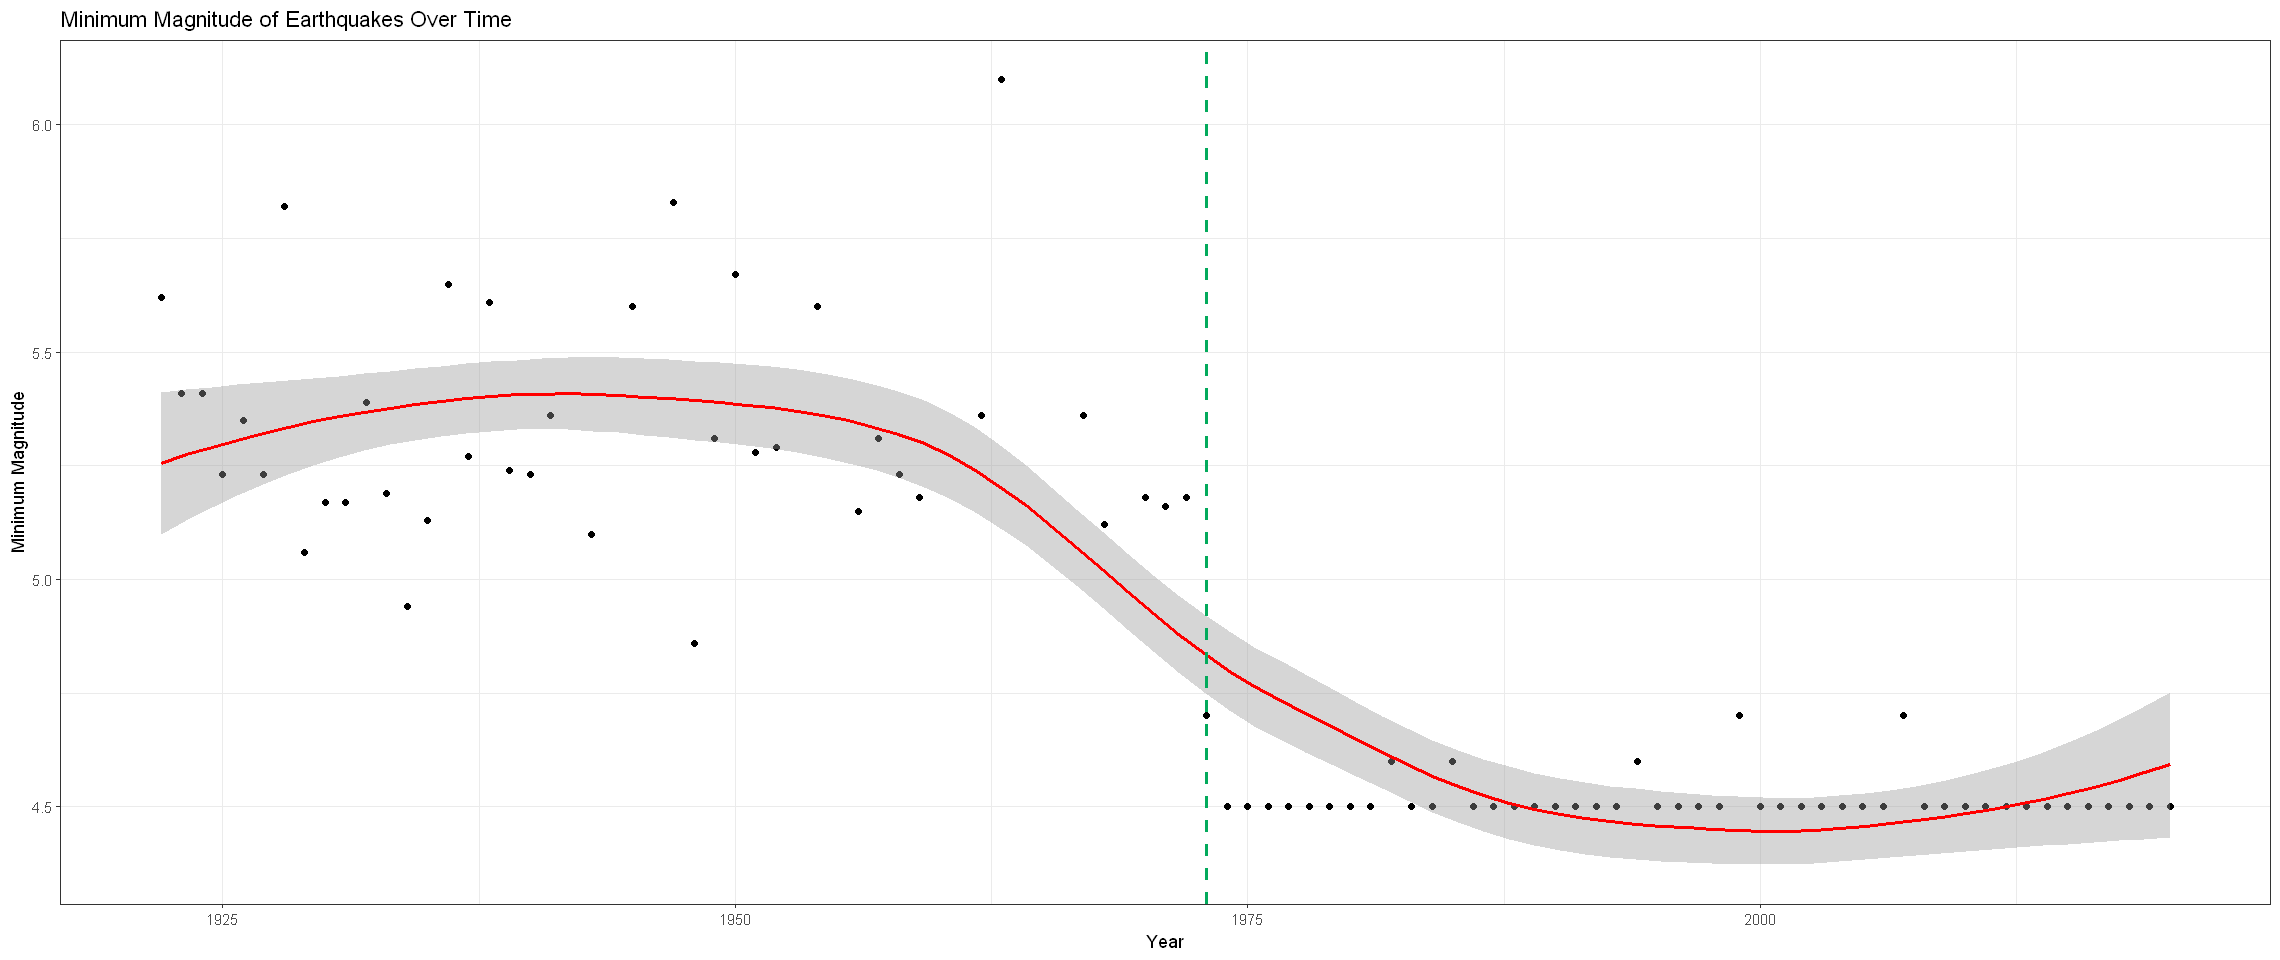

In [23]:
ggplot(earthquakes_per_year, aes(x = as.numeric(year), y = min_mag)) +
  geom_point() +
  geom_smooth(col = "red") +
  geom_vline(xintercept = 1973, color = "#03aa5c",
             linetype = "dashed", linewidth = 1) +
  labs(title = "Minimum Magnitude of Earthquakes Over Time",
       x = "Year",
       y = "Minimum Magnitude") +
  theme_bw()


There is indeed a sort of trend change observed around 1973. To verify if this is true:

#### Hypothesis Testing

Assuming a null hypothesis $H_0: \mu=0$ and an alternative $H_1: \mu \neq 0$

If the p-value is smaller than $\alpha$ (assuming a Confidence Level of 95% so $\alpha$ = 0.05), we can reject the null hypothesis and conclude that there is a significant difference between the magnitudes before and after 1973.

Let's see if we can do an hypothesis testing using distributions.

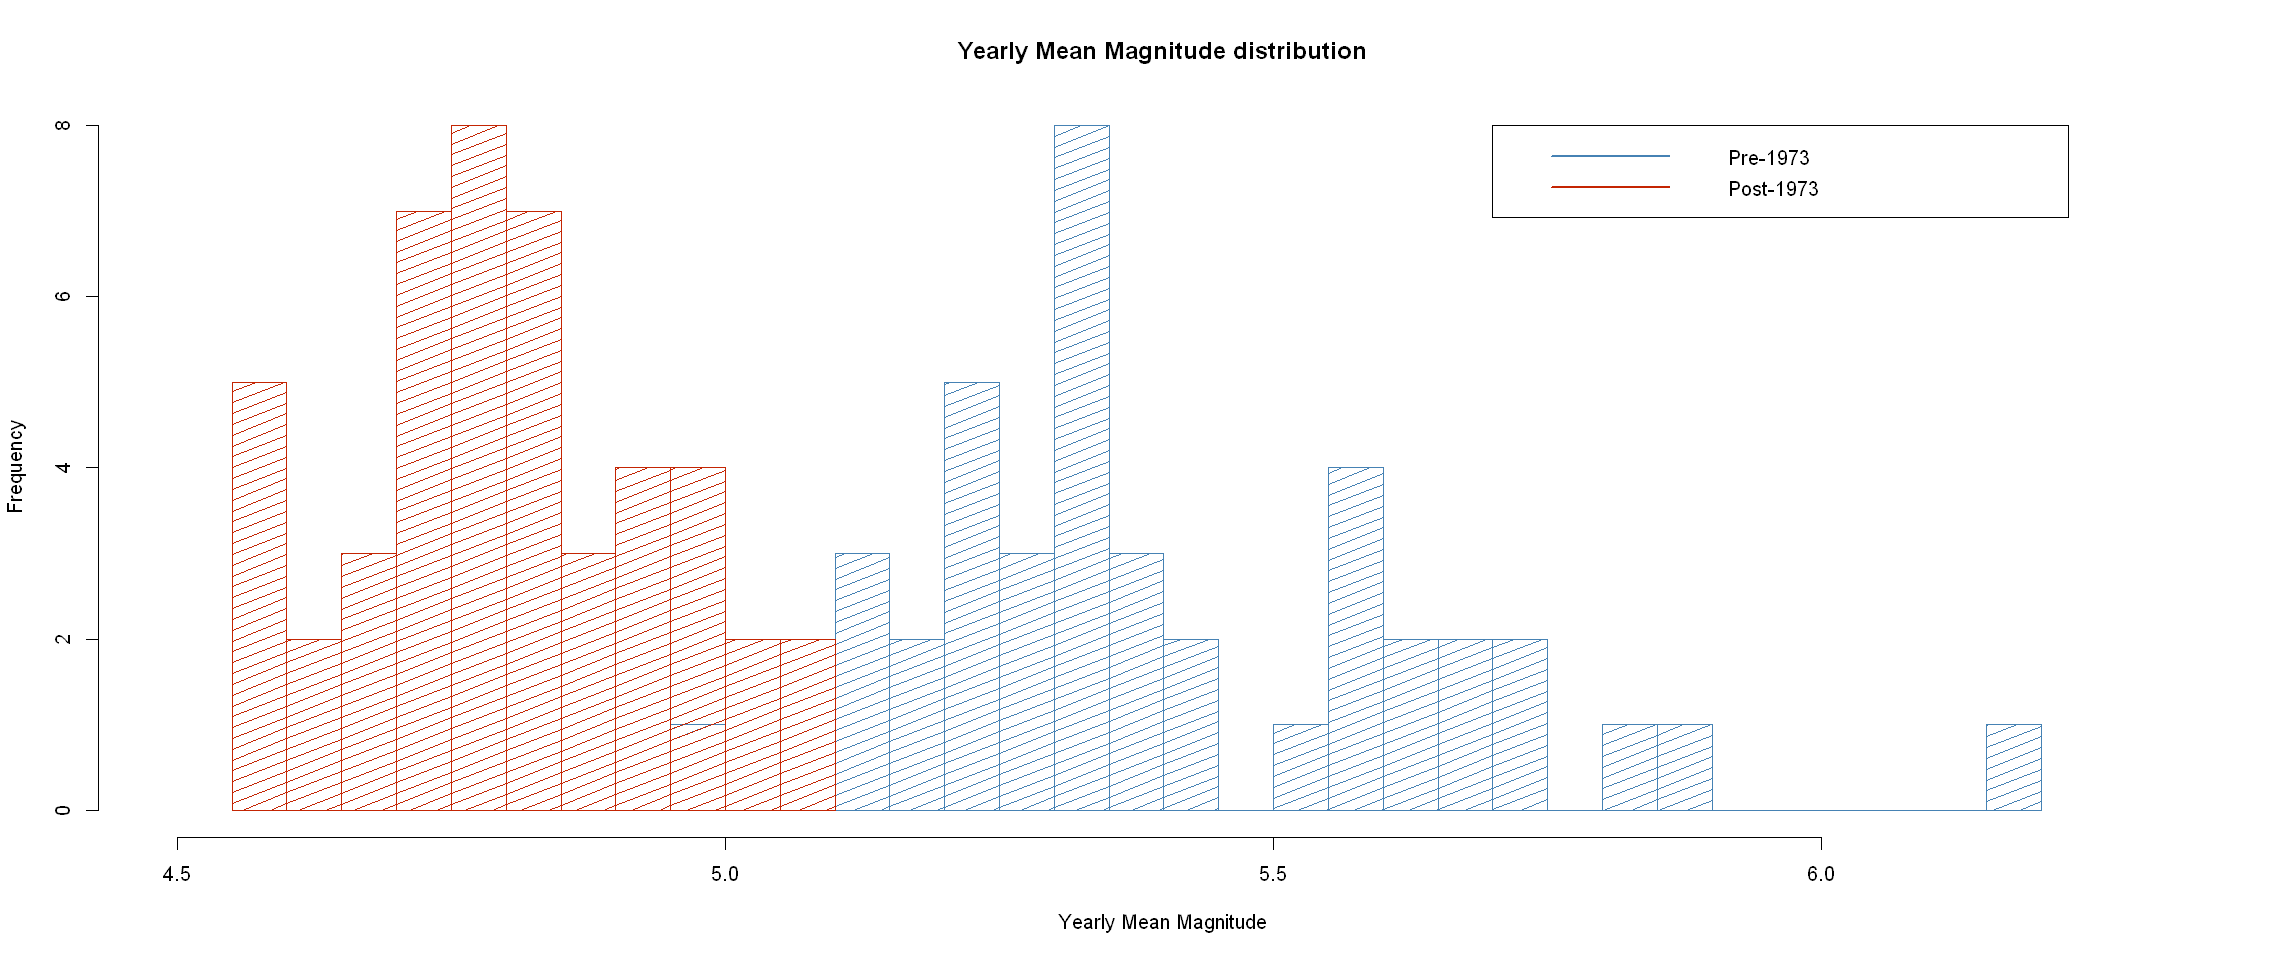

In [24]:
pre_1973 <- subset(earthquakes_per_year, as.numeric(year) <= 1973)
post_1973 <- subset(earthquakes_per_year, as.numeric(year) > 1973)

hist(pre_1973$mean_mag, breaks = 20, col = "steelblue", density = 20,
     xlim = c(4.5, 6.3),
     xlab = "Yearly Mean Magnitude",
     main = "Yearly Mean Magnitude distribution")
hist(post_1973$mean_mag, breaks = 15, add = TRUE,
     col = "#C42503FF", density = 20)
legend(x = 5.7, y = 8, legend = c("Pre-1973", "Post-1973"),
       col = c("steelblue", "#C42503FF"), lty = 1, lwd = 2, cex = 1)

In [25]:
dim(pre_1973)
dim(post_1973)

[1] 41  6

[1] 47  6

Assuming a uniform prior, we consider a normal likelihood for the distribution of magnitudes.

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


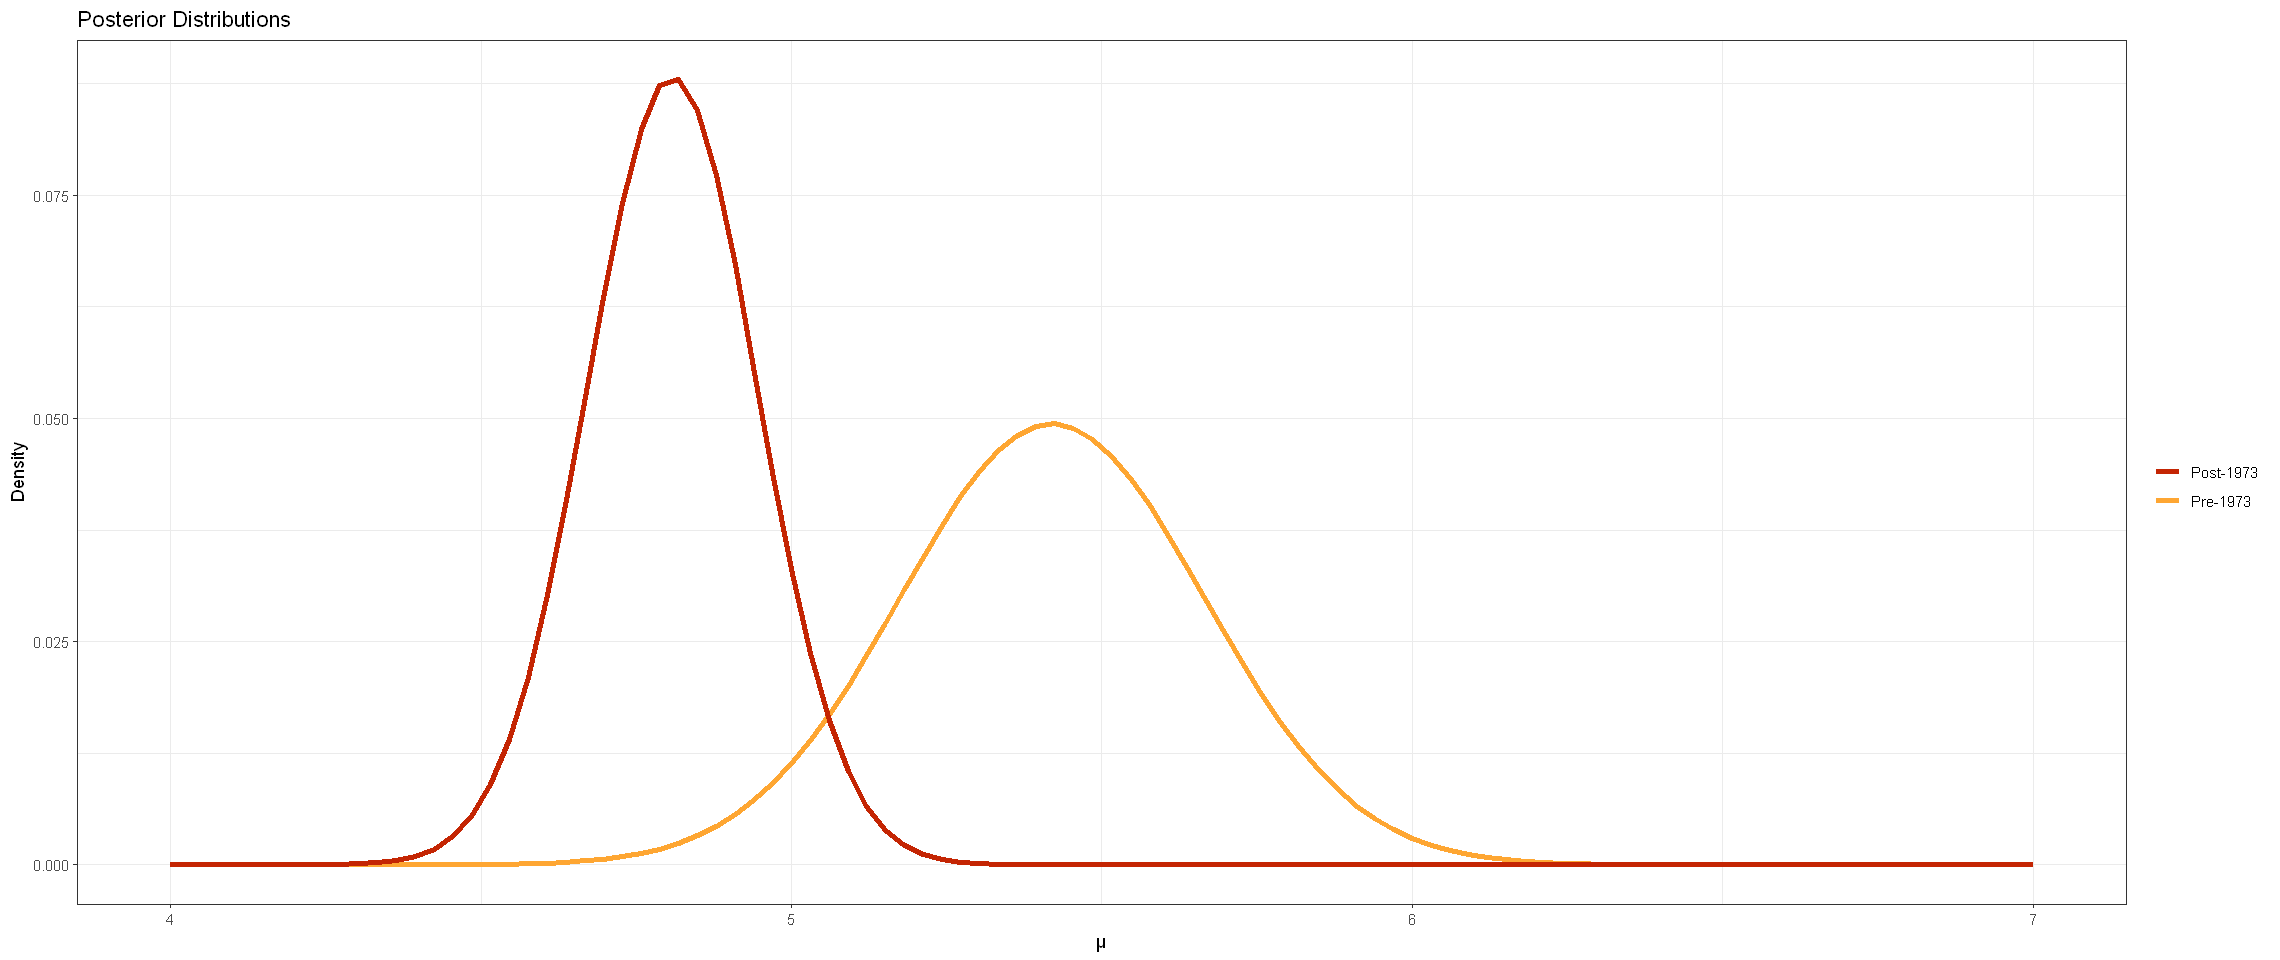

In [26]:
x <- seq(4, 7, length.out = 100)
norm_pre <- dnorm(x, mean = mean(pre_1973$mean_mag), sd = sqrt(var(pre_1973$mean_mag))) / sum(dnorm(x, mean = mean(pre_1973$mean_mag), sd = sqrt(var(pre_1973$mean_mag))))
norm_post <- dnorm(x, mean = mean(post_1973$mean_mag), sd = sqrt(var(post_1973$mean_mag))) / sum(dnorm(x, mean = mean(post_1973$mean_mag), sd = sqrt(var(post_1973$mean_mag))))
colors <- turbo(2, alpha = 1, begin = 0.7, end = 0.9, direction = 1)

ggplot() +
  scale_color_manual(values = c("Pre-1973" = "#FEA632FF",
                                "Post-1973" = "#C42503FF"), name = " ") +
  geom_line(aes(x, norm_pre, col = "Pre-1973"), size = 1.5) +
  geom_line(aes(x, norm_post, col = "Post-1973"), size = 1.5) +
  theme_bw() +
  ggtitle("Posterior Distributions") +
  xlab("μ") +
  ylab("Density")

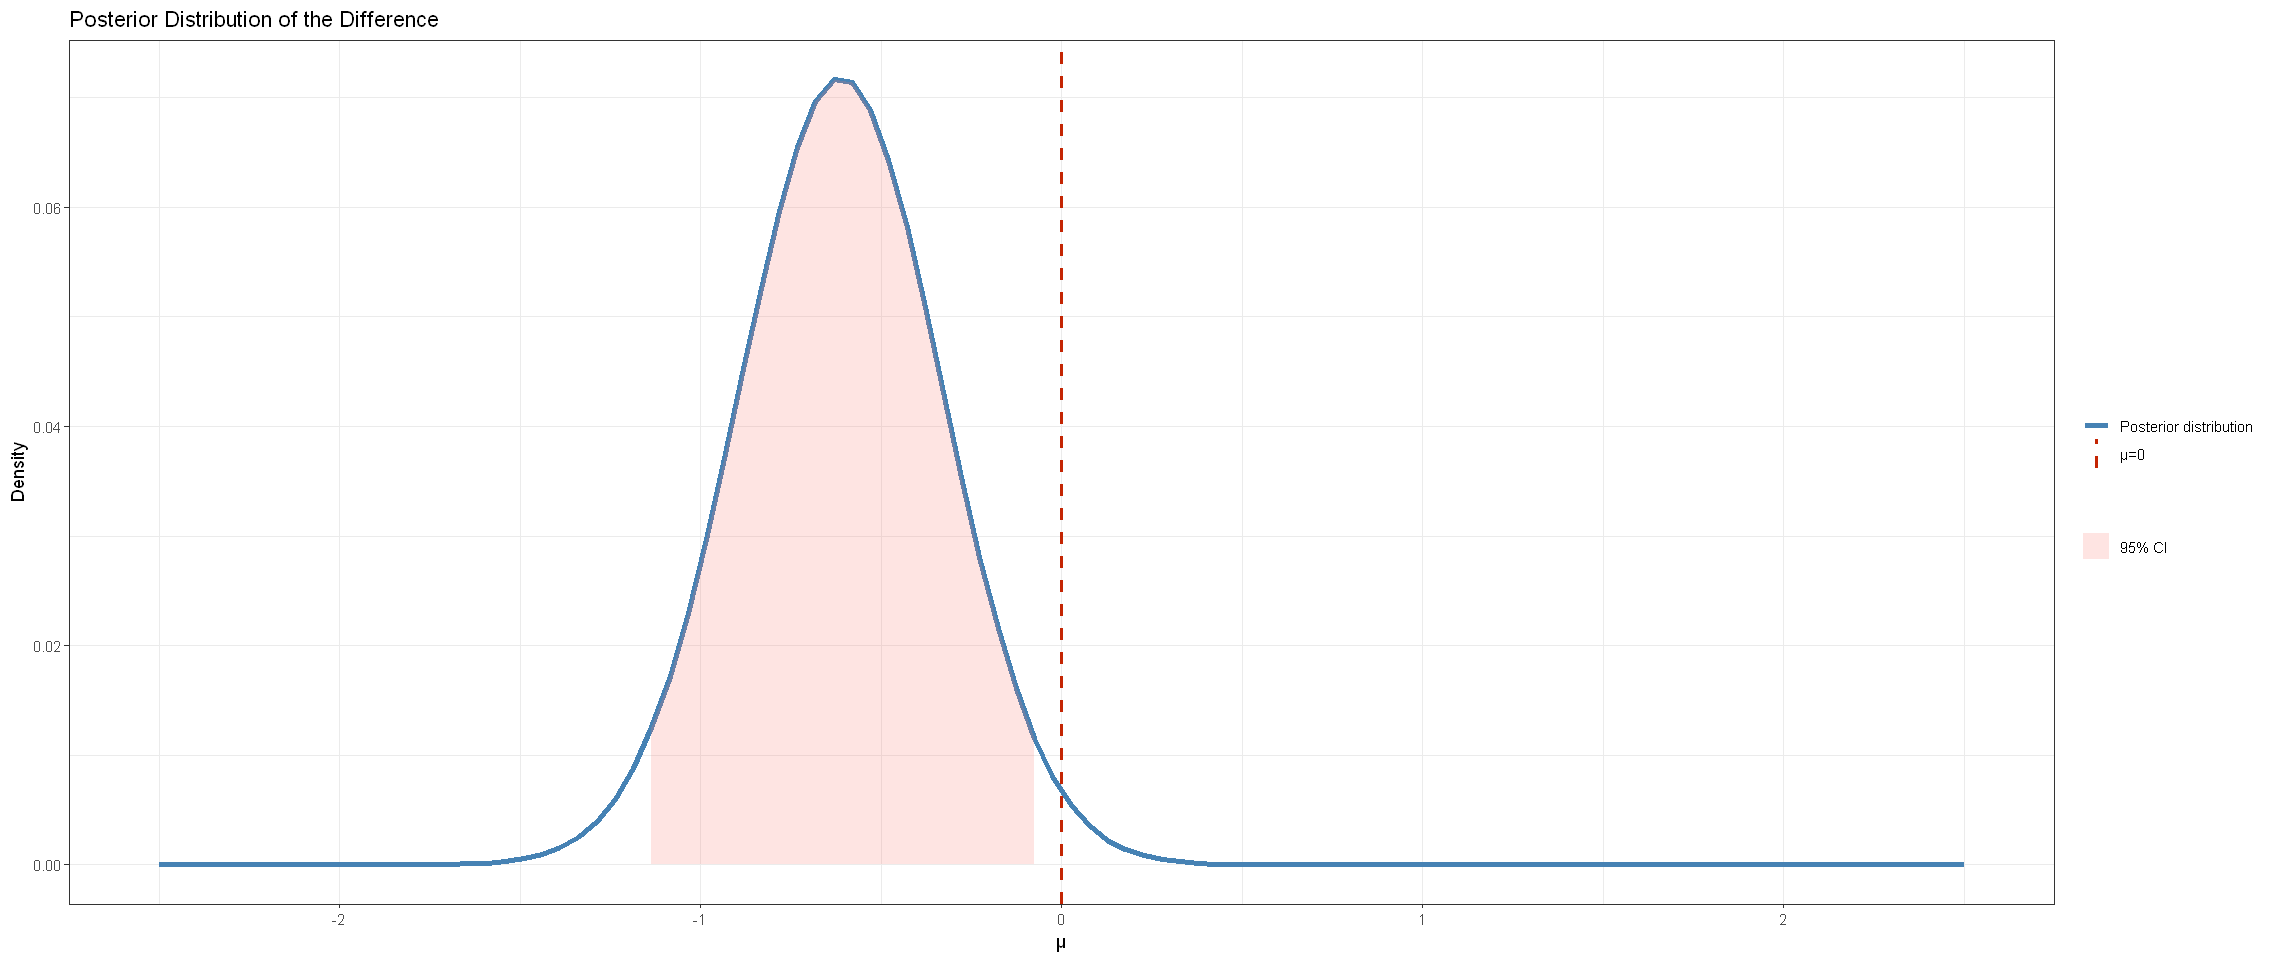

In [27]:
mu_diff <- mean(post_1973$mean_mag) - mean(pre_1973$mean_mag)
sigma_diff <- sqrt(var(post_1973$mean_mag) + var(pre_1973$mean_mag))

x_diff <- seq(-2.5, 2.5, length.out = 100)
norm_diff <- dnorm(x_diff, mu_diff, sigma_diff) / sum(dnorm(x_diff, mu_diff, sigma_diff))
ci <- qnorm(c(0.025, 0.975), mu_diff, sigma_diff)

datas <- data.frame(x_diff = x_diff, density = norm_diff)
subset_data <- subset(datas, x_diff > ci[1] & x_diff < ci[2])


ggplot() +
  scale_color_manual(values = c("Posterior distribution" = "steelblue",
                                "μ=0" = "#C42503FF"), name = " ") +
  geom_line(aes(x_diff, norm_diff, col = "Posterior distribution"), size = 1.5) +
  geom_ribbon(data = subset_data, aes(x = x_diff, ymax = density, ymin = 0, fill = "95% CI"),
              alpha = 0.2) +
  geom_vline(aes(xintercept = 0, color = "μ=0"), linetype = "dashed", size = 1) +
  labs(fill = " ") +
  theme_bw() +
  ggtitle("Posterior Distribution of the Difference") +
  xlab("μ") +
  ylab("Density")


$\mu=0$ does not fall inside the 95% confidence level, so we reject the null hypothesis. 

The results support the hypothesis: before 1973, mainly higher magnitude earthquakes were detected, whereas after 1973, thanks to improvements in detection technologies, lower magnitude earthquakes are detected as well. This explains why the average magnitude of earthquakes after 1973 is significantly lower than that before 1973.

If we reanalyze the time series, narrowing down the dataset and reanalyze it focusing on more recent years.

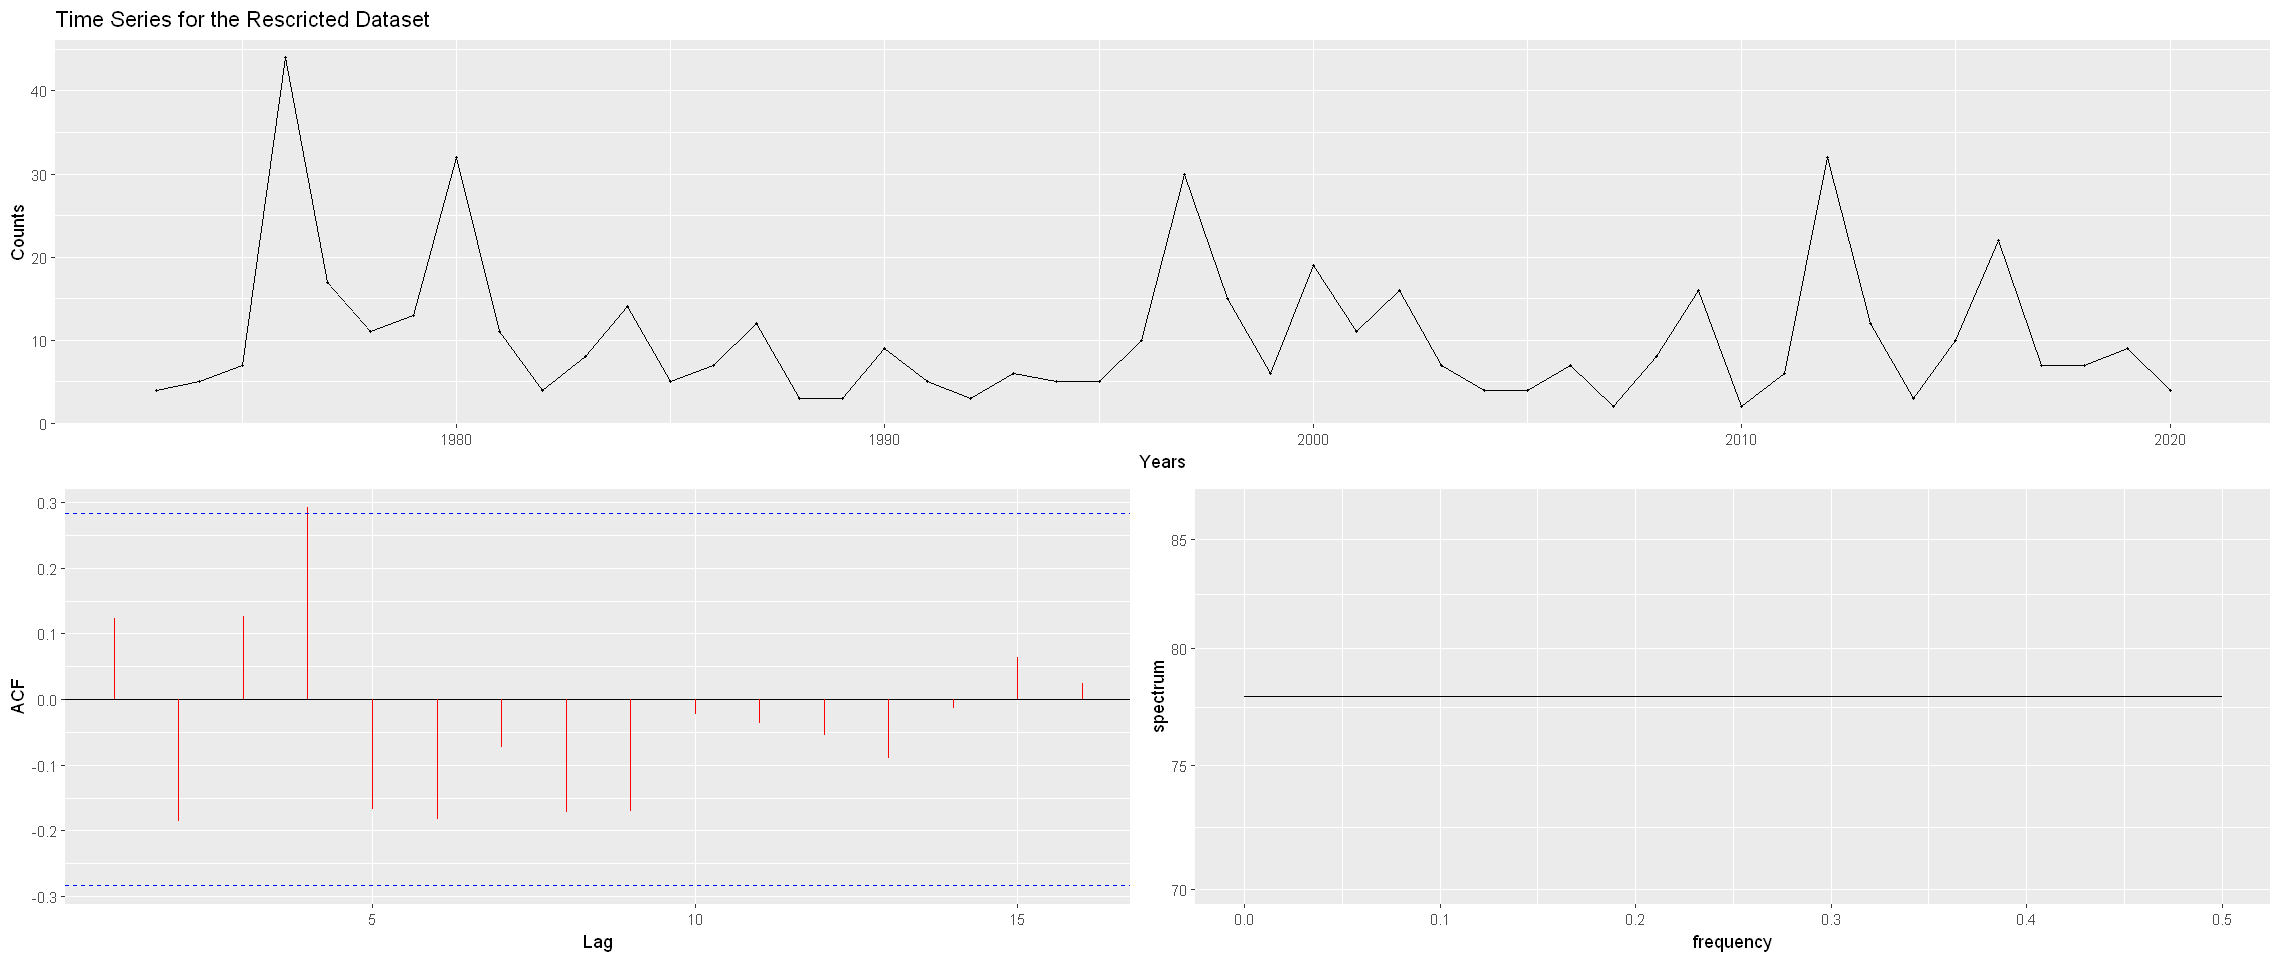

In [28]:
e_per_year_restricted <- e_per_year[e_per_year$year >= 1973, ]
earthquake_ts_restricted <- ts(e_per_year_restricted$count,
                               start = min(e_per_year_restricted$year),
                               end = max(e_per_year_restricted$year),
                               frequency = 1)
ggtsdisplay(earthquake_ts_restricted, plot.type = "spectrum",
            xlab = "Years", ylab = "Counts", col = "red",
            main = "Time Series for the Rescricted Dataset")

Now we see a flat spectrum that makes more sense, given that we know that earthquake events do not fit very well with the definition of a time series, since they are extremely irregular in time.
A flat spectrum suggests the absence of any periodic or cyclic components. The time series is essentially random and does not have any repetitive patterns, like white noise.

The same reasoning can be done for the depth, as a similar phenomenon seems to appear.

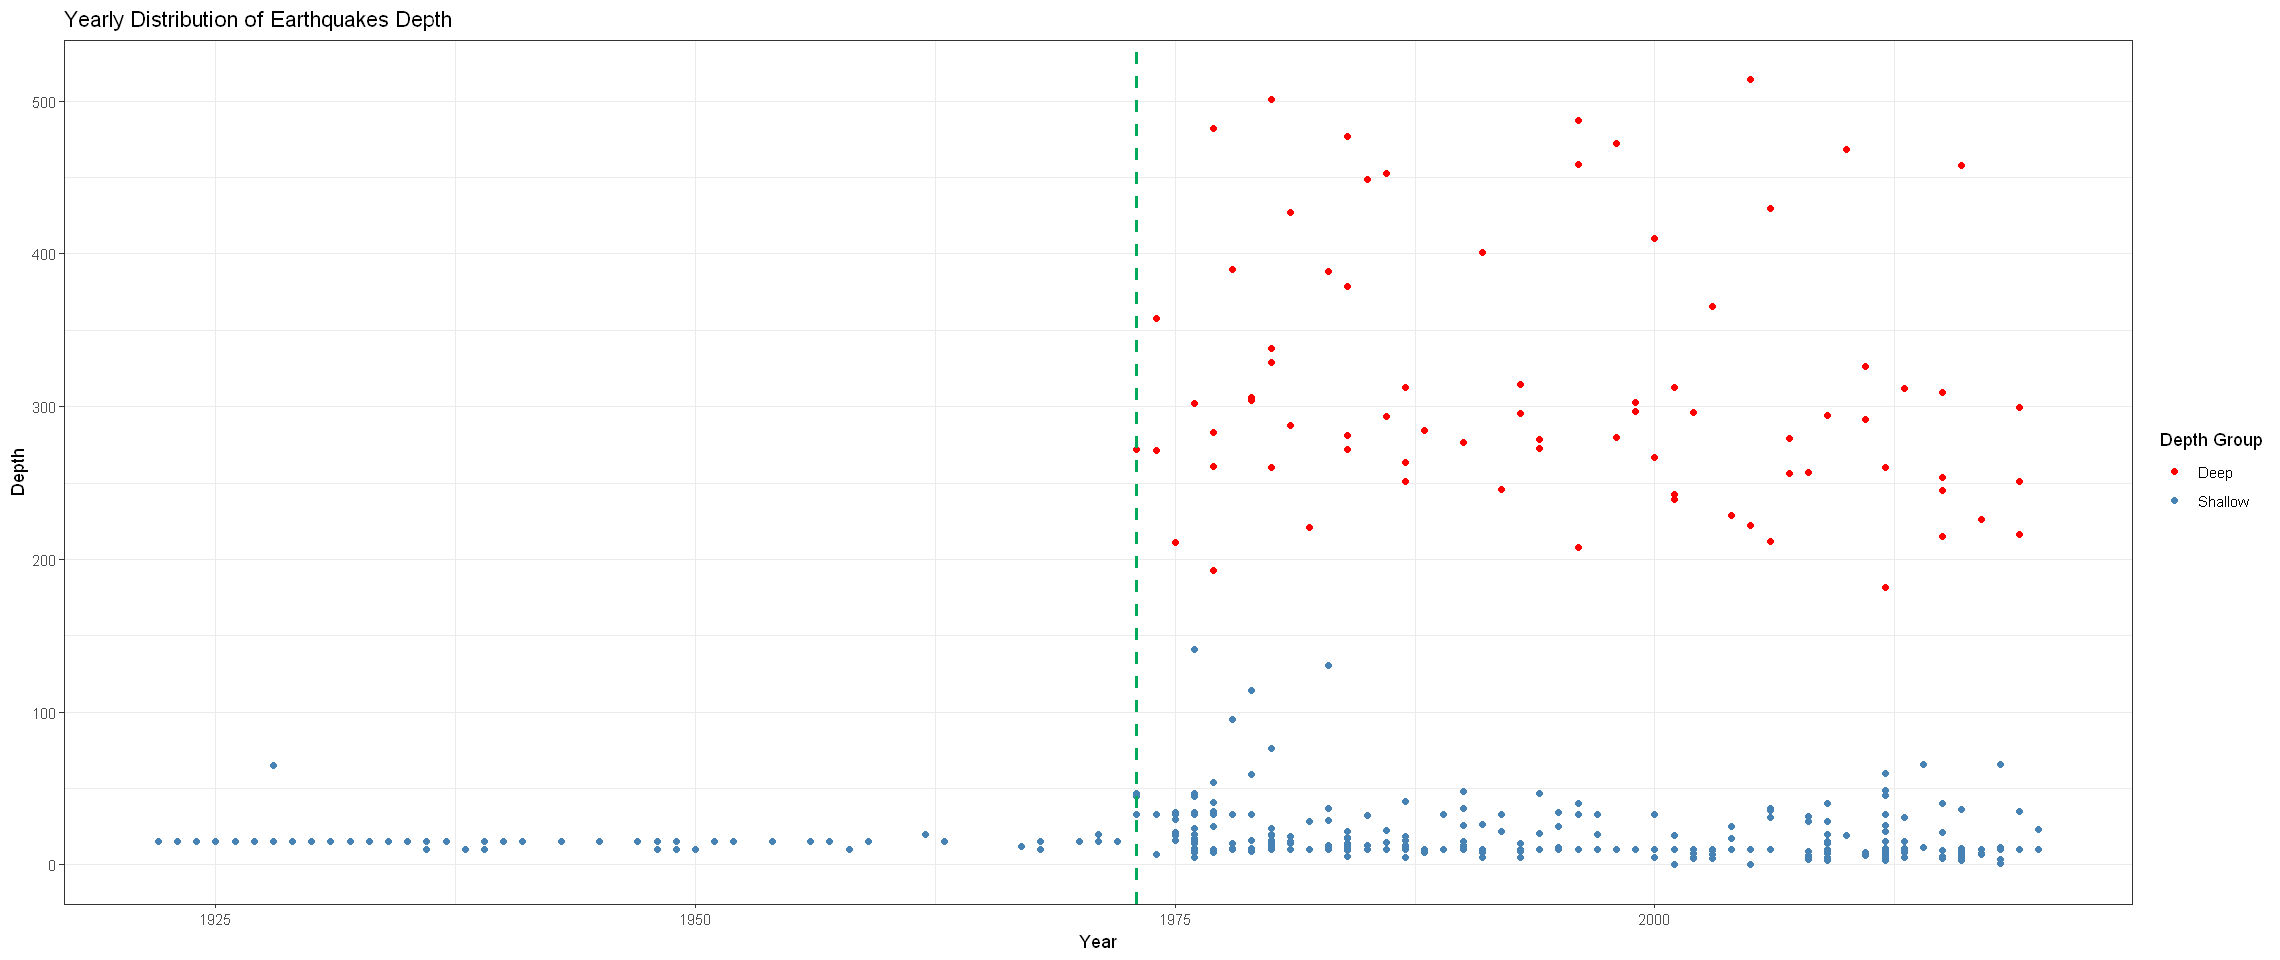

In [29]:
ggplot(df_italia, aes(y = depth, x = year, col = depth_group)) +
  scale_color_manual(values = c("Shallow" = "steelblue", "Deep" = "red")) +
  geom_point() +
  geom_vline(xintercept = 1973, color = "#03aa5c", linetype = "dashed", size=1) +
  labs(title = "Yearly Distribution of Earthquakes Depth",
       x = "Year",
       y = "Depth",
       color = "Depth Group") +
  theme_bw()

Having demonstrated this correlation between magnitude and year, we can avoid including the full forecast and instead only focuse on the restricted one.

### AEM Forecast

Let's perform a forecast on Average Earthquakes Magnitude Time Series:

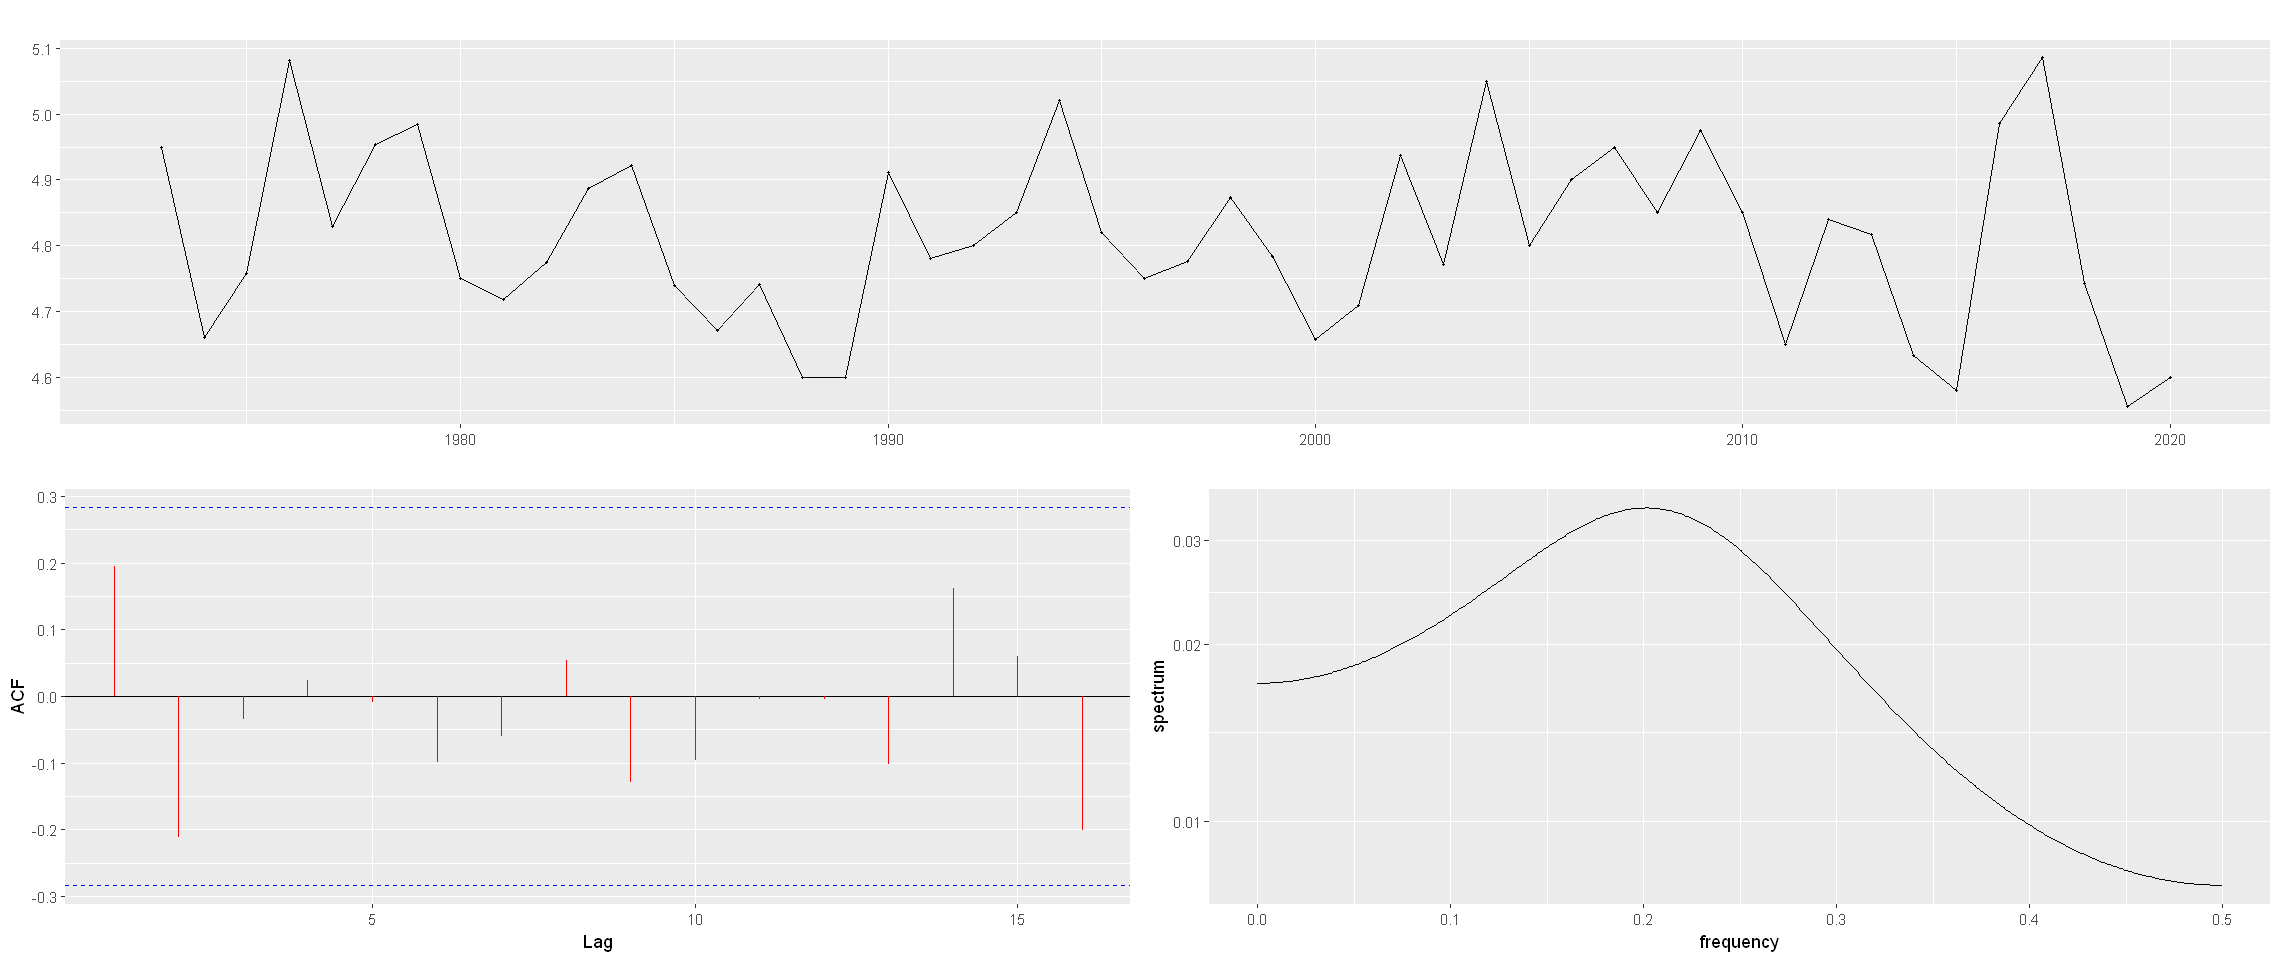

In [30]:
mag_ts_restricted <- ts(e_per_year_restricted$mean_mag,
                        start = min(e_per_year_restricted$year),
                        end = max(e_per_year_restricted$year),
                        frequency = 1)
ggtsdisplay(mag_ts_restricted, plot.type = "spectrum", col = "red")

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


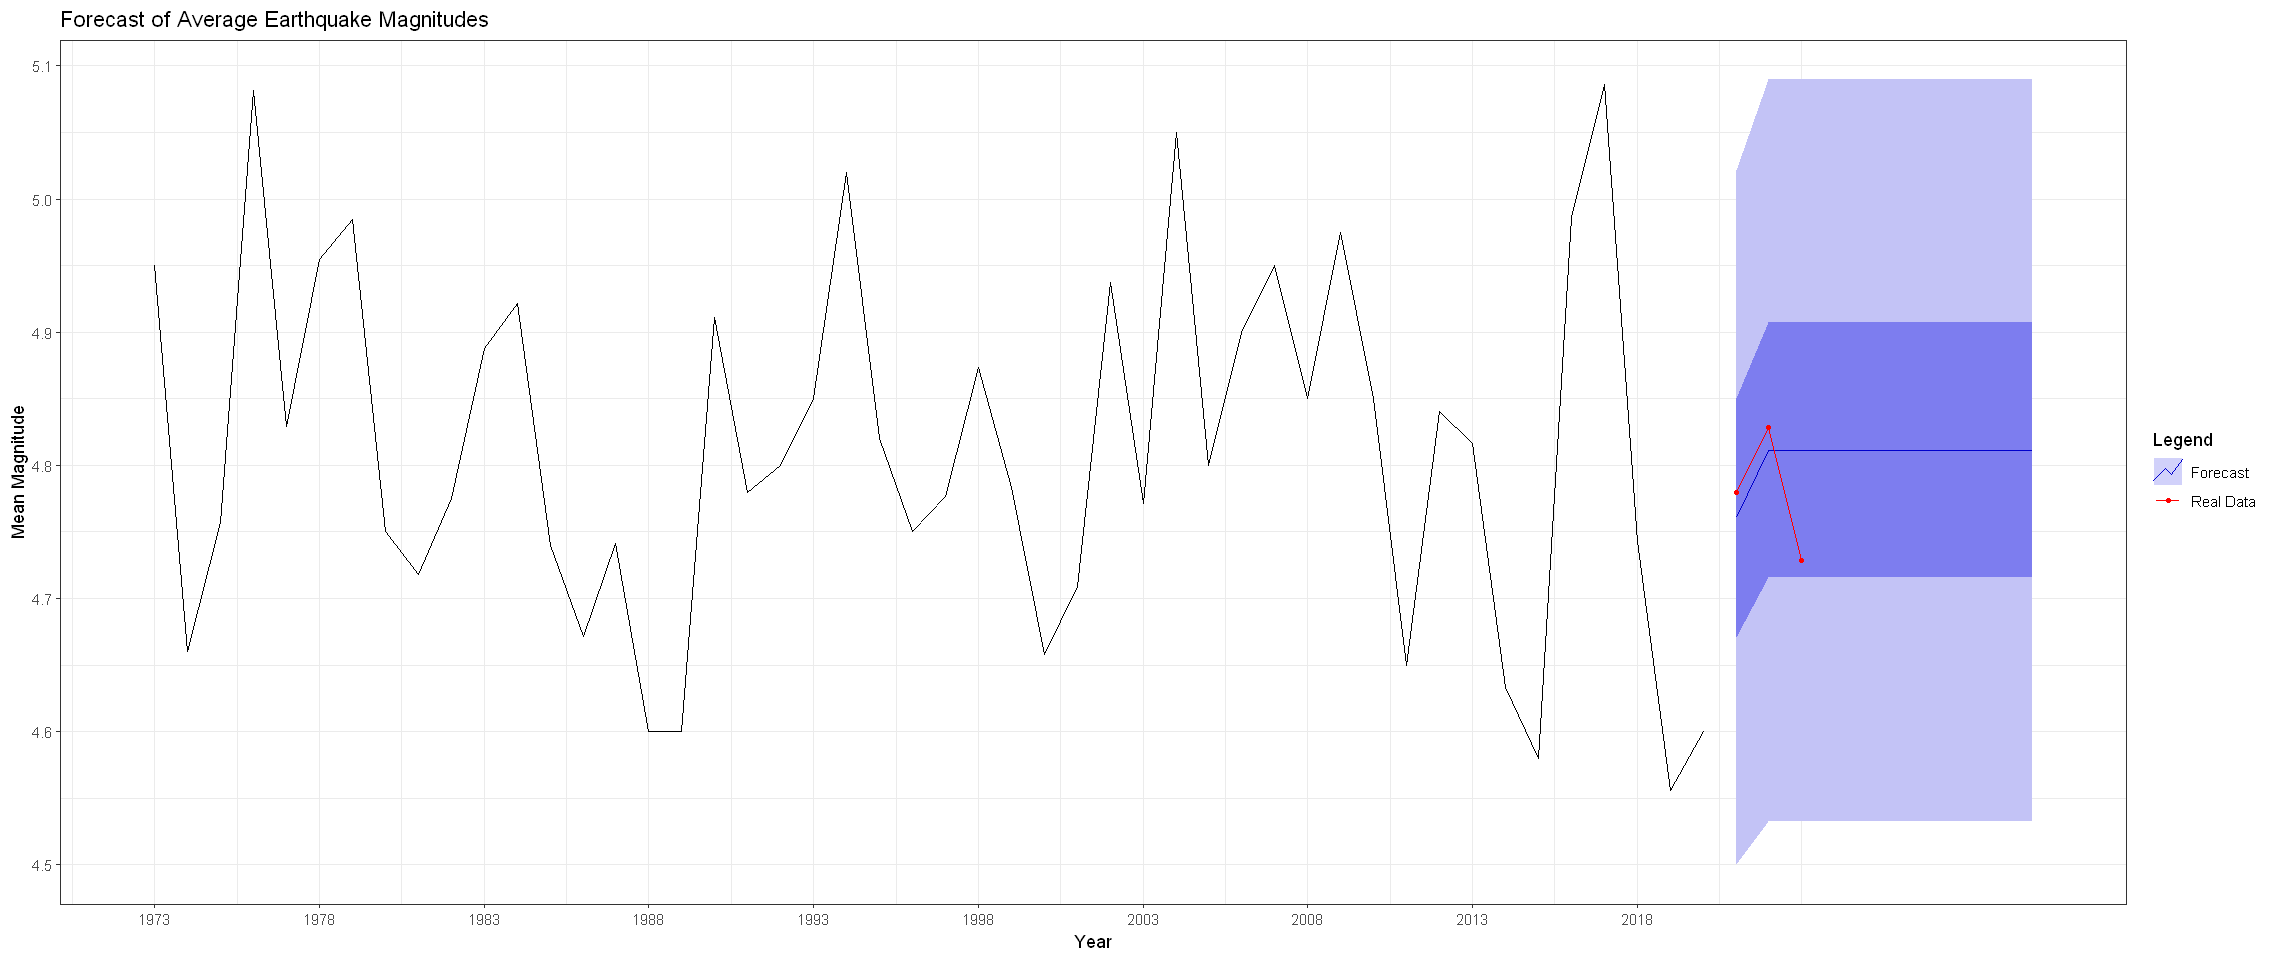

In [31]:
fit <- auto.arima(mag_ts_restricted)
forecasted <- forecast(fit, h = 10, level = c(50, 95))

p <- autoplot(forecasted, series = "Time Series") +
  autolayer(forecasted, series = "Forecast") +
  geom_point(data = earthquakes_per_year_future,
             aes(x = year, y = mean_mag, color = "Real Data"), size = 1) +
  geom_line(data = earthquakes_per_year_future,
            aes(x = year, y = mean_mag, color = "Real Data")) +
  scale_color_manual(values = c("Time Series" = "black",
                                "Forecast" = "blue", "Real Data" = "red")) +
  labs(title = "Forecast of Average Earthquake Magnitudes",
       x = "Year",
       y = "Mean Magnitude",
       color = "Legend") +
  scale_x_continuous(breaks = seq(1973, 2020, by = 5)) +
  theme_bw()

print(p)

### MEM Forecast

While for the Maximum Earthquakes Magnitude Time Series:

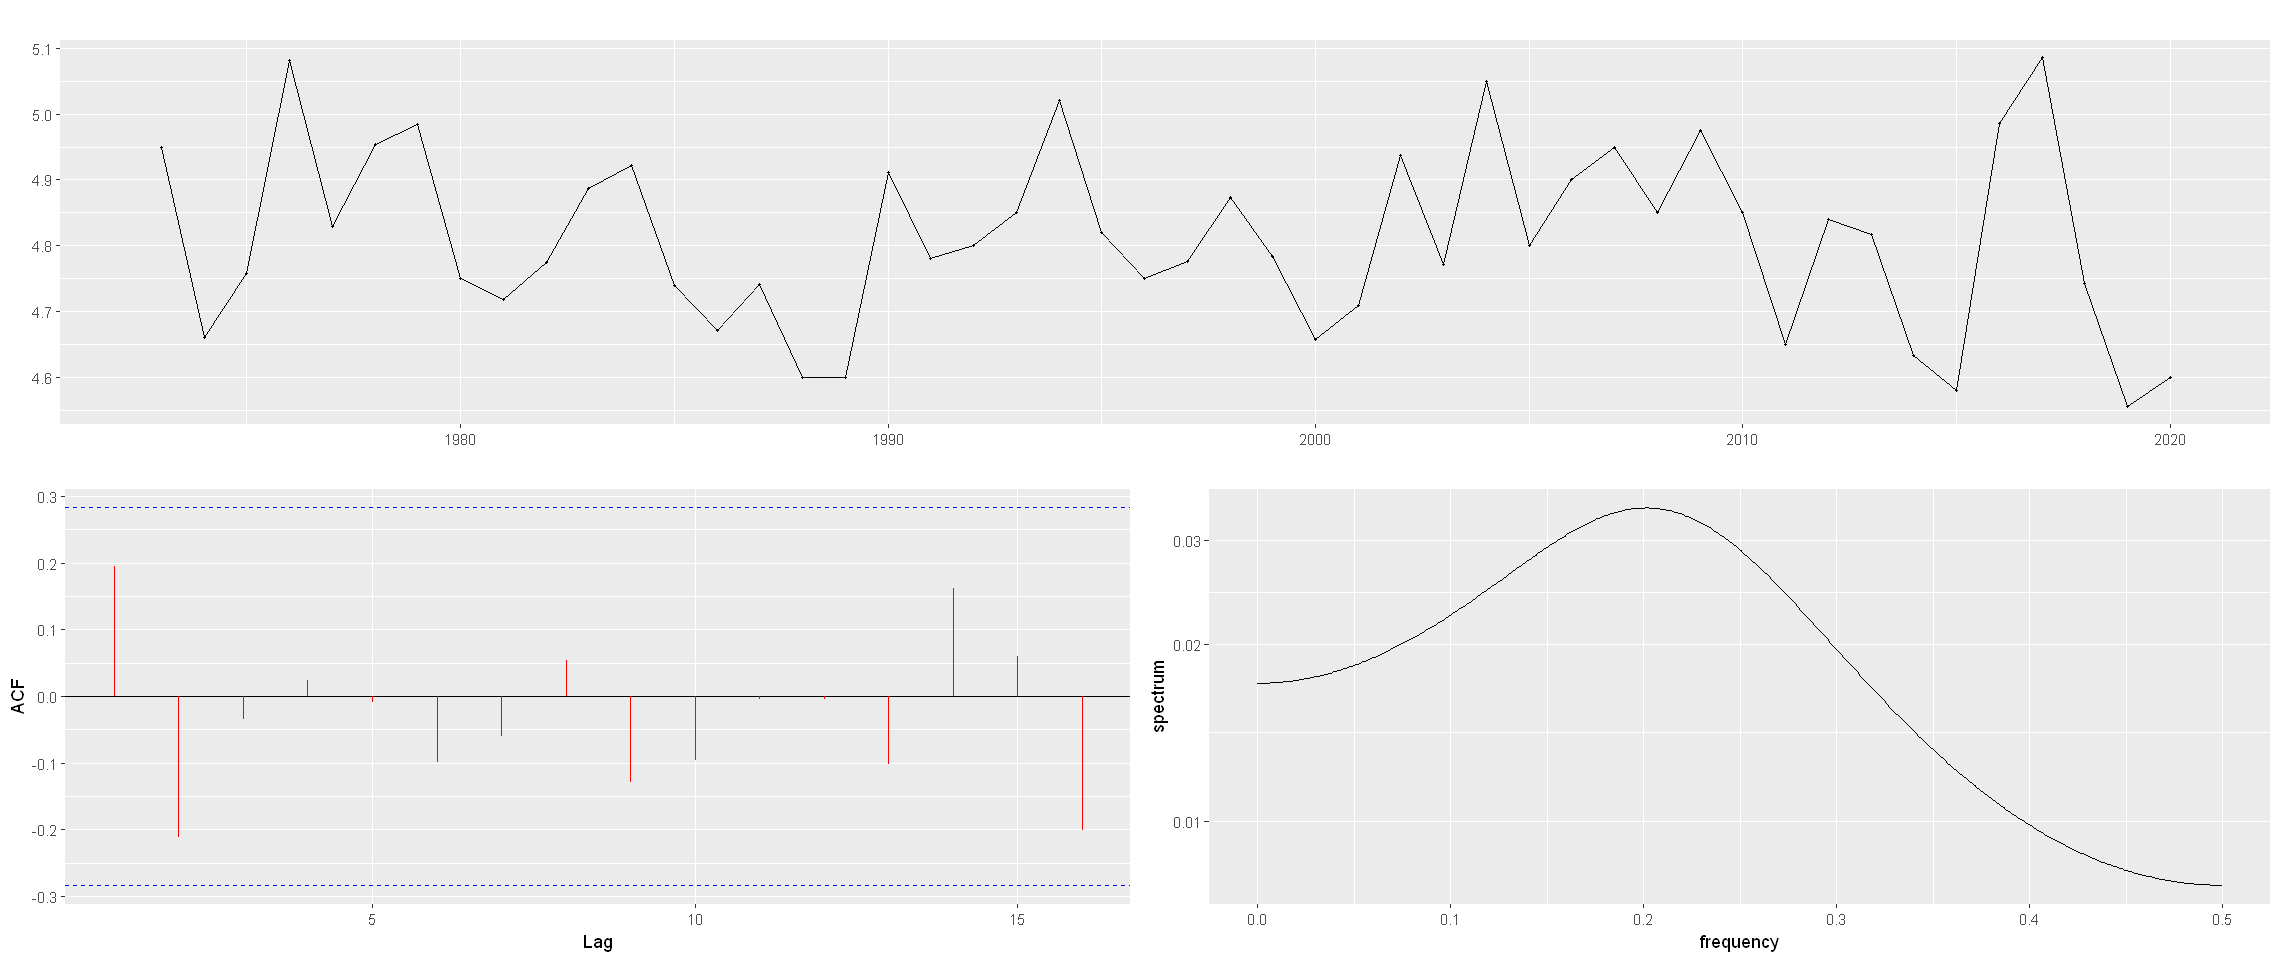

In [32]:
max_mag_ts_restricted <- ts(e_per_year_restricted$max_mag,
                            start = min(e_per_year_restricted$year),
                            end = max(e_per_year_restricted$year),
                            frequency = 1)
ggtsdisplay(mag_ts_restricted, plot.type = "spectrum", col = "red")

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


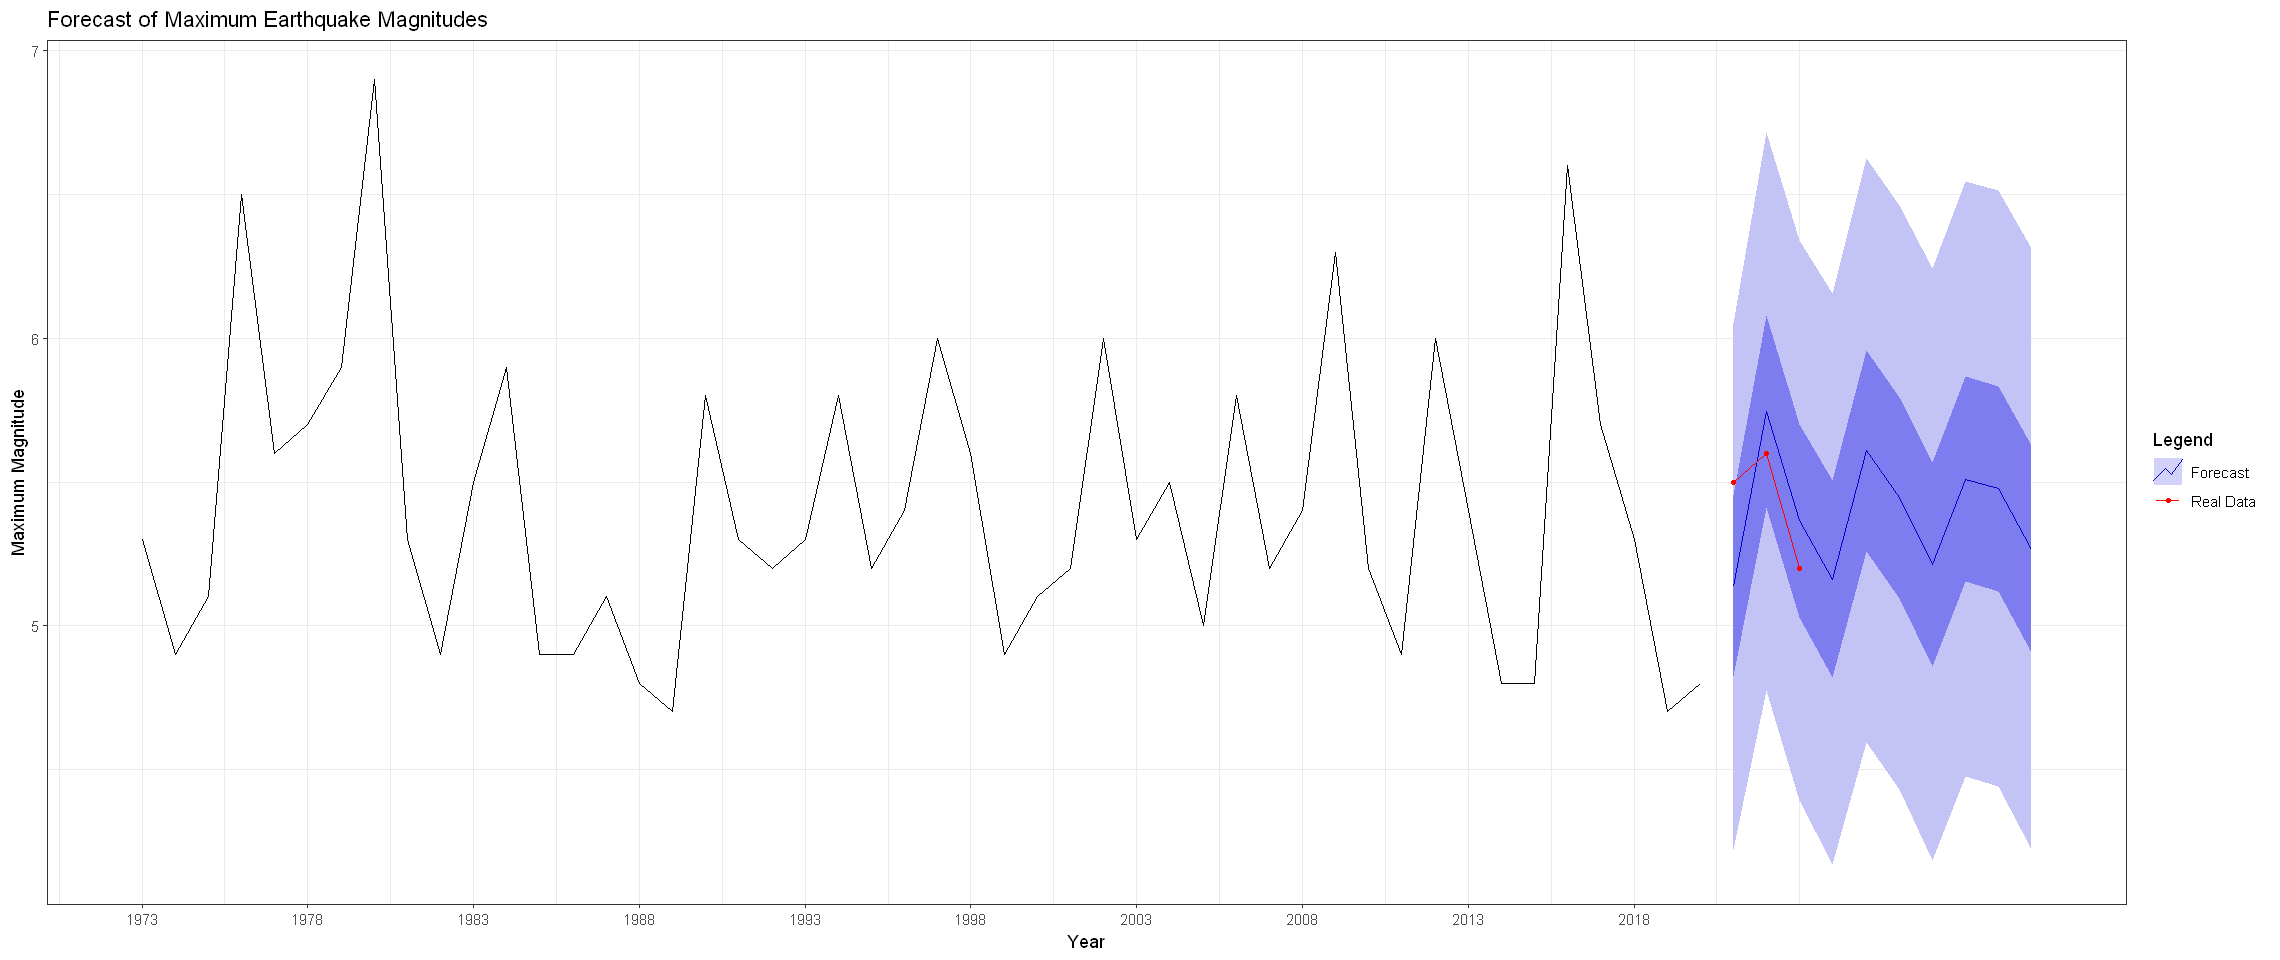

In [33]:
fit <- auto.arima(max_mag_ts_restricted)
forecasted <- forecast(fit, h = 10, level = c(50, 95))

p <- autoplot(forecasted, series = "Time Series") +
  autolayer(forecasted, series = "Forecast") +
  geom_point(data = earthquakes_per_year_future,
             aes(x = year, y = max_mag, color = "Real Data"), size = 1) +
  geom_line(data = earthquakes_per_year_future,
            aes(x = year, y = max_mag, color = "Real Data")) +
  scale_color_manual(values = c("Time Series" = "black",
                                "Forecast" = "blue", "Real Data" = "red")) +
  labs(title = "Forecast of Maximum Earthquake Magnitudes",
       x = "Year",
       y = "Maximum Magnitude",
       color = "Legend") +
  scale_x_continuous(breaks = seq(1973, 2020, by = 5)) +
  theme_bw()

print(p)

The forecasts appear to be fairly accurate when compared with the actual data from 2021-2023.

## Spatial Analysis

In [34]:
#sf package in R, which is used to convert objects to Simple Features (used for representing spatial geometries) objects.

italy_map <- st_read("gadm41_ITA_1.shp")

df_italia_sf <- st_as_sf(df_italia, coords = c("longitude", "latitude"),
                         crs = 4326)
#crs specifies that the Coordinate Reference System used is EPSG:4326, which corresponds to a commonly used coordinate system based on long and lat.

Reading layer `gadm41_ITA_1' from data source 
  `C:\Users\LENOVO PC\Dropbox\PC\Desktop\PoD\Advanced_Statistics\project\gadm41_ITA_1.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 20 features and 11 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 6.630879 ymin: 35.49292 xmax: 18.52069 ymax: 47.09265
Geodetic CRS:  WGS 84


In [35]:
italy_map$GID_0 <- NULL
italy_map$COUNTRY <- NULL
italy_map$COUNTRY <- NULL
italy_map$VARNAME_1 <- NULL
italy_map$NL_NAME_1 <- NULL
italy_map$TYPE_1 <- NULL
italy_map$ENGTYPE_1 <- NULL
italy_map$HASC_1 <- NULL
italy_map$CC_1 <- NULL
italy_map$ISO_1 <- NULL
italy_map$GID_1 <- NULL
italy_map$region <- italy_map$NAME_1
italy_map$NAME_1 <- NULL

In [36]:
st_crs(df_italia_sf) <- st_crs(italy_map)
df_italia_sf <- st_join(df_italia_sf, italy_map, join = st_nearest_feature)

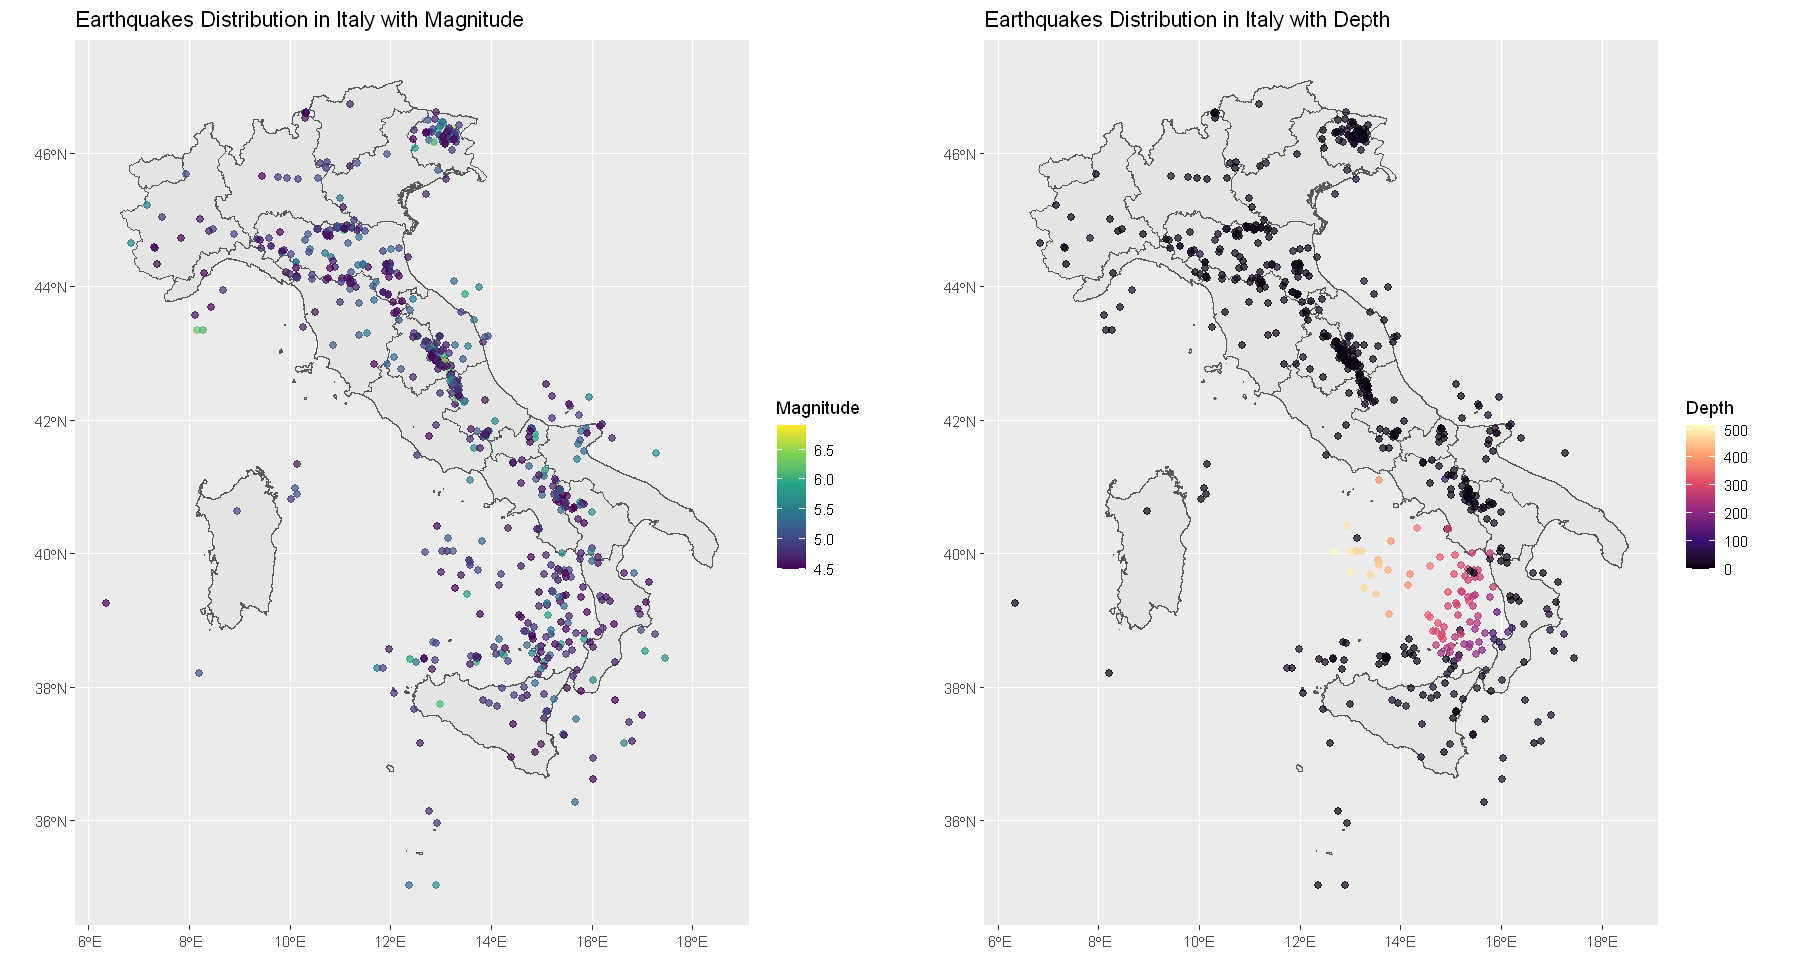

In [37]:
options(repr.plot.width = 15, repr.plot.height = 8)
mag_plot <- ggplot() +
  geom_sf(data = italy_map) +
  geom_sf(data = df_italia_sf, aes(color = mag), size = 2, alpha = 0.7) +
  scale_color_viridis_c() +
  labs(title = "Earthquakes Distribution in Italy with Magnitude",
       color = "Magnitude")

depth_plot <- ggplot() +
  geom_sf(data = italy_map) +
  geom_sf(data = df_italia_sf, aes(color = depth), size = 2, alpha = 0.7) +
  scale_color_viridis_c(option = "magma") +
  labs(title = "Earthquakes Distribution in Italy with Depth", color = "Depth")


grid.arrange(mag_plot, depth_plot, ncol = 2)

As we guessed before, deeper earthquakes are concentrated in a specific area. The deeper earthquakes are concentrated offshore, particularly in the areas around the Tyrrhenian Sea and the Adriatic Sea. Offshore regions, where the crust is thinner and the subduction of plates occurs, can experience deeper seismic activity.

In contrast, earthquake magnitude does not show a concentrated area pattern.

### Seismic Hazard

In [38]:
# Define a function to calculate the seismic hazard
seismic_hazard <- function(m, a, b) {
  10^(a + b * m)
}

In [39]:
# Create a grid for the map
grid_size <- 0.5
italy_map_grid <- st_make_grid(italy_map,
                               cellsize = c(grid_size, grid_size)) %>% st_sf()

#Assign earthquakes to grid cells
nearest_grid <- st_nearest_feature(df_italia_sf, italy_map_grid)
#Add grid cell attributes to df_italia_sf
df_italia_sf <- cbind(df_italia_sf, nearest_grid)
#Compute mean magnitude for each cell
cell_magnitudes <- df_italia_sf %>%
  group_by(nearest_grid) %>%
  summarize(mean_mag = sum(mag, na.rm = TRUE) / 589)

# Add the mean magnitudes to the grid cells
italy_map_grid <- st_join(italy_map_grid, cell_magnitudes)
maximum <- max(seismic_hazard(italy_map_grid$mean_mag, a, b), na.rm = TRUE)
normalize <- sum(maximum - seismic_hazard(italy_map_grid$mean_mag, a, b), na.rm = TRUE)
italy_map_grid$hazard <- (maximum - (seismic_hazard(italy_map_grid$mean_mag, a, b))) /normalize

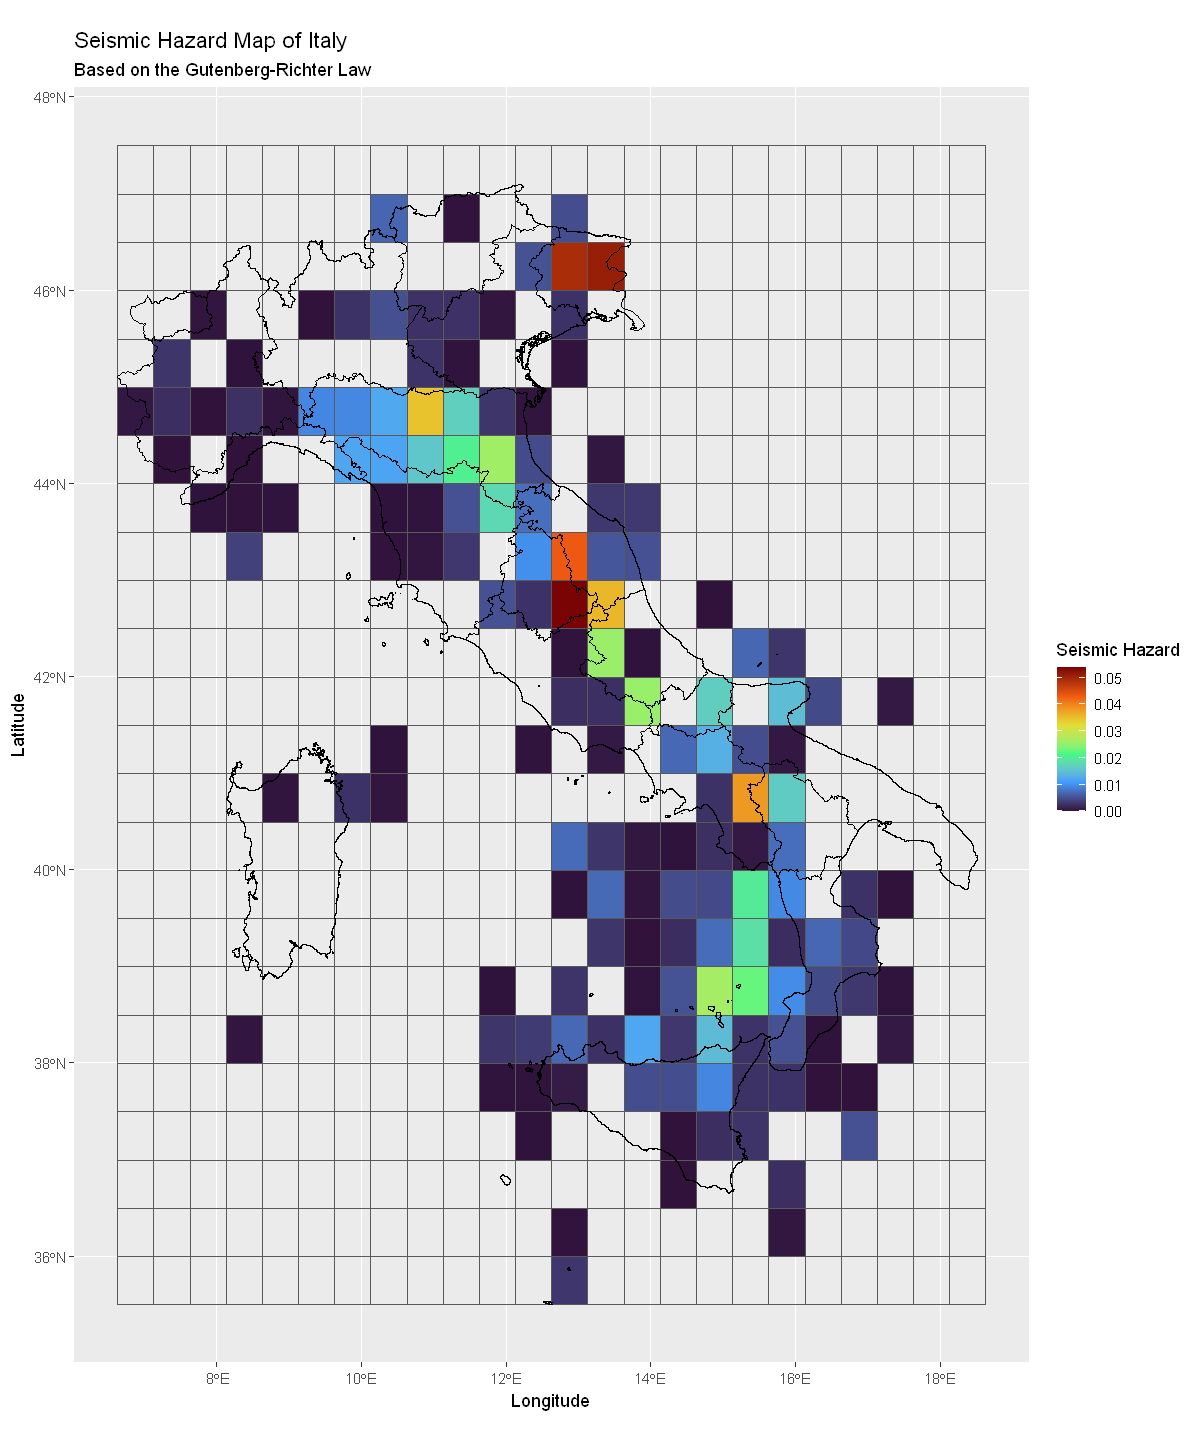

In [40]:
options(repr.plot.width = 10, repr.plot.height = 12)

ggplot() +
  geom_sf(data = italy_map_grid, aes(fill = hazard)) +
  geom_sf(data = italy_map, fill = NA, color = "black") +
  scale_fill_viridis_c(option="turbo",name = "Seismic Hazard", na.value = "#ffffff00") +
  labs(title = "Seismic Hazard Map of Italy",
       subtitle = "Based on the Gutenberg-Richter Law",
       x = "Longitude",
       y = "Latitude")


###  Regional study

We are interested in studying the distribution of earthquakes by region.

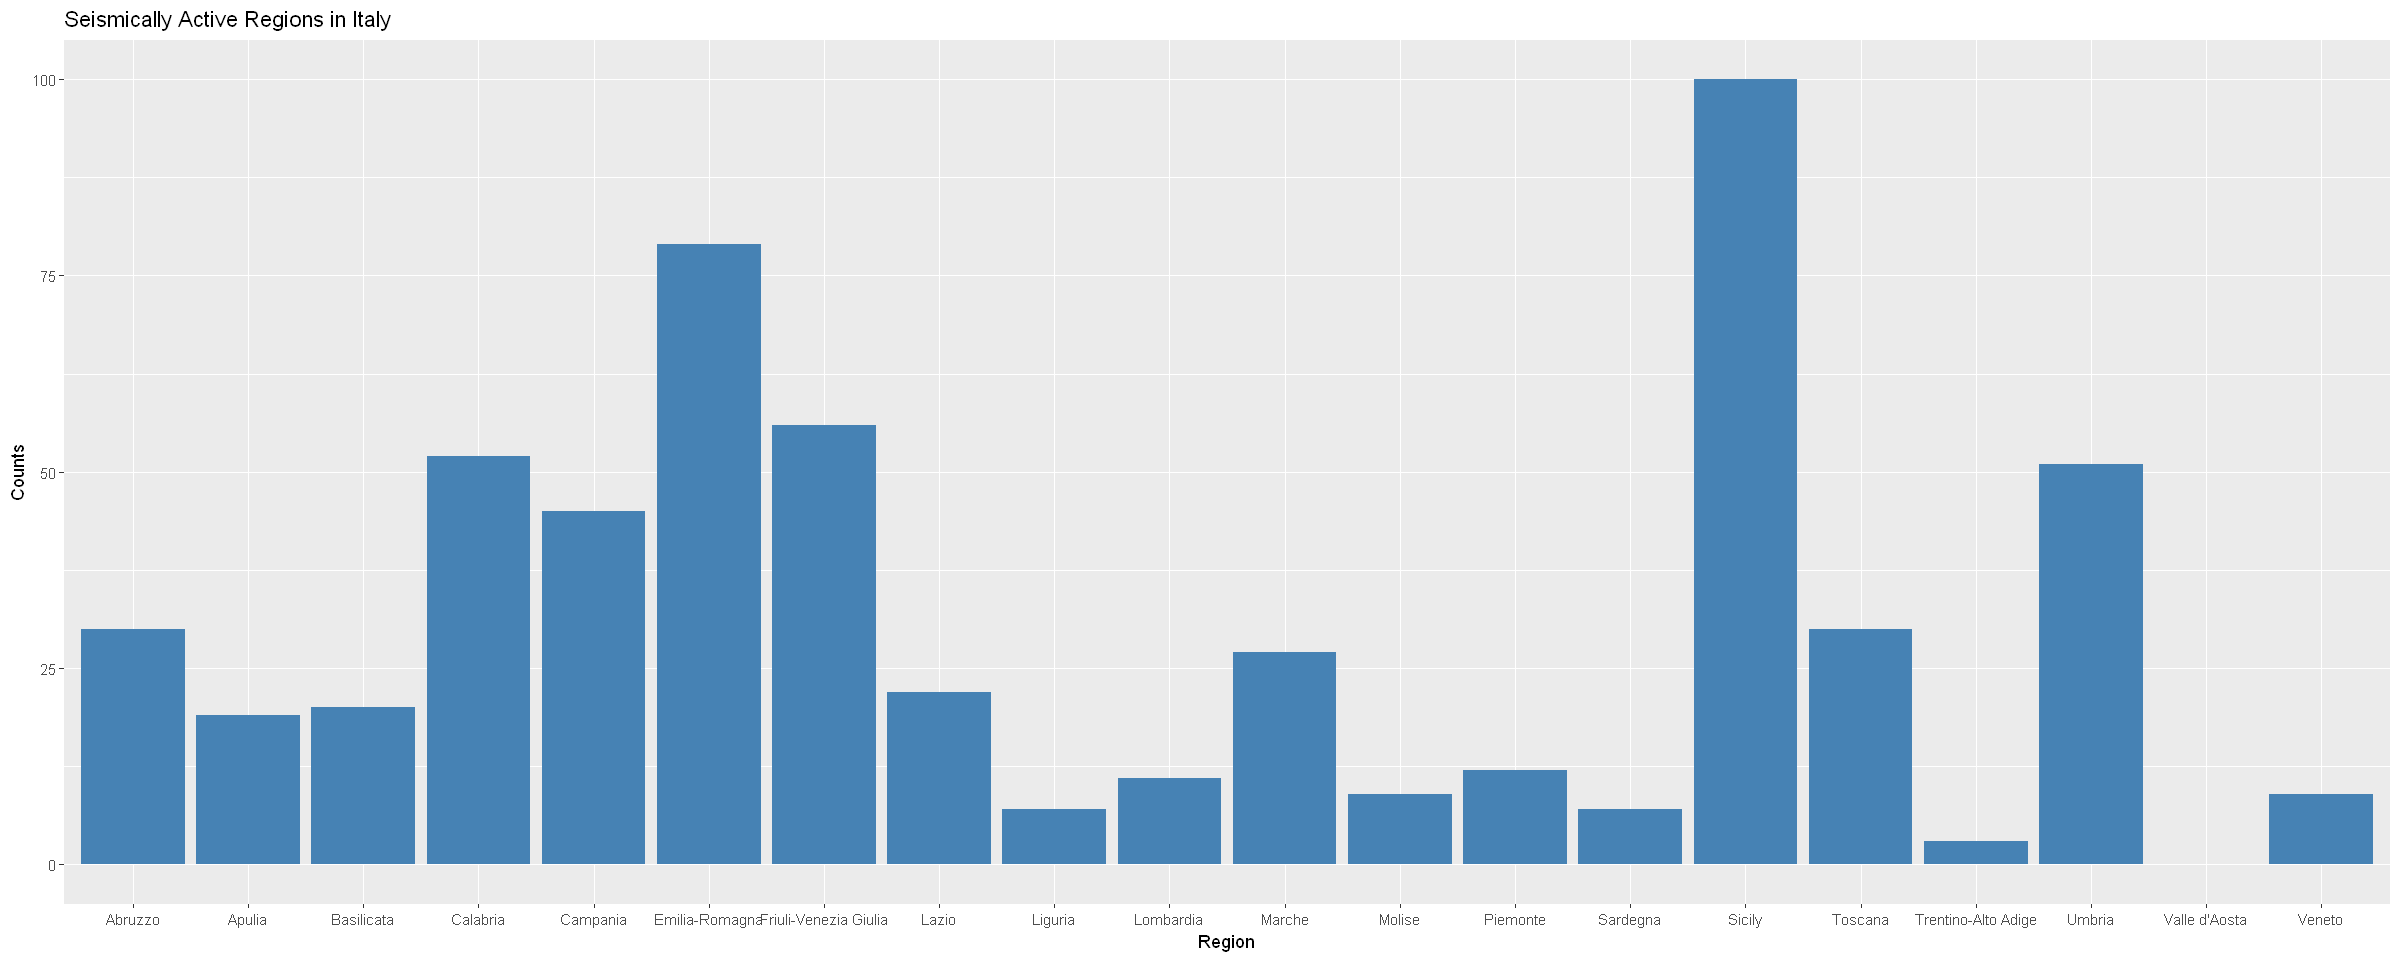

In [41]:
earthquakes_per_region <- df_italia_sf %>%
  group_by(region) %>%
  summarize(count = n())

e_per_region <- data.frame("region" = earthquakes_per_region$region,
                           "count" = earthquakes_per_region$count)
#add regions with no events
e_per_region <- rbind(e_per_region,
                      data.frame(region = "Valle d'Aosta", count = 0))
sorted_indices <- order(e_per_region$region)
e_per_region <- e_per_region[sorted_indices, ]
rownames(e_per_region) <- NULL

options(repr.plot.width = 20, repr.plot.height = 8)
ggplot(e_per_region, aes(x = region, y = count)) +
  geom_bar(fill = "steelblue", stat = "identity") +
  labs(title = "Seismically Active Regions in Italy",
       x = "Region",
       y = "Counts")

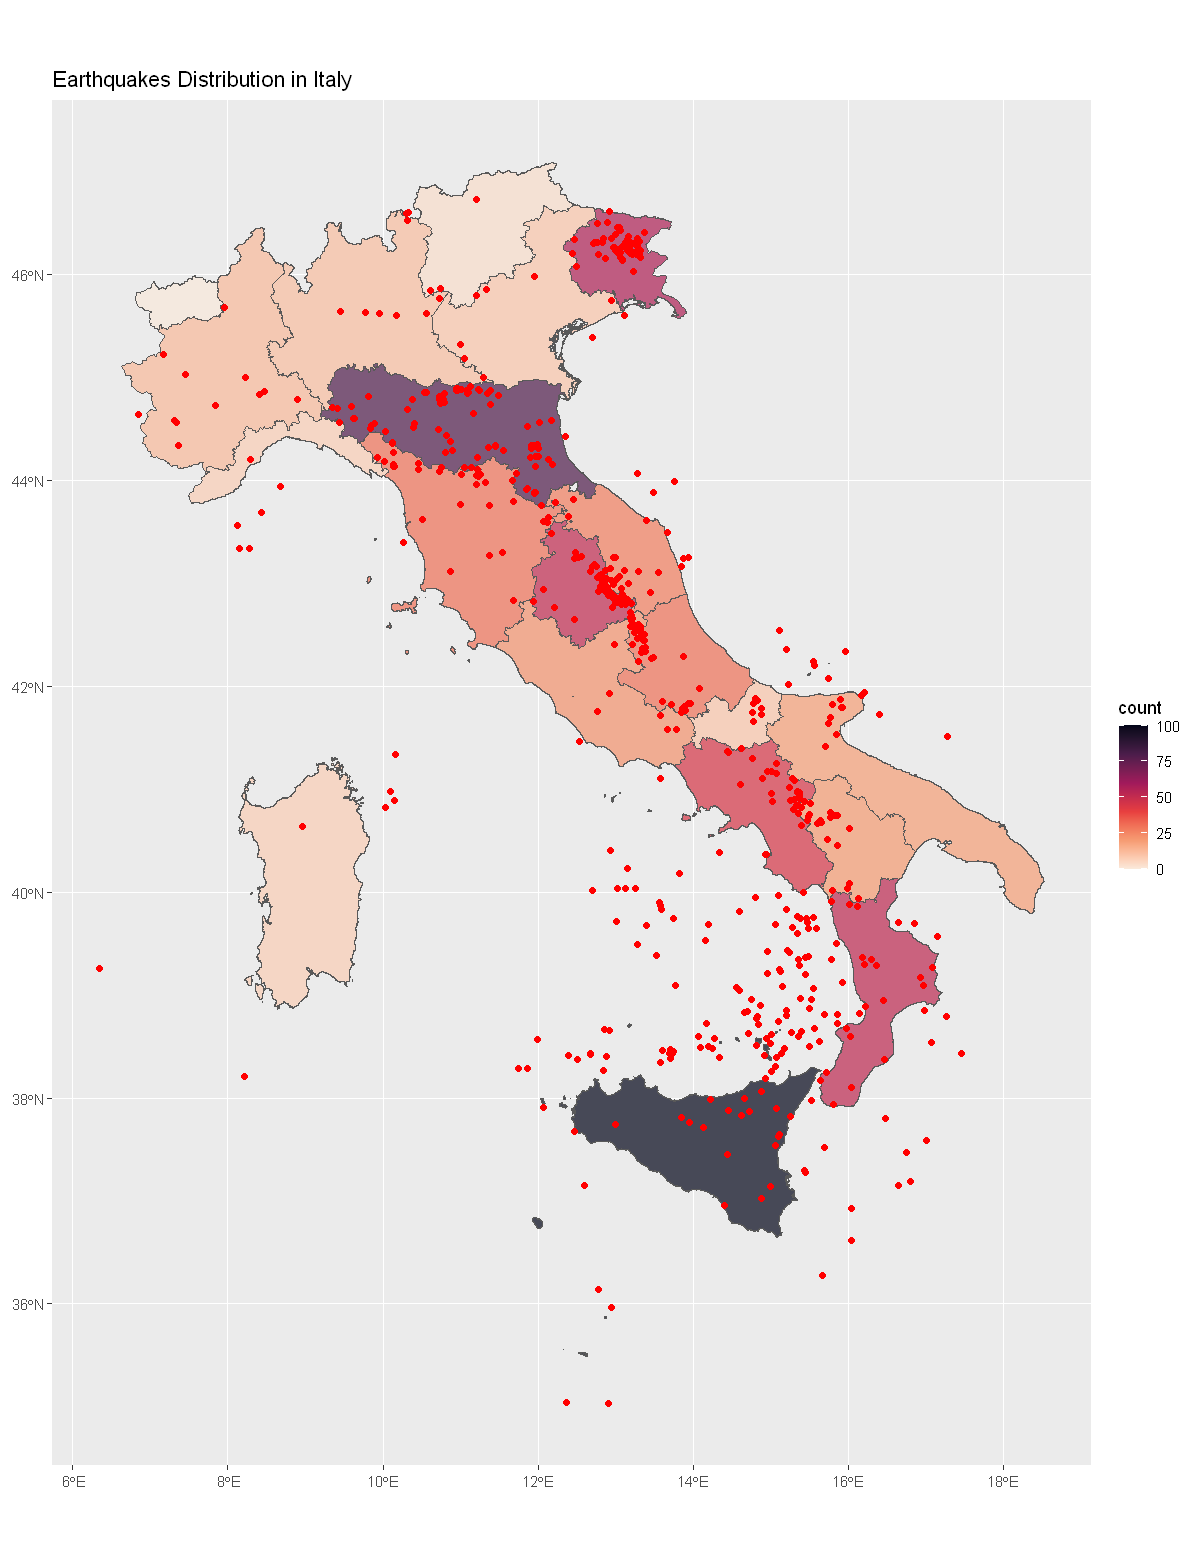

In [42]:
italy_map$count <- e_per_region$count

options(repr.plot.width = 10, repr.plot.height = 13)
ggplot() +
  geom_sf(data = italy_map) +
  geom_sf(data = italy_map, aes(fill = count), size = 1, alpha = 0.7) +
  geom_sf(data = df_italia_sf, color = "red", size = 1.5) +
  scale_fill_viridis_c(option = "rocket", direction = -1) +
  labs(title = "Earthquakes Distribution in Italy", color = "Magnitude")

### Clustering

We want to perform hierarchical clustering at the spatial level, to get the range of earthquake active areas.

integer(0)

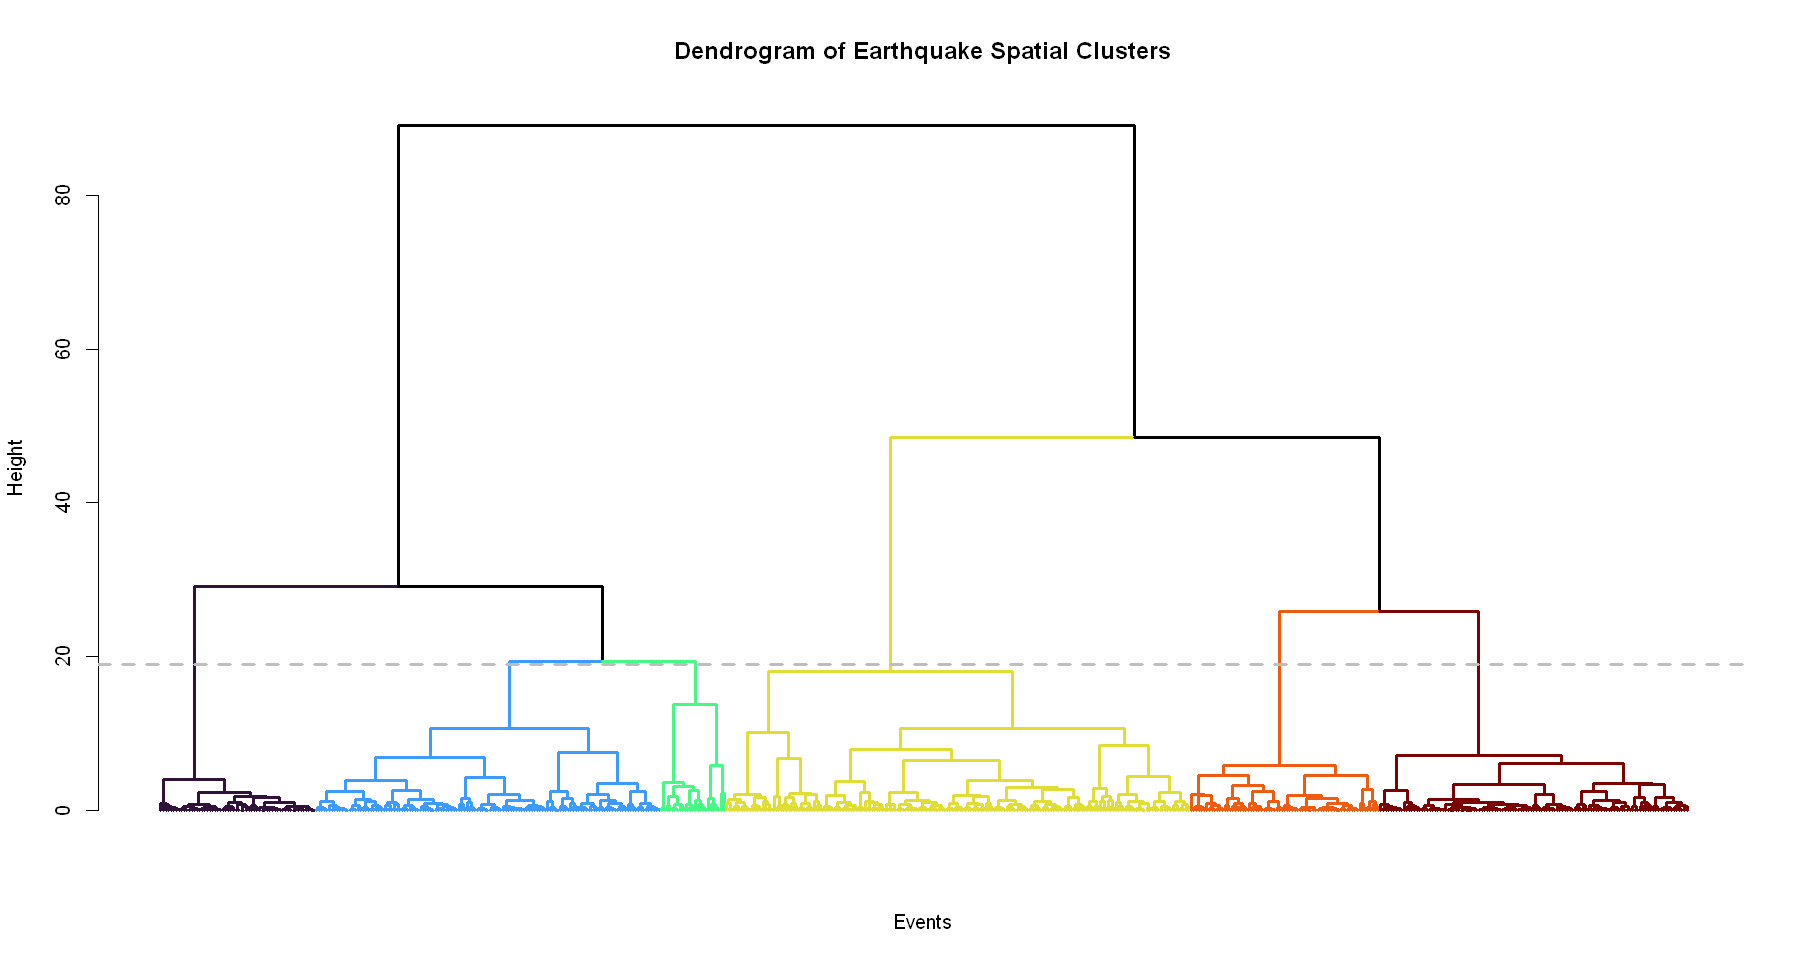

In [43]:
#Extracts the spatial coordinates from the sf object
coordinates <- st_coordinates(df_italia_sf)
cluster_data <- data.frame(coordinates, df_italia_sf$mag)

#Computes the distance matrix for the clustering.
dist_matrix <- dist(cluster_data)
#Performs hierarchical clustering using Ward’s method.
hclust_result <- hclust(dist_matrix, method = "ward.D2")

options(repr.plot.width = 15, repr.plot.height = 8)
#plot dendrogram
den <- as.dendrogram(hclust_result)
par(lwd = 2.5)
colors <- turbo(6, alpha = 1, begin = 0, end = 1, direction = 1)
den %>%
  set("branches_k_color", value = colors, k = 6) %>%
  plot(main = "Dendrogram of Earthquake Spatial Clusters",
       xlab = "Events", ylab = "Height",  leaflab = "none") +
  abline(h = 19, lt = "dashed", col = "grey")

A dendrogram is a type of tree diagram used to illustrate the arrangement of clusters produced by hierarchical clustering. In a dendrogram, each branch represents a cluster, and the leaves (the ends of the branches) represent individual elements or data points. It helps to determine the optimal number of clusters. By cutting the dendrogram at different levels, you can identify different groups or clusters. The number of groups can be determined by observing where the branches of the dendrogram merge. The length of the branches in the dendrogram indicates the distance or dissimilarity between data points or groups. Longer branches indicate greater dissimilarity.

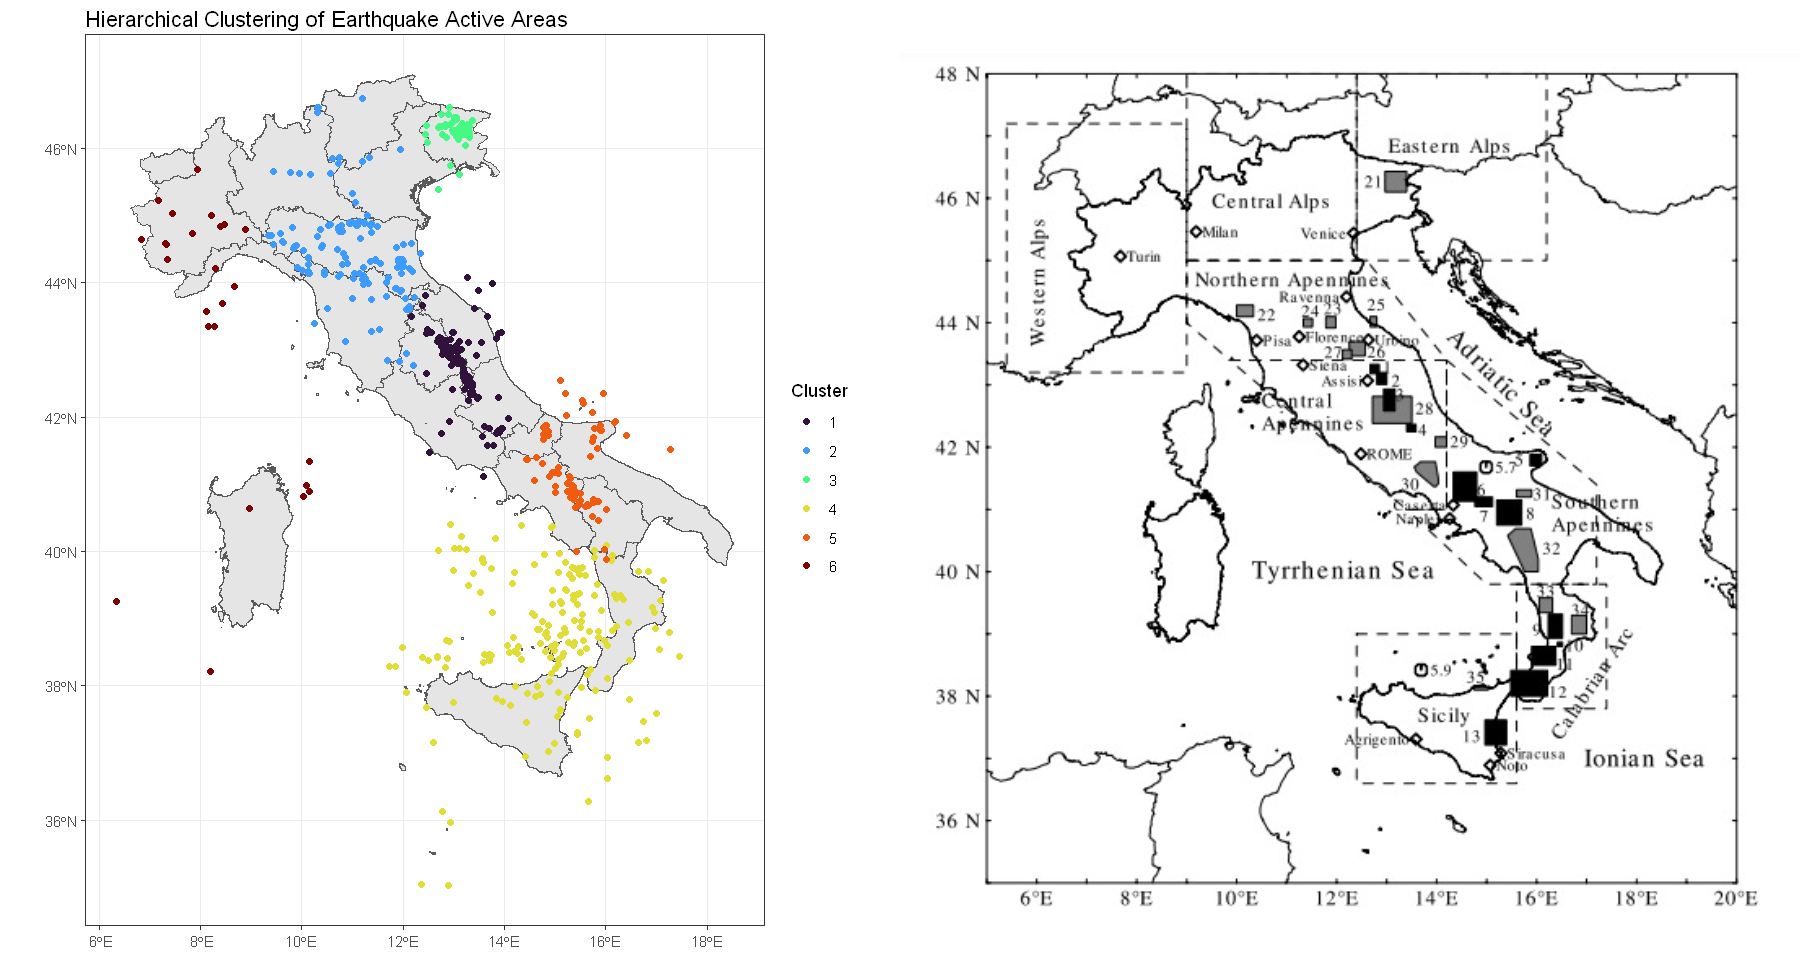

In [44]:
#cut the dendrogram to create 6 clusters.
clusters <- cutree(hclust_result, k = 6)
df_italia_sf$cluster <- as.factor(clusters)

cluster_plot <- ggplot() +
  geom_sf(data = italy_map) +
  geom_sf(data = df_italia_sf, aes(color = cluster)) +
  scale_color_viridis_d(option = "turbo", name = "Cluster") +
  labs(title = "Hierarchical Clustering of Earthquake Active Areas") +
  theme_bw()


image_path <- "clustering.jpg"
img <- image_read(image_path)

image_grob <- rasterGrob(as.raster(img), interpolate = TRUE)

options(repr.plot.width = 15, repr.plot.height = 8)
grid.arrange(cluster_plot, image_grob, ncol = 2)

from: *Seismic source zones based on a spatial clustering of historical seismicity used to compute occurrence probabilities of earthquakes with M ‡ 6 from Romeo, R.W. Earthquake Hazard in Italy, 2001–2030. Nat Hazards 36, 383–405 (2005) [link](https://doi.org/10.1007/s11069-005-1939-1)*

In [45]:
earthquakes_per_cluster <- df_italia_sf %>%
  group_by(cluster) %>%
  summarize(count = n())

zones <- c("Central Appenines", "Northen Appenines", "Eastern Alps",
           "Calabrian and Sicilian Arc",  "Southern Appenines", "Western Alps")

earthquakes_per_cluster$cluster <- zones

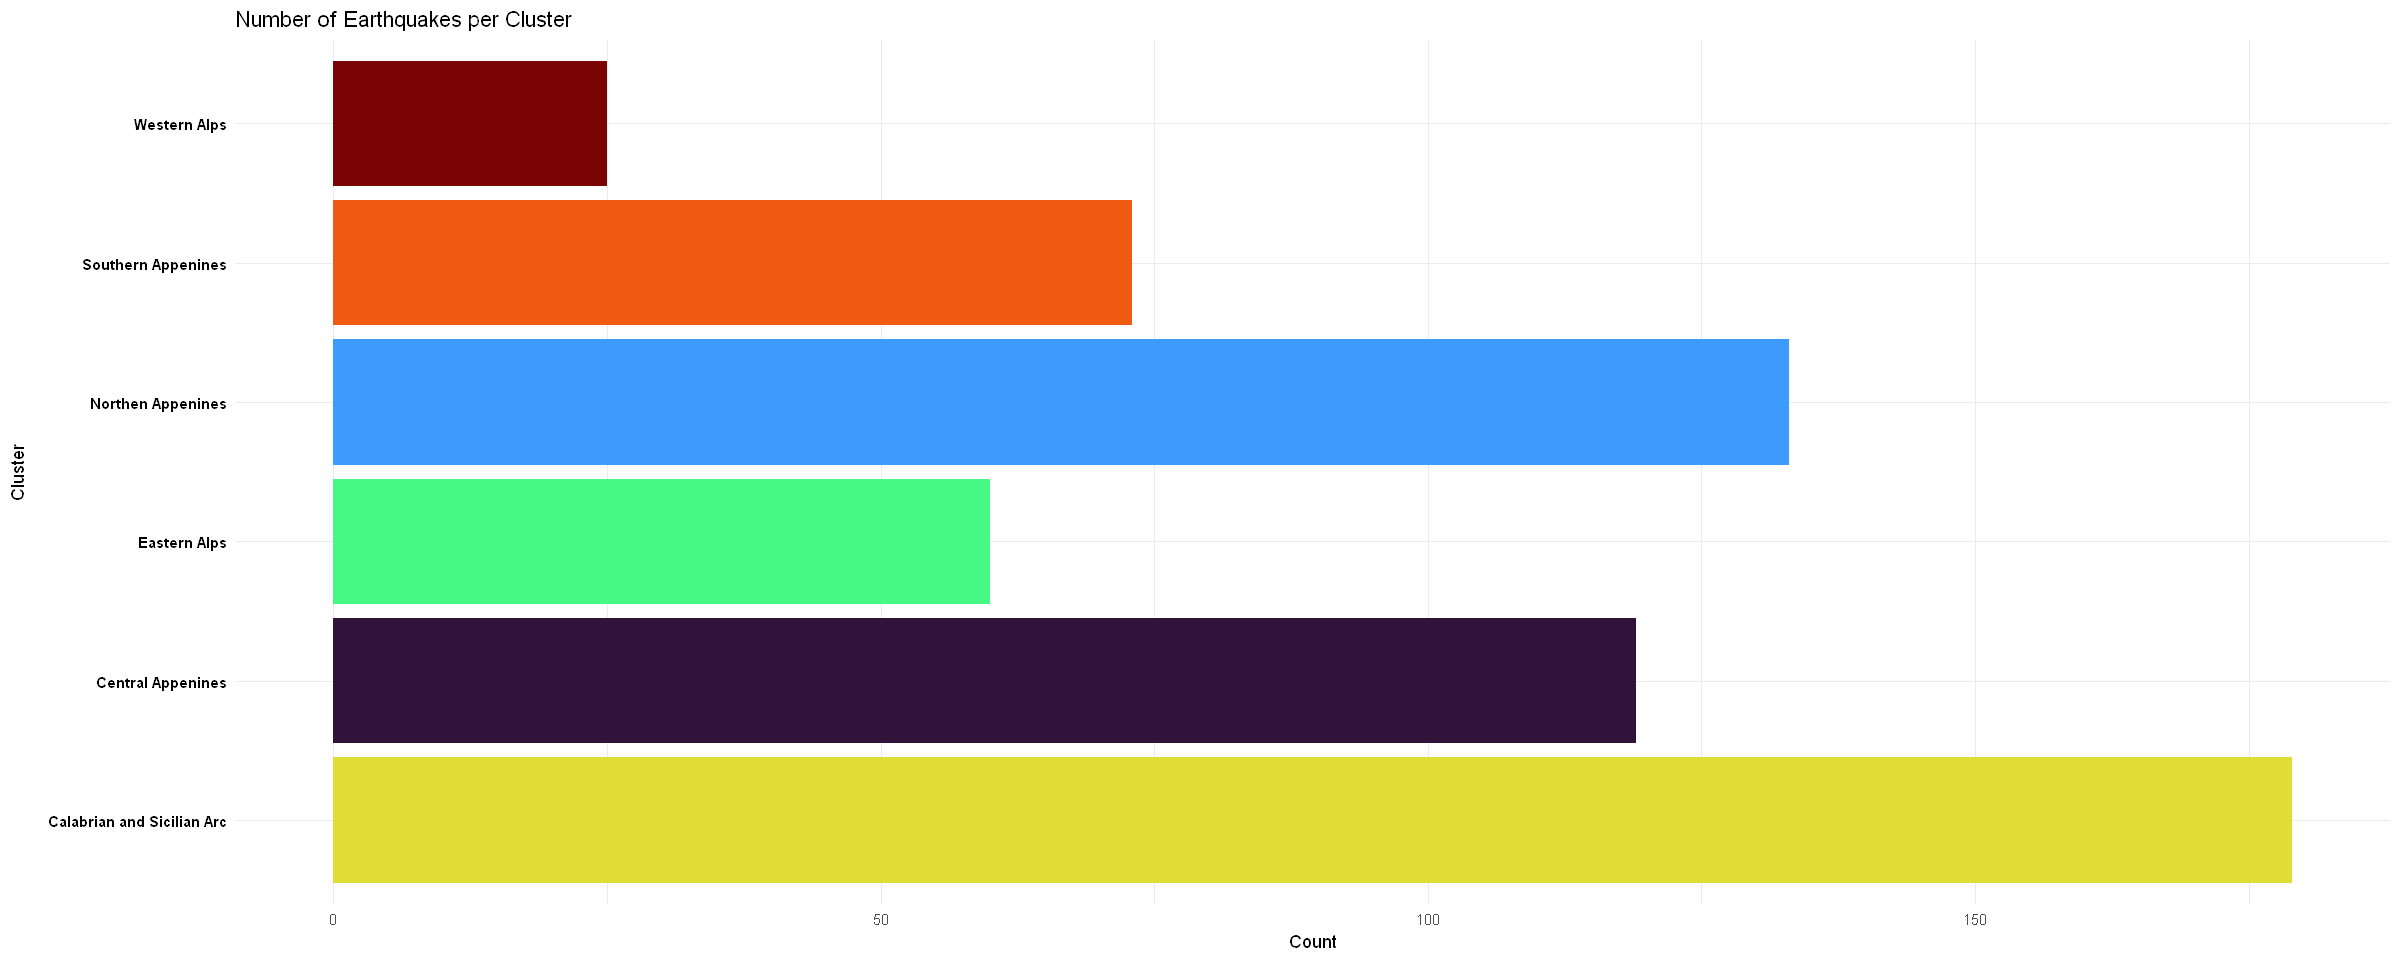

In [46]:
options(repr.plot.width = 20, repr.plot.height = 8)

ggplot(earthquakes_per_cluster, aes(y = cluster, x = count)) +
  geom_bar(fill = colors, stat = "identity") +
  labs(title = "Number of Earthquakes per Cluster",
       y = "Cluster",
       x = "Count") +
  theme_minimal() +
  theme(axis.text.y = element_text(color = "black", face = "bold"))


In [47]:
total <- sum(earthquakes_per_cluster$count)
earthquakes_per_cluster$prob <- earthquakes_per_cluster$count / total

most_likely_cluster <- earthquakes_per_cluster[which.max(earthquakes_per_cluster$prob), ]

print(paste("The next earthquake is most likely to occur in the:",
            most_likely_cluster$cluster))
print(paste("Probability:", round(most_likely_cluster$prob * 100, 2), "%"))

[1] "The next earthquake is most likely to occur in the: Calabrian and Sicilian Arc"
[1] "Probability: 30.39 %"


We can sample where the next 10 earthquakes are going to be, using a multinomial distribution

In [48]:
#draw samples from a multinomial distribution
next_earthquakes <- rmultinom(n = 1, size = 10, prob = earthquakes_per_cluster$prob)
next_earthquakes_df <- data.frame(cluster = earthquakes_per_cluster$cluster, count = next_earthquakes)

print("Distribution of the next 10 earthquakes among clusters:")
print(next_earthquakes_df)

[1] "Distribution of the next 10 earthquakes among clusters:"
                     cluster count
1          Central Appenines     1
2          Northen Appenines     4
3               Eastern Alps     0
4 Calabrian and Sicilian Arc     2
5         Southern Appenines     3
6               Western Alps     0
